In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
from quocslib.utils.AbstractFoM import AbstractFoM
from quocslib.timeevolution.piecewise_integrator import pw_evolution
import functools
from scipy.linalg import sqrtm
import numpy as np
from scipy.sparse import kron
from scipy.sparse import csr_matrix
from scipy.sparse import eye
from scipy.sparse.linalg import expm
from qutip import Bloch, basis

In [2]:
def sigma_x():
    return np.array([[0, 1], [1, 0]])/np.sqrt(2)
def sigma_y():
    return np.array([[0, -1j], [1j, 0]])/np.sqrt(2)
def sigma_z():
    return np.array([[1, 0], [0, -1]])/np.sqrt(2)

In [3]:
def is_unitary(matrix):
    """
    Check if a given matrix is unitary.
    """
    product = np.dot(matrix, np.conj(matrix.T))
    identity = np.eye(matrix.shape[0])
    return np.allclose(product, identity)

def build_submatrix(matrix, indices):
    """
    Build a submatrix of a given matrix.

    Parameters:
        matrix (ndarray): Matrix from which to extract the submatrix.
        indices (list): List of indices to extract from the matrix.

    Returns:
        ndarray: Submatrix of the given matrix.
    """
    return matrix[np.ix_(indices, indices)]

def Rabi_hamiltonian(omega, phi, detuning=0):
    """
    Construct the Hamiltonian for a single qubit with Rabi oscillation driven by a laser.

    Parameters:
        omega (float): Rabi frequency of the laser.
        phi (float): Phase of the laser.

    Returns:
        ndarray: Hamiltonian matrix.
    """
    ground_state = np.array([[1], [0]])  # |g⟩
    excited_state = np.array([[0], [1]]) # |r⟩  
    H = (omega / 2) * (np.exp(1j * phi) * np.outer(ground_state, excited_state.conj()) +
                       np.exp(-1j * phi) * np.outer(excited_state, ground_state.conj()))
    H = H + detuning * np.outer(excited_state, excited_state.conj())
    return H

def Interaction_hamiltonian(V):
    """
    Construct the interaction Hamiltonian for two qubits.

    Parameters:
        V (float): Interaction strength between the qubits.

    Returns:
        ndarray: Interaction Hamiltonian matrix.
    """
    ground_state = np.array([[0], [1]])  # |r1⟩
    excited_state = np.array([[0], [1]]) # |r2⟩  

    H = V * np.outer(np.outer(ground_state, excited_state.conj()),
                     np.outer(ground_state, excited_state.conj()).conj().T)
    return H

def total_interaction_hamiltonian(V, n):
    """
    Construct the total interaction Hamiltonian for n qubits.

    Parameters:
        V (float): Interaction strength between the qubits.
        n (int): Number of qubits.

    Returns:
        ndarray: Interaction Hamiltonian matrix.
    """
    a = np.array([[0, 0], [0, 1]])
    H = np.zeros((2**n, 2**n))
    for i in range(n):
        for j in range(i+1, n):
            H += V*kron(kron(eye(2**i), kron(a, eye(2**(j-i+-1)))), kron(a, eye(2**(n-j-1)))) 
    return H

def SA_H_0(omega, phi, detuning, n):
    """
    Construct the total non-interaction Hamiltonian for n qubits.

    Parameters:
        V (float): Interaction strength between the qubits.
        n (int): Number of qubits.

    Returns:
        ndarray: Interaction Hamiltonian matrix.
    """
    a = Rabi_hamiltonian(omega, phi, detuning)
    H = np.zeros((2**n, 2**n))
    for i in range(n):
        H += kron(kron(eye(2**i), a), eye(2**(n-i-1)))
    return H

def time_evolution(sparse_hamiltonian, time):
    """
    Calculate the time evolution of a quantum system given a sparse Hamiltonian.

    Parameters:
        sparse_hamiltonian (csr_matrix): Sparse Hamiltonian matrix.
        time (float): Time at which to calculate the evolution.

    Returns:
        evolution_operator (csr_matrix): Unitary evolution.
    """
    # Calculate the time evolution operator
    evolution_operator = expm(-1j * sparse_hamiltonian * time)

    return evolution_operator


# Interaction Hamiltonians
def H_int_S_a(S, V):
    return total_interaction_hamiltonian(V, S+1)

def H_int_S_S(S, V):
    # Maybe you should consider different interaction strengths
    return total_interaction_hamiltonian(V, 2*S)

def H_int_a_a(V):
    return total_interaction_hamiltonian(V, 2)


def build_H_int(chain, S, V):

    # Calculate the number of atoms
    N = 0
    for i in range(0, len(chain)):
        if chain[i] == "A" or chain[i] == "B":
            N += 1
        elif chain[i] == "SA" or chain[i] == "SB":
            N += S

    #print("number of atoms: ", N)

    # Initialize the interaction Hamiltonian
    H_int = 0
    j = 0 # index of the atom in the chain
    for i in range(0, len(chain)-1):
        if chain[i] == "A":
            if chain[i+1] == "SA" or chain[i+1] == "SB":
                H_int += kron(eye(2**j), kron(H_int_S_a(S, V), eye(2**(N-j-1-S))))
            elif chain[i+1] == "B":
                H_int += kron(eye(2**j), kron(H_int_a_a(V), eye(2**(N-j-2))))
            j += 1

        elif chain[i] == "B":
            if chain[i+1] == "SA" or chain[i+1] == "SB":
                H_int += kron(eye(2**j), kron(H_int_S_a(S, V), eye(2**(N-j-1-S))))
            elif chain[i+1] == "A":
                H_int += kron(eye(2**j), kron(H_int_a_a(V), eye(2**(N-j-2))))
            j += 1

        elif chain[i] == "SA":
            if chain[i+1] == "A" or chain[i+1] == "B":
                H_int += kron(eye(2**j), kron(H_int_S_a(S, V), eye(2**(N-j-1-S))))
            elif chain[i+1] == "SB":
                H_int += kron(eye(2**j), kron(H_int_S_S(S, V), eye(2**(N-j-2*S))))
            j += S
            
        elif chain[i] == "SB":
            if chain[i+1] == "A" or chain[i+1] == "B":
                H_int += kron(eye(2**j), kron(H_int_S_a(S, V), eye(2**(N-j-1-S))))
            elif chain[i+1] == "SA":
                H_int += kron(eye(2**j), kron(H_int_S_S(S, V), eye(2**(N-j-2*S))))
            j += S

    return H_int


def build_H_0(chain, omega_A, phi_A, detuning_A, omega_B, phi_B, detuning_B, S):
    # Calculate the number of atoms
    N = 0
    for i in range(0, len(chain)):
        if chain[i] == "A" or chain[i] == "B":
            N += 1
        elif chain[i] == "SA" or chain[i] == "SB":
            N += S

    #print("number of atoms: ", N)

    # Initialize the non-interaction Hamiltonian
    H_0 = 0
    j = 0 # index of the atom in the chain
    for i in range(0, len(chain)):
        if chain[i] == "A":
            H_0 += kron(eye(2**j), kron(Rabi_hamiltonian(omega_A, phi_A, detuning_A), eye(2**(N-j-1))))
            j += 1

        elif chain[i] == "B":
            H_0 += kron(eye(2**j), kron(Rabi_hamiltonian(omega_B, phi_B, detuning_B), eye(2**(N-j-1))))
            j += 1

        elif chain[i] == "SA":
            H_0 += kron(eye(2**j), kron(SA_H_0(omega_A, phi_A, detuning_A, S), eye(2**(N-j-S))))
            j += S

        elif chain[i] == "SB":
            H_0 += kron(eye(2**j), kron(SA_H_0(omega_B, phi_B, detuning_B, S), eye(2**(N-j-S))))
            j += S

    return H_0


In [4]:
def get_static_hamiltonian(chain, S, V, omega_A, phi_A, detuning_A, omega_B, phi_B, detuning_B):
    H_s = build_H_int(chain, S,V)
    H_s += build_H_0(chain, omega_A, phi_A, detuning_A, omega_B, phi_B, detuning_B, S)
    return H_s

def H_control_A(ii):
    if ii == 1:
        return  np.outer(np.array([[0], [1]]), np.array([[0], [1]]).conj())
    elif ii == 2:
        print("Invalid control Hamiltonian index")
    else:
        print("Invalid control Hamiltonian index")

def H_control_SA(ii, S):
    H = np.zeros((2**S, 2**S))
    for i in range(S):
        H += kron(kron(eye(2**i), H_control_A(ii)), eye(2**(S-i-1)))
    return H


def get_control_hamiltonian_ii(chain, S, ii): # ii is the index of the control Hamiltonian
    # Calculate the number of atoms
    N = 0
    for i in range(0, len(chain)):
        if chain[i] == "A" or chain[i] == "B":
            N += 1
        elif chain[i] == "SA" or chain[i] == "SB":
            N += S
    H_0 = 0
    j = 0 # index of the atom in the chain
    for i in range(0, len(chain)):
        if chain[i] == "B":
            H_0 += kron(eye(2**j), kron(H_control_A(ii), eye(2**(N-j-1))))
            j += 1

        elif chain[i] == "SB":
            H_0 += kron(eye(2**j), kron(H_control_SA(ii, S), eye(2**(N-j-S))))
            j += S

        if chain[i] == "A":
            j += 1

        elif chain[i] == "SA":
            j += S
    return H_0

In [5]:
# define gate fidelity
def gate_fidelity(U, U_target):
    dim = U.shape[0]
    return np.abs(np.trace(U_target.T.conj() @ U))**2 / dim**2

def time_evolution(props, drive, H_drift, H_control, n_slices, dt):
    """
    Calculate the time evolution of a quantum system given a sparse Hamiltonian.

    Parameters:
        sparse_hamiltonian (csr_matrix): Sparse Hamiltonian matrix.
        time (float): Time at which to calculate the evolution.

    Returns:
        evolution_operator (csr_matrix): Unitary evolution.
    """
    # Calculate the time evolution operator
    for i in range(n_slices):
        props[i] = expm(-1j * (H_drift + drive[0][i]*H_control[0]) * dt)
    return props

def get_initial_state():
    psi_0 = np.zeros((5*[2]))
    psi_0[0,0,0,0,1] = 1/np.sqrt(2) # |r GG g>
    psi_0[0,0,0,0,0] = 1/np.sqrt(2) # |g GG g>
    #psi = psi_0.flatten()
    #psi_0 = np.zeros(2**4)
    #psi_0[0] = 1 / np.sqrt(2)
    #psi_0[1] = 1 / np.sqrt(2)
    return psi_0.flatten()

def get_target_state(phi_0):
    psi_f = np.zeros((5*[2]))
    psi_f[0,0,0,0,1] = 1/np.sqrt(2) # |r GG g>
    psi_f[0,0,0,0,0] = -1 /np.sqrt(2) # |g GG g>
    #psi_f = np.zeros(2**4)
    #psi_f[0] = -np.exp(1j*phi_0) / np.sqrt(2)
    #psi_f[1] = 1 / np.sqrt(2)

    return psi_f.flatten()

def state_fidelity(psi1, psi2):
    return np.abs(np.dot(np.conj(psi1), psi2)) ** 2 / (np.linalg.norm(psi1) * np.linalg.norm(psi2))

def fidelity_funct(psi1, psi2):
    rho2 = np.outer(psi1, np.conj(psi1).T)
    rho1 = np.outer(psi2, np.conj(psi2).T)
    return np.abs(np.trace(sqrtm(sqrtm(rho2) @ rho1 @ sqrtm(rho2)))) ** 2


class Ryd_chain(AbstractFoM):
    """
    A figure of merit class for optimization of a Rydberg chain.
    """
    def __init__(self, args_dict: dict = None):
        if args_dict is None:
            args_dict = {}

        ################################################################################################################
        # Dynamics variables
        ################################################################################################################
        self.chain = args_dict.setdefault("chain", ["B", "A", "SB", "A"])
        self.S = args_dict.setdefault("S", 2)
        self.V = args_dict.setdefault("V", 211)
        self.n_slices = args_dict.setdefault("n_slices", 100)
        self.psi_0 = get_initial_state()
        self.omegaB = args_dict.setdefault("omegaB", 10)

        self.is_maximization = args_dict.setdefault("is_maximization", False)
        self.FoM_factor = 1
        if self.is_maximization:
            self.FoM_factor = -1

        #self.H_drift = np.zeros((2,2), dtype=np.complex128)
        #self.H_control = [sigma_x(), sigma_y()]
        self.H_drift = get_static_hamiltonian(self.chain, self.S, self.V, 0,0,0,self.omegaB,0,0).toarray()
        self.H_control = [get_control_hamiltonian_ii(self.chain, self.S, 1)]
        #self.H_control = [get_control_hamiltonian_ii(self.chain, self.S, ii).toarray() for ii in range(1, 3)]
        #self.H_control = [*self.H_control, np.kron(np.eye(2), np.kron(sigma_z(), np.eye(2)))]


    def get_control_Hamiltonians(self):
        return self.H_control

    def get_drift_Hamiltonian(self):
        return self.H_drift
    

    def get_FoM(self, pulses: list = [], parameters: list = [], timegrids: list = []) -> dict:

        drive = [pulses[i].reshape(len(pulses[i])) for i in range(len(pulses))]
        #print("test drive", drive[0][0])
        n_slices = self.n_slices
        # you have to take same dt for all the pulses
        time_grid = timegrids[0]
        dt = time_grid[1] - time_grid[0]
        #dt = time_grid[-1] / len(time_grid)
        # Compute the time evolution
        propsS = [np.eye(2**5, dtype=np.complex128) for i in range(n_slices)]
        propsS = time_evolution(propsS, drive, self.H_drift, self.H_control, n_slices, dt)
        U_1S = functools.reduce(lambda a, b: a @ b, propsS)
        #U_2S = functools.reduce(lambda a, b: a @ b, np.flip(propsS))
        drive_flipped = [np.flip(pulses[i].reshape(len(pulses[i]))) for i in range(len(pulses))]
        propsS = [np.eye(2**5, dtype=np.complex128) for i in range(n_slices)]
        propsS = time_evolution(propsS, drive_flipped, self.H_drift, self.H_control, n_slices, dt)
        U_2S = functools.reduce(lambda a, b: a @ b, propsS)

        chain = ["B"]
        drift= get_static_hamiltonian(chain, self.S, self.V, 0, 0, 0, self.omegaB, 0, 0).toarray()
        control = [get_control_hamiltonian_ii(chain, self.S, 1).toarray()]
        props = [np.eye(2**1, dtype=np.complex128) for i in range(n_slices)]
        props = time_evolution(props, drive, drift, control, n_slices, dt)
        U_1 = functools.reduce(lambda a, b: a @ b, props)
        props = [np.eye(2**1, dtype=np.complex128) for i in range(n_slices)]
        props = time_evolution(props, drive_flipped, drift, control, n_slices, dt)
        U_2 = functools.reduce(lambda a, b: a @ b, props)
        #U_2 = functools.reduce(lambda a, b: a @ b, np.flip(props))

        #print("U_1: ", U_1)

        psi_0_S = self.psi_0
        psi_1_S = np.zeros((2**5))
        psi_1_S[0] = 1
        psi_0 = np.zeros((2**1))
        psi_0[0] = 1

        #print("Coeff of psi: ", np.abs(psi_0[0])**2)
        #print("Coeff of psi_S: ",  np.abs(psi_0_S[0])**2)


        #first half evolution
        psi_S = U_1S @ psi_0_S
        psi_S_1 = U_1S @ psi_1_S
        psi = U_1 @ psi_0
        #print("Coeff of psi: ", np.abs(psi[0])**2)
        #print("Coeff of psi_S: ",  np.abs(psi_S[0])**2)

        #second half of triangle
        psi_S = U_2S @ psi_S
        psi_S_1 = U_2S @ psi_S_1
        psi = U_2 @ psi

        phi_0 = np.angle(psi[0])
        psi_targ = get_target_state(phi_0)
        #print(phi_0)
        print("Coeff of psi: ", np.abs(psi[0])**2)
        print("Coeff of psi_targ: ",  np.abs(psi_S[0])**2)

        #U_S = U_2S @ U_1S
        #U_S = build_submatrix(U_S, [0, 8, 1, 9])
        #U_target = np.array([[-1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
        fidelity = -1 * self.FoM_factor * ( state_fidelity(psi_S, psi_targ) + state_fidelity(psi, psi_0) + state_fidelity(psi_S_1, psi_1_S) )
        #fidelity = -1 * self.FoM_factor * ( state_fidelity(psi_S, psi_targ) )
        #fidelity = -1 * self.FoM_factor * ( state_fidelity(psi_S, psi_targ)+ gate_fidelity(U_S, U_target))
        # print time and fidelity

        #fidelity = -1 * self.FoM_factor * (fidelity_funct(psi_S, psi_targ))

        return {"FoM": fidelity}
    
    def get_Bloch_sphere(psi_t, indexes_0, indexes_1, z_labels, angles=[90, 15]):
        # Print the evolution of the state |g GR g> in a Bloch sphere 
        b = Bloch(view=angles)
        b.point_marker = ['o']
        colors = ['b' for i in range(N)]
        b.point_color = colors
        b.point_size = [15]
        b.font_size = 18
        b.zlpos = [1.2, -1.2]
        b.zlabel = z_labels
        for psi_i in psi_t:
            c_0 = np.sum(psi_i[indexes_0])/np.sqrt(len(indexes_0))
            c_1 = np.sum(psi_i[indexes_1])/np.sqrt(len(indexes_1))
            vec = ( c_0 * basis(2,0)  + c_1 * basis(2,1))
            b.add_states(vec, kind='point')

        b.figsize = [5, 10]
        b.show()
        b.render()
        b.save('b.png')


In [6]:
optimization_dictionary = {"optimization_client_name": "Ryd_chain_dCRAB"}


In [7]:
optimization_dictionary["algorithm_settings"] = { "algorithm_name": "dCRAB"}
optimization_dictionary["algorithm_settings"]["optimization_direction"] = "maximization"
optimization_dictionary["algorithm_settings"]["super_iteration_number"] = 3
optimization_dictionary["algorithm_settings"]["max_eval_total"] = 3000

In [8]:
dsm_settings = {
        "general_settings": {
            "dsm_algorithm_name": "NelderMead",
            "is_adaptive": False,
        },
        "stopping_criteria": {
            "xatol": 1e-4,
            "fatol": 1e-6,
            "change_based_stop": {
                "cbs_funct_evals": 200,
                "cbs_change": 0.01
            }
        }
    }


In [9]:
optimization_dictionary["algorithm_settings"]["dsm_settings"] = dsm_settings


In [10]:
pulse_1 = {"pulse_name": "Pulse_1", 
           "upper_limit": 50,
           "lower_limit": -50,
           "bins_number": 100,
           "amplitude_variation": 0.5,
           "time_name": "time_1"
           }



In [11]:
pulse_1["initial_guess"] = {
    "function_type": "lambda_function",
    "lambda_function": "lambda t: 0.0 + 0.0*t"
    }


In [12]:
pulse_1["basis"] = {
                "basis_name": "Fourier",
                "basis_vector_number": 5,
                "random_super_parameter_distribution": {
                    "distribution_name": "Uniform",
                    "lower_limit": 0.01,
                    "upper_limit": 2
                }
            }



time1 = {"time_name": "time_1",
         "initial_value": 0.34 }


In [13]:
optimization_dictionary["pulses"] = [pulse_1]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = [time1]

In [14]:
from quocslib.Optimizer import Optimizer
import time

optimization_obj = Optimizer(optimization_dictionary, Ryd_chain({"is_maximization": True}))


INFO     oc_logger    The optimization direction is maximization


INFO:oc_logger:The optimization direction is maximization


In [15]:
time1 = time.time()
optimization_obj.execute()
time2 = time.time()
print("The optimization took {seconds} seconds".format(seconds=time2 - time1))


INFO     oc_logger    QuOCS version number: 0.0.56


INFO:oc_logger:QuOCS version number: 0.0.56
DEBUG:oc_logger:User running: True


INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9167175095390724
Coeff of psi_targ:  0.009469831975608642
INFO     oc_logger    New record achieved. Previous FoM: -10000000000, new best FoM : 1.1037216754104777


INFO:oc_logger:New record achieved. Previous FoM: -10000000000, new best FoM : 1.1037216754104777


INFO     oc_logger    Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 1.1037216754104777


INFO:oc_logger:Function evaluation number: 1, SI: 1, Sub-iteration number: 0, FoM: 1.1037216754104777
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9166791597315016
Coeff of psi_targ:  0.009439996529858571
INFO     oc_logger    New record achieved. Previous FoM: 1.1037216754104777, new best FoM : 1.105072869114264


INFO:oc_logger:New record achieved. Previous FoM: 1.1037216754104777, new best FoM : 1.105072869114264


INFO     oc_logger    Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 1.105072869114264


INFO:oc_logger:Function evaluation number: 2, SI: 1, Sub-iteration number: 0, FoM: 1.105072869114264
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9159419389161593
Coeff of psi_targ:  0.009448225818345809
INFO     oc_logger    Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 1.1041482766819661


INFO:oc_logger:Function evaluation number: 3, SI: 1, Sub-iteration number: 0, FoM: 1.1041482766819661
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9161869911776493
Coeff of psi_targ:  0.009413830472115144
INFO     oc_logger    Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 1.1042607641967503


INFO:oc_logger:Function evaluation number: 4, SI: 1, Sub-iteration number: 0, FoM: 1.1042607641967503
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9169661249164526
Coeff of psi_targ:  0.010576116370454578
INFO     oc_logger    Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 1.1043015399140508


INFO:oc_logger:Function evaluation number: 5, SI: 1, Sub-iteration number: 0, FoM: 1.1043015399140508
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9173388673839805
Coeff of psi_targ:  0.011249045514714335
INFO     oc_logger    New record achieved. Previous FoM: 1.105072869114264, new best FoM : 1.1058171913593984


INFO:oc_logger:New record achieved. Previous FoM: 1.105072869114264, new best FoM : 1.1058171913593984


INFO     oc_logger    Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 1.1058171913593984


INFO:oc_logger:Function evaluation number: 6, SI: 1, Sub-iteration number: 0, FoM: 1.1058171913593984
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.917140143449128
Coeff of psi_targ:  0.010864197407039592
INFO     oc_logger    Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 1.1053551366497734


INFO:oc_logger:Function evaluation number: 7, SI: 1, Sub-iteration number: 0, FoM: 1.1053551366497734
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9169570334085433
Coeff of psi_targ:  0.010180682224607215
INFO     oc_logger    Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 1.1043306351322897


INFO:oc_logger:Function evaluation number: 8, SI: 1, Sub-iteration number: 0, FoM: 1.1043306351322897
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.916714660146347
Coeff of psi_targ:  0.009548916791236433
INFO     oc_logger    Function evaluation number: 9, SI: 1, Sub-iteration number: 0, FoM: 1.1035294315988418


INFO:oc_logger:Function evaluation number: 9, SI: 1, Sub-iteration number: 0, FoM: 1.1035294315988418
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.916723210023066
Coeff of psi_targ:  0.0094744409054523
INFO     oc_logger    Function evaluation number: 10, SI: 1, Sub-iteration number: 0, FoM: 1.1036770063536099


INFO:oc_logger:Function evaluation number: 10, SI: 1, Sub-iteration number: 0, FoM: 1.1036770063536099
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9167713257354451
Coeff of psi_targ:  0.009756976053732483
INFO     oc_logger    Function evaluation number: 11, SI: 1, Sub-iteration number: 0, FoM: 1.1036151776883982


INFO:oc_logger:Function evaluation number: 11, SI: 1, Sub-iteration number: 0, FoM: 1.1036151776883982
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9163610546195581
Coeff of psi_targ:  0.009996920968347096
INFO     oc_logger    Function evaluation number: 12, SI: 1, Sub-iteration number: 1, FoM: 1.1027325766374652


INFO:oc_logger:Function evaluation number: 12, SI: 1, Sub-iteration number: 1, FoM: 1.1027325766374652
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9167583986334897
Coeff of psi_targ:  0.009611099930418967
INFO     oc_logger    Function evaluation number: 13, SI: 1, Sub-iteration number: 1, FoM: 1.10352013978353


INFO:oc_logger:Function evaluation number: 13, SI: 1, Sub-iteration number: 1, FoM: 1.10352013978353
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9171949865075469
Coeff of psi_targ:  0.011068500294971806
INFO     oc_logger    Function evaluation number: 14, SI: 1, Sub-iteration number: 1, FoM: 1.1055134259062362


INFO:oc_logger:Function evaluation number: 14, SI: 1, Sub-iteration number: 1, FoM: 1.1055134259062362
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9167350064989679
Coeff of psi_targ:  0.009765492015806374
INFO     oc_logger    Function evaluation number: 15, SI: 1, Sub-iteration number: 1, FoM: 1.1033962487773983


INFO:oc_logger:Function evaluation number: 15, SI: 1, Sub-iteration number: 1, FoM: 1.1033962487773983
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.917065879773718
Coeff of psi_targ:  0.01068180839450051
INFO     oc_logger    Function evaluation number: 16, SI: 1, Sub-iteration number: 1, FoM: 1.1048770399033034


INFO:oc_logger:Function evaluation number: 16, SI: 1, Sub-iteration number: 1, FoM: 1.1048770399033034
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9171197032879019
Coeff of psi_targ:  0.01090181877960251
INFO     oc_logger    Function evaluation number: 17, SI: 1, Sub-iteration number: 1, FoM: 1.104950650108702


INFO:oc_logger:Function evaluation number: 17, SI: 1, Sub-iteration number: 1, FoM: 1.104950650108702
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9166646064070886
Coeff of psi_targ:  0.00986624272136742
INFO     oc_logger    Function evaluation number: 18, SI: 1, Sub-iteration number: 1, FoM: 1.1032388053020843


INFO:oc_logger:Function evaluation number: 18, SI: 1, Sub-iteration number: 1, FoM: 1.1032388053020843
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9165504860921849
Coeff of psi_targ:  0.009867870482088734
INFO     oc_logger    Function evaluation number: 19, SI: 1, Sub-iteration number: 1, FoM: 1.103061729411497


INFO:oc_logger:Function evaluation number: 19, SI: 1, Sub-iteration number: 1, FoM: 1.103061729411497
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9168731179556212
Coeff of psi_targ:  0.010017213476929687
INFO     oc_logger    Function evaluation number: 20, SI: 1, Sub-iteration number: 1, FoM: 1.103759782401097


INFO:oc_logger:Function evaluation number: 20, SI: 1, Sub-iteration number: 1, FoM: 1.103759782401097
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9168591466418592
Coeff of psi_targ:  0.01009191989341448
INFO     oc_logger    Function evaluation number: 21, SI: 1, Sub-iteration number: 1, FoM: 1.1037098147557933


INFO:oc_logger:Function evaluation number: 21, SI: 1, Sub-iteration number: 1, FoM: 1.1037098147557933
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9170157150067313
Coeff of psi_targ:  0.010339481655146279
INFO     oc_logger    Function evaluation number: 22, SI: 1, Sub-iteration number: 1, FoM: 1.1043969913380138


INFO:oc_logger:Function evaluation number: 22, SI: 1, Sub-iteration number: 1, FoM: 1.1043969913380138
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9169160212649006
Coeff of psi_targ:  0.010132673541643615
INFO     oc_logger    Function evaluation number: 23, SI: 1, Sub-iteration number: 1, FoM: 1.1040283318909268


INFO:oc_logger:Function evaluation number: 23, SI: 1, Sub-iteration number: 1, FoM: 1.1040283318909268
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9171497556781135
Coeff of psi_targ:  0.011037996896205998
INFO     oc_logger    New record achieved. Previous FoM: 1.1058171913593984, new best FoM : 1.1059534712437666


INFO:oc_logger:New record achieved. Previous FoM: 1.1058171913593984, new best FoM : 1.1059534712437666


INFO     oc_logger    Function evaluation number: 24, SI: 1, Sub-iteration number: 2, FoM: 1.1059534712437666


INFO:oc_logger:Function evaluation number: 24, SI: 1, Sub-iteration number: 2, FoM: 1.1059534712437666
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9171059063477512
Coeff of psi_targ:  0.011933283385932187
INFO     oc_logger    New record achieved. Previous FoM: 1.1059534712437666, new best FoM : 1.1084842065495002


INFO:oc_logger:New record achieved. Previous FoM: 1.1059534712437666, new best FoM : 1.1084842065495002


INFO     oc_logger    Function evaluation number: 25, SI: 1, Sub-iteration number: 2, FoM: 1.1084842065495002


INFO:oc_logger:Function evaluation number: 25, SI: 1, Sub-iteration number: 2, FoM: 1.1084842065495002
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9171698996993144
Coeff of psi_targ:  0.011497391853186626
INFO     oc_logger    Function evaluation number: 26, SI: 1, Sub-iteration number: 3, FoM: 1.1071831039978997


INFO:oc_logger:Function evaluation number: 26, SI: 1, Sub-iteration number: 3, FoM: 1.1071831039978997
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.917536047411671
Coeff of psi_targ:  0.012272776248081074
INFO     oc_logger    New record achieved. Previous FoM: 1.1084842065495002, new best FoM : 1.1090304758328218


INFO:oc_logger:New record achieved. Previous FoM: 1.1084842065495002, new best FoM : 1.1090304758328218


INFO     oc_logger    Function evaluation number: 27, SI: 1, Sub-iteration number: 4, FoM: 1.1090304758328218


INFO:oc_logger:Function evaluation number: 27, SI: 1, Sub-iteration number: 4, FoM: 1.1090304758328218
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9180496358876529
Coeff of psi_targ:  0.014423979387677418
INFO     oc_logger    New record achieved. Previous FoM: 1.1090304758328218, new best FoM : 1.1154046358130316


INFO:oc_logger:New record achieved. Previous FoM: 1.1090304758328218, new best FoM : 1.1154046358130316


INFO     oc_logger    Function evaluation number: 28, SI: 1, Sub-iteration number: 4, FoM: 1.1154046358130316


INFO:oc_logger:Function evaluation number: 28, SI: 1, Sub-iteration number: 4, FoM: 1.1154046358130316
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9175122824918042
Coeff of psi_targ:  0.012453393378920284
INFO     oc_logger    Function evaluation number: 29, SI: 1, Sub-iteration number: 5, FoM: 1.1097151012040376


INFO:oc_logger:Function evaluation number: 29, SI: 1, Sub-iteration number: 5, FoM: 1.1097151012040376
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9178294246171835
Coeff of psi_targ:  0.013339372135538912
INFO     oc_logger    Function evaluation number: 30, SI: 1, Sub-iteration number: 6, FoM: 1.112013058355495


INFO:oc_logger:Function evaluation number: 30, SI: 1, Sub-iteration number: 6, FoM: 1.112013058355495
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9181222537166123
Coeff of psi_targ:  0.013976133030983016
INFO     oc_logger    Function evaluation number: 31, SI: 1, Sub-iteration number: 7, FoM: 1.1136507416594263


INFO:oc_logger:Function evaluation number: 31, SI: 1, Sub-iteration number: 7, FoM: 1.1136507416594263
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9182067590467227
Coeff of psi_targ:  0.014477343328026152
INFO     oc_logger    Function evaluation number: 32, SI: 1, Sub-iteration number: 8, FoM: 1.1152352324909973


INFO:oc_logger:Function evaluation number: 32, SI: 1, Sub-iteration number: 8, FoM: 1.1152352324909973
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.918245567824483
Coeff of psi_targ:  0.014788032334497669
INFO     oc_logger    New record achieved. Previous FoM: 1.1154046358130316, new best FoM : 1.116438298176667


INFO:oc_logger:New record achieved. Previous FoM: 1.1154046358130316, new best FoM : 1.116438298176667


INFO     oc_logger    Function evaluation number: 33, SI: 1, Sub-iteration number: 9, FoM: 1.116438298176667


INFO:oc_logger:Function evaluation number: 33, SI: 1, Sub-iteration number: 9, FoM: 1.116438298176667
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9190329067635788
Coeff of psi_targ:  0.017890376235298208
INFO     oc_logger    New record achieved. Previous FoM: 1.116438298176667, new best FoM : 1.126430513177579


INFO:oc_logger:New record achieved. Previous FoM: 1.116438298176667, new best FoM : 1.126430513177579


INFO     oc_logger    Function evaluation number: 34, SI: 1, Sub-iteration number: 9, FoM: 1.126430513177579


INFO:oc_logger:Function evaluation number: 34, SI: 1, Sub-iteration number: 9, FoM: 1.126430513177579
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9179829394878346
Coeff of psi_targ:  0.016034337913168897
INFO     oc_logger    Function evaluation number: 35, SI: 1, Sub-iteration number: 10, FoM: 1.120867057254353


INFO:oc_logger:Function evaluation number: 35, SI: 1, Sub-iteration number: 10, FoM: 1.120867057254353
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9182140741827794
Coeff of psi_targ:  0.017032632596083876
INFO     oc_logger    Function evaluation number: 36, SI: 1, Sub-iteration number: 11, FoM: 1.124118425401377


INFO:oc_logger:Function evaluation number: 36, SI: 1, Sub-iteration number: 11, FoM: 1.124118425401377
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9176750545420012
Coeff of psi_targ:  0.01824731098243491
INFO     oc_logger    New record achieved. Previous FoM: 1.126430513177579, new best FoM : 1.1284815132191353


INFO:oc_logger:New record achieved. Previous FoM: 1.126430513177579, new best FoM : 1.1284815132191353


INFO     oc_logger    Function evaluation number: 37, SI: 1, Sub-iteration number: 12, FoM: 1.1284815132191353


INFO:oc_logger:Function evaluation number: 37, SI: 1, Sub-iteration number: 12, FoM: 1.1284815132191353
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.916708095242871
Coeff of psi_targ:  0.023686856651463695
INFO     oc_logger    New record achieved. Previous FoM: 1.1284815132191353, new best FoM : 1.1476580114990376


INFO:oc_logger:New record achieved. Previous FoM: 1.1284815132191353, new best FoM : 1.1476580114990376


INFO     oc_logger    Function evaluation number: 38, SI: 1, Sub-iteration number: 12, FoM: 1.1476580114990376


INFO:oc_logger:Function evaluation number: 38, SI: 1, Sub-iteration number: 12, FoM: 1.1476580114990376
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9192548643466034
Coeff of psi_targ:  0.020602212416282722
INFO     oc_logger    Function evaluation number: 39, SI: 1, Sub-iteration number: 13, FoM: 1.1356564965582374


INFO:oc_logger:Function evaluation number: 39, SI: 1, Sub-iteration number: 13, FoM: 1.1356564965582374
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9200026917108247
Coeff of psi_targ:  0.022063144655835157
INFO     oc_logger    Function evaluation number: 40, SI: 1, Sub-iteration number: 14, FoM: 1.1399517211083998


INFO:oc_logger:Function evaluation number: 40, SI: 1, Sub-iteration number: 14, FoM: 1.1399517211083998
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9197187028366073
Coeff of psi_targ:  0.02352893324307524
INFO     oc_logger    Function evaluation number: 41, SI: 1, Sub-iteration number: 15, FoM: 1.1456182886606676


INFO:oc_logger:Function evaluation number: 41, SI: 1, Sub-iteration number: 15, FoM: 1.1456182886606676
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9193858867587734
Coeff of psi_targ:  0.024444433427343804
INFO     oc_logger    New record achieved. Previous FoM: 1.1476580114990376, new best FoM : 1.149209888740627


INFO:oc_logger:New record achieved. Previous FoM: 1.1476580114990376, new best FoM : 1.149209888740627


INFO     oc_logger    Function evaluation number: 42, SI: 1, Sub-iteration number: 16, FoM: 1.149209888740627


INFO:oc_logger:Function evaluation number: 42, SI: 1, Sub-iteration number: 16, FoM: 1.149209888740627
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9200992191599994
Coeff of psi_targ:  0.03260702670138419
INFO     oc_logger    New record achieved. Previous FoM: 1.149209888740627, new best FoM : 1.1783858842373318


INFO:oc_logger:New record achieved. Previous FoM: 1.149209888740627, new best FoM : 1.1783858842373318


INFO     oc_logger    Function evaluation number: 43, SI: 1, Sub-iteration number: 16, FoM: 1.1783858842373318


INFO:oc_logger:Function evaluation number: 43, SI: 1, Sub-iteration number: 16, FoM: 1.1783858842373318
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9189153021929515
Coeff of psi_targ:  0.027561246554359205
INFO     oc_logger    Function evaluation number: 44, SI: 1, Sub-iteration number: 17, FoM: 1.1605896587323479


INFO:oc_logger:Function evaluation number: 44, SI: 1, Sub-iteration number: 17, FoM: 1.1605896587323479
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.918864855536199
Coeff of psi_targ:  0.030075691209367626
INFO     oc_logger    Function evaluation number: 45, SI: 1, Sub-iteration number: 18, FoM: 1.1696909634215593


INFO:oc_logger:Function evaluation number: 45, SI: 1, Sub-iteration number: 18, FoM: 1.1696909634215593
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9195796284041615
Coeff of psi_targ:  0.03453747038563234
INFO     oc_logger    New record achieved. Previous FoM: 1.1783858842373318, new best FoM : 1.1856054197228985


INFO:oc_logger:New record achieved. Previous FoM: 1.1783858842373318, new best FoM : 1.1856054197228985


INFO     oc_logger    Function evaluation number: 46, SI: 1, Sub-iteration number: 19, FoM: 1.1856054197228985


INFO:oc_logger:Function evaluation number: 46, SI: 1, Sub-iteration number: 19, FoM: 1.1856054197228985
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9199090224543656
Coeff of psi_targ:  0.05001529194885114
INFO     oc_logger    New record achieved. Previous FoM: 1.1856054197228985, new best FoM : 1.24273576058863


INFO:oc_logger:New record achieved. Previous FoM: 1.1856054197228985, new best FoM : 1.24273576058863


INFO     oc_logger    Function evaluation number: 47, SI: 1, Sub-iteration number: 19, FoM: 1.24273576058863


INFO:oc_logger:Function evaluation number: 47, SI: 1, Sub-iteration number: 19, FoM: 1.24273576058863
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9207922519415754
Coeff of psi_targ:  0.039009667990144055
INFO     oc_logger    Function evaluation number: 48, SI: 1, Sub-iteration number: 20, FoM: 1.2014785988623382


INFO:oc_logger:Function evaluation number: 48, SI: 1, Sub-iteration number: 20, FoM: 1.2014785988623382
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9210274083350577
Coeff of psi_targ:  0.042868981585089914
INFO     oc_logger    Function evaluation number: 49, SI: 1, Sub-iteration number: 21, FoM: 1.2157385005003019


INFO:oc_logger:Function evaluation number: 49, SI: 1, Sub-iteration number: 21, FoM: 1.2157385005003019
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9192036196189082
Coeff of psi_targ:  0.04781074271230942
INFO     oc_logger    Function evaluation number: 50, SI: 1, Sub-iteration number: 22, FoM: 1.235031900449583


INFO:oc_logger:Function evaluation number: 50, SI: 1, Sub-iteration number: 22, FoM: 1.235031900449583
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9191340853474383
Coeff of psi_targ:  0.049607819405591926
INFO     oc_logger    Function evaluation number: 51, SI: 1, Sub-iteration number: 23, FoM: 1.2416176290834953


INFO:oc_logger:Function evaluation number: 51, SI: 1, Sub-iteration number: 23, FoM: 1.2416176290834953
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9163855619861684
Coeff of psi_targ:  0.05411683498287205
INFO     oc_logger    New record achieved. Previous FoM: 1.24273576058863, new best FoM : 1.258614197102907


INFO:oc_logger:New record achieved. Previous FoM: 1.24273576058863, new best FoM : 1.258614197102907


INFO     oc_logger    Function evaluation number: 52, SI: 1, Sub-iteration number: 24, FoM: 1.258614197102907


INFO:oc_logger:Function evaluation number: 52, SI: 1, Sub-iteration number: 24, FoM: 1.258614197102907
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9109155405967055
Coeff of psi_targ:  0.0765617759147354
INFO     oc_logger    New record achieved. Previous FoM: 1.258614197102907, new best FoM : 1.3426872547823487


INFO:oc_logger:New record achieved. Previous FoM: 1.258614197102907, new best FoM : 1.3426872547823487


INFO     oc_logger    Function evaluation number: 53, SI: 1, Sub-iteration number: 24, FoM: 1.3426872547823487


INFO:oc_logger:Function evaluation number: 53, SI: 1, Sub-iteration number: 24, FoM: 1.3426872547823487
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9156763031384666
Coeff of psi_targ:  0.06369608145742314
INFO     oc_logger    Function evaluation number: 54, SI: 1, Sub-iteration number: 25, FoM: 1.2945851845400886


INFO:oc_logger:Function evaluation number: 54, SI: 1, Sub-iteration number: 25, FoM: 1.2945851845400886
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9230612916041764
Coeff of psi_targ:  0.07425834895311596
INFO     oc_logger    Function evaluation number: 55, SI: 1, Sub-iteration number: 26, FoM: 1.3331045553510206


INFO:oc_logger:Function evaluation number: 55, SI: 1, Sub-iteration number: 26, FoM: 1.3331045553510206
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9192343479857062
Coeff of psi_targ:  0.07868511546531436
INFO     oc_logger    New record achieved. Previous FoM: 1.3426872547823487, new best FoM : 1.3510574783021798


INFO:oc_logger:New record achieved. Previous FoM: 1.3426872547823487, new best FoM : 1.3510574783021798


INFO     oc_logger    Function evaluation number: 56, SI: 1, Sub-iteration number: 27, FoM: 1.3510574783021798


INFO:oc_logger:Function evaluation number: 56, SI: 1, Sub-iteration number: 27, FoM: 1.3510574783021798
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9189410355149329
Coeff of psi_targ:  0.11432803632366292
INFO     oc_logger    New record achieved. Previous FoM: 1.3510574783021798, new best FoM : 1.4874717915834363


INFO:oc_logger:New record achieved. Previous FoM: 1.3510574783021798, new best FoM : 1.4874717915834363


INFO     oc_logger    Function evaluation number: 57, SI: 1, Sub-iteration number: 27, FoM: 1.4874717915834363


INFO:oc_logger:Function evaluation number: 57, SI: 1, Sub-iteration number: 27, FoM: 1.4874717915834363
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9195857794118715
Coeff of psi_targ:  0.09346439176045537
INFO     oc_logger    Function evaluation number: 58, SI: 1, Sub-iteration number: 28, FoM: 1.4076797370799812


INFO:oc_logger:Function evaluation number: 58, SI: 1, Sub-iteration number: 28, FoM: 1.4076797370799812
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9162577992797476
Coeff of psi_targ:  0.1043079822114161
INFO     oc_logger    Function evaluation number: 59, SI: 1, Sub-iteration number: 29, FoM: 1.4490513775520408


INFO:oc_logger:Function evaluation number: 59, SI: 1, Sub-iteration number: 29, FoM: 1.4490513775520408
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9139129918256743
Coeff of psi_targ:  0.10917859898207377
INFO     oc_logger    Function evaluation number: 60, SI: 1, Sub-iteration number: 30, FoM: 1.467647487926207


INFO:oc_logger:Function evaluation number: 60, SI: 1, Sub-iteration number: 30, FoM: 1.467647487926207
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9114868021412937
Coeff of psi_targ:  0.11902267113003986
INFO     oc_logger    New record achieved. Previous FoM: 1.4874717915834363, new best FoM : 1.5047734493385345


INFO:oc_logger:New record achieved. Previous FoM: 1.4874717915834363, new best FoM : 1.5047734493385345


INFO     oc_logger    Function evaluation number: 61, SI: 1, Sub-iteration number: 31, FoM: 1.5047734493385345


INFO:oc_logger:Function evaluation number: 61, SI: 1, Sub-iteration number: 31, FoM: 1.5047734493385345
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9026720195686176
Coeff of psi_targ:  0.16778180307385507
INFO     oc_logger    New record achieved. Previous FoM: 1.5047734493385345, new best FoM : 1.6891974836669705


INFO:oc_logger:New record achieved. Previous FoM: 1.5047734493385345, new best FoM : 1.6891974836669705


INFO     oc_logger    Function evaluation number: 62, SI: 1, Sub-iteration number: 31, FoM: 1.6891974836669705


INFO:oc_logger:Function evaluation number: 62, SI: 1, Sub-iteration number: 31, FoM: 1.6891974836669705
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9125104670084058
Coeff of psi_targ:  0.13800848895279777
INFO     oc_logger    Function evaluation number: 63, SI: 1, Sub-iteration number: 32, FoM: 1.577482615011652


INFO:oc_logger:Function evaluation number: 63, SI: 1, Sub-iteration number: 32, FoM: 1.577482615011652
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9108602957278458
Coeff of psi_targ:  0.1566909681466878
INFO     oc_logger    Function evaluation number: 64, SI: 1, Sub-iteration number: 33, FoM: 1.6488998739233258


INFO:oc_logger:Function evaluation number: 64, SI: 1, Sub-iteration number: 33, FoM: 1.6488998739233258
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9063861678237074
Coeff of psi_targ:  0.18186937358973615
INFO     oc_logger    New record achieved. Previous FoM: 1.6891974836669705, new best FoM : 1.7447072427479449


INFO:oc_logger:New record achieved. Previous FoM: 1.6891974836669705, new best FoM : 1.7447072427479449


INFO     oc_logger    Function evaluation number: 65, SI: 1, Sub-iteration number: 34, FoM: 1.7447072427479449


INFO:oc_logger:Function evaluation number: 65, SI: 1, Sub-iteration number: 34, FoM: 1.7447072427479449
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.8983739136187732
Coeff of psi_targ:  0.26242877147124716
INFO     oc_logger    New record achieved. Previous FoM: 1.7447072427479449, new best FoM : 2.048057493839308


INFO:oc_logger:New record achieved. Previous FoM: 1.7447072427479449, new best FoM : 2.048057493839308


INFO     oc_logger    Function evaluation number: 66, SI: 1, Sub-iteration number: 34, FoM: 2.048057493839308


INFO:oc_logger:Function evaluation number: 66, SI: 1, Sub-iteration number: 34, FoM: 2.048057493839308
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.911994408179561
Coeff of psi_targ:  0.20440787019339876
INFO     oc_logger    Function evaluation number: 67, SI: 1, Sub-iteration number: 35, FoM: 1.8328916305391045


INFO:oc_logger:Function evaluation number: 67, SI: 1, Sub-iteration number: 35, FoM: 1.8328916305391045
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.8932802203531245
Coeff of psi_targ:  0.2164792973835227
INFO     oc_logger    Function evaluation number: 68, SI: 1, Sub-iteration number: 36, FoM: 1.8716008633377554


INFO:oc_logger:Function evaluation number: 68, SI: 1, Sub-iteration number: 36, FoM: 1.8716008633377554
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9144796760789957
Coeff of psi_targ:  0.2477108131404433
INFO     oc_logger    Function evaluation number: 69, SI: 1, Sub-iteration number: 37, FoM: 2.000423295707133


INFO:oc_logger:Function evaluation number: 69, SI: 1, Sub-iteration number: 37, FoM: 2.000423295707133
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.8972682975189168
Coeff of psi_targ:  0.2557888425416488
INFO     oc_logger    Function evaluation number: 70, SI: 1, Sub-iteration number: 38, FoM: 2.0218040812299765


INFO:oc_logger:Function evaluation number: 70, SI: 1, Sub-iteration number: 38, FoM: 2.0218040812299765
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.8995388805518475
Coeff of psi_targ:  0.27475074023821233
INFO     oc_logger    New record achieved. Previous FoM: 2.048057493839308, new best FoM : 2.0948594364818636


INFO:oc_logger:New record achieved. Previous FoM: 2.048057493839308, new best FoM : 2.0948594364818636


INFO     oc_logger    Function evaluation number: 71, SI: 1, Sub-iteration number: 39, FoM: 2.0948594364818636


INFO:oc_logger:Function evaluation number: 71, SI: 1, Sub-iteration number: 39, FoM: 2.0948594364818636
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.8999316587782892
Coeff of psi_targ:  0.35946733245167367
INFO     oc_logger    New record achieved. Previous FoM: 2.0948594364818636, new best FoM : 2.406777534438512


INFO:oc_logger:New record achieved. Previous FoM: 2.0948594364818636, new best FoM : 2.406777534438512


INFO     oc_logger    Function evaluation number: 72, SI: 1, Sub-iteration number: 39, FoM: 2.406777534438512


INFO:oc_logger:Function evaluation number: 72, SI: 1, Sub-iteration number: 39, FoM: 2.406777534438512
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.90188741327662
Coeff of psi_targ:  0.32062840103260914
INFO     oc_logger    Function evaluation number: 73, SI: 1, Sub-iteration number: 40, FoM: 2.267461997585662


INFO:oc_logger:Function evaluation number: 73, SI: 1, Sub-iteration number: 40, FoM: 2.267461997585662
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.8930886001120737
Coeff of psi_targ:  0.3523182252331925
INFO     oc_logger    Function evaluation number: 74, SI: 1, Sub-iteration number: 41, FoM: 2.374640000581099


INFO:oc_logger:Function evaluation number: 74, SI: 1, Sub-iteration number: 41, FoM: 2.374640000581099
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.8995319368153638
Coeff of psi_targ:  0.36880836595075117
INFO     oc_logger    New record achieved. Previous FoM: 2.406777534438512, new best FoM : 2.4396314282802574


INFO:oc_logger:New record achieved. Previous FoM: 2.406777534438512, new best FoM : 2.4396314282802574


INFO     oc_logger    Function evaluation number: 75, SI: 1, Sub-iteration number: 42, FoM: 2.4396314282802574


INFO:oc_logger:Function evaluation number: 75, SI: 1, Sub-iteration number: 42, FoM: 2.4396314282802574
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9247127234698037
Coeff of psi_targ:  0.4522551244414972
INFO     oc_logger    New record achieved. Previous FoM: 2.4396314282802574, new best FoM : 2.7348764876768676


INFO:oc_logger:New record achieved. Previous FoM: 2.4396314282802574, new best FoM : 2.7348764876768676


INFO     oc_logger    Function evaluation number: 76, SI: 1, Sub-iteration number: 42, FoM: 2.7348764876768676


INFO:oc_logger:Function evaluation number: 76, SI: 1, Sub-iteration number: 42, FoM: 2.7348764876768676
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9052530448983493
Coeff of psi_targ:  0.4068359971500738
INFO     oc_logger    Function evaluation number: 77, SI: 1, Sub-iteration number: 43, FoM: 2.5749515518610067


INFO:oc_logger:Function evaluation number: 77, SI: 1, Sub-iteration number: 43, FoM: 2.5749515518610067
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9222176154414057
Coeff of psi_targ:  0.43599252231105196
INFO     oc_logger    Function evaluation number: 78, SI: 1, Sub-iteration number: 44, FoM: 2.68918591813799


INFO:oc_logger:Function evaluation number: 78, SI: 1, Sub-iteration number: 44, FoM: 2.68918591813799
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9147887845868399
Coeff of psi_targ:  0.44151279474187255
INFO     oc_logger    Function evaluation number: 79, SI: 1, Sub-iteration number: 45, FoM: 2.6909856133466525


INFO:oc_logger:Function evaluation number: 79, SI: 1, Sub-iteration number: 45, FoM: 2.6909856133466525
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9408210015926372
Coeff of psi_targ:  0.4648216215309492
INFO     oc_logger    New record achieved. Previous FoM: 2.7348764876768676, new best FoM : 2.795159869528098


INFO:oc_logger:New record achieved. Previous FoM: 2.7348764876768676, new best FoM : 2.795159869528098


INFO     oc_logger    Function evaluation number: 80, SI: 1, Sub-iteration number: 46, FoM: 2.795159869528098


INFO:oc_logger:Function evaluation number: 80, SI: 1, Sub-iteration number: 46, FoM: 2.795159869528098
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.991618319975398
Coeff of psi_targ:  0.4664881985645004
INFO     oc_logger    Function evaluation number: 81, SI: 1, Sub-iteration number: 46, FoM: 2.7927054396683357


INFO:oc_logger:Function evaluation number: 81, SI: 1, Sub-iteration number: 46, FoM: 2.7927054396683357
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9358077259103694
Coeff of psi_targ:  0.4675781187715928
INFO     oc_logger    Function evaluation number: 82, SI: 1, Sub-iteration number: 47, FoM: 2.7748855944170083


INFO:oc_logger:Function evaluation number: 82, SI: 1, Sub-iteration number: 47, FoM: 2.7748855944170083
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9612111770754203
Coeff of psi_targ:  0.47773046736317165
INFO     oc_logger    New record achieved. Previous FoM: 2.795159869528098, new best FoM : 2.820549083491815


INFO:oc_logger:New record achieved. Previous FoM: 2.795159869528098, new best FoM : 2.820549083491815


INFO     oc_logger    Function evaluation number: 83, SI: 1, Sub-iteration number: 48, FoM: 2.820549083491815


INFO:oc_logger:Function evaluation number: 83, SI: 1, Sub-iteration number: 48, FoM: 2.820549083491815
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9993840856883142
Coeff of psi_targ:  0.38826457842697515
INFO     oc_logger    Function evaluation number: 84, SI: 1, Sub-iteration number: 48, FoM: 2.4664295547632173


INFO:oc_logger:Function evaluation number: 84, SI: 1, Sub-iteration number: 48, FoM: 2.4664295547632173
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9832916776578257
Coeff of psi_targ:  0.4673405353525263
INFO     oc_logger    Function evaluation number: 85, SI: 1, Sub-iteration number: 49, FoM: 2.7764972927465617


INFO:oc_logger:Function evaluation number: 85, SI: 1, Sub-iteration number: 49, FoM: 2.7764972927465617
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9840634058738651
Coeff of psi_targ:  0.4625302570374081
INFO     oc_logger    Function evaluation number: 86, SI: 1, Sub-iteration number: 50, FoM: 2.7494028725142496


INFO:oc_logger:Function evaluation number: 86, SI: 1, Sub-iteration number: 50, FoM: 2.7494028725142496
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.991734531617948
Coeff of psi_targ:  0.45395950333101576
INFO     oc_logger    Function evaluation number: 87, SI: 1, Sub-iteration number: 51, FoM: 2.722905665145399


INFO:oc_logger:Function evaluation number: 87, SI: 1, Sub-iteration number: 51, FoM: 2.722905665145399
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998484282390773
Coeff of psi_targ:  0.40929808082733815
INFO     oc_logger    Function evaluation number: 88, SI: 1, Sub-iteration number: 52, FoM: 2.544459025795797


INFO:oc_logger:Function evaluation number: 88, SI: 1, Sub-iteration number: 52, FoM: 2.544459025795797
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9800703954627623
Coeff of psi_targ:  0.46904982882497437
INFO     oc_logger    Function evaluation number: 89, SI: 1, Sub-iteration number: 52, FoM: 2.779115088462041


INFO:oc_logger:Function evaluation number: 89, SI: 1, Sub-iteration number: 52, FoM: 2.779115088462041
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9989522196814283
Coeff of psi_targ:  0.42459557914322715
INFO     oc_logger    Function evaluation number: 90, SI: 1, Sub-iteration number: 53, FoM: 2.6099961480603198


INFO:oc_logger:Function evaluation number: 90, SI: 1, Sub-iteration number: 53, FoM: 2.6099961480603198
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9817657733679913
Coeff of psi_targ:  0.4685527625371651
INFO     oc_logger    Function evaluation number: 91, SI: 1, Sub-iteration number: 53, FoM: 2.7801238276588442


INFO:oc_logger:Function evaluation number: 91, SI: 1, Sub-iteration number: 53, FoM: 2.7801238276588442
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.998432879974319
Coeff of psi_targ:  0.4224831439400536
INFO     oc_logger    Function evaluation number: 92, SI: 1, Sub-iteration number: 54, FoM: 2.593812703082269


INFO:oc_logger:Function evaluation number: 92, SI: 1, Sub-iteration number: 54, FoM: 2.593812703082269
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9382042210651483
Coeff of psi_targ:  0.46610286208301865
INFO     oc_logger    Function evaluation number: 93, SI: 1, Sub-iteration number: 54, FoM: 2.7883778891045146


INFO:oc_logger:Function evaluation number: 93, SI: 1, Sub-iteration number: 54, FoM: 2.7883778891045146
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9979311828447566
Coeff of psi_targ:  0.43440894573665884
INFO     oc_logger    Function evaluation number: 94, SI: 1, Sub-iteration number: 55, FoM: 2.6506293694675422


INFO:oc_logger:Function evaluation number: 94, SI: 1, Sub-iteration number: 55, FoM: 2.6506293694675422
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9380484190534715
Coeff of psi_targ:  0.4678778472297099
INFO     oc_logger    Function evaluation number: 95, SI: 1, Sub-iteration number: 55, FoM: 2.7860723238952207


INFO:oc_logger:Function evaluation number: 95, SI: 1, Sub-iteration number: 55, FoM: 2.7860723238952207
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9174046066541149
Coeff of psi_targ:  0.4437250626362025
INFO     oc_logger    Function evaluation number: 96, SI: 1, Sub-iteration number: 56, FoM: 2.7015524061497747


INFO:oc_logger:Function evaluation number: 96, SI: 1, Sub-iteration number: 56, FoM: 2.7015524061497747
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9763161235557991
Coeff of psi_targ:  0.47341324381205824
INFO     oc_logger    Function evaluation number: 97, SI: 1, Sub-iteration number: 56, FoM: 2.8000515157381782


INFO:oc_logger:Function evaluation number: 97, SI: 1, Sub-iteration number: 56, FoM: 2.8000515157381782
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9944419639548442
Coeff of psi_targ:  0.4464948300088254
INFO     oc_logger    Function evaluation number: 98, SI: 1, Sub-iteration number: 57, FoM: 2.695389116713031


INFO:oc_logger:Function evaluation number: 98, SI: 1, Sub-iteration number: 57, FoM: 2.695389116713031
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9426527040398732
Coeff of psi_targ:  0.47087684110673783
INFO     oc_logger    Function evaluation number: 99, SI: 1, Sub-iteration number: 57, FoM: 2.7987108564105476


INFO:oc_logger:Function evaluation number: 99, SI: 1, Sub-iteration number: 57, FoM: 2.7987108564105476
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9341700806333494
Coeff of psi_targ:  0.45994531316983495
INFO     oc_logger    Function evaluation number: 100, SI: 1, Sub-iteration number: 58, FoM: 2.7710902148501333


INFO:oc_logger:Function evaluation number: 100, SI: 1, Sub-iteration number: 58, FoM: 2.7710902148501333
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9452126432603426
Coeff of psi_targ:  0.47210290492037016
INFO     oc_logger    Function evaluation number: 101, SI: 1, Sub-iteration number: 58, FoM: 2.8083041417483896


INFO:oc_logger:Function evaluation number: 101, SI: 1, Sub-iteration number: 58, FoM: 2.8083041417483896
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9773583835435169
Coeff of psi_targ:  0.4785534952481602
INFO     oc_logger    New record achieved. Previous FoM: 2.820549083491815, new best FoM : 2.833116014741798


INFO:oc_logger:New record achieved. Previous FoM: 2.820549083491815, new best FoM : 2.833116014741798


INFO     oc_logger    Function evaluation number: 102, SI: 1, Sub-iteration number: 59, FoM: 2.833116014741798


INFO:oc_logger:Function evaluation number: 102, SI: 1, Sub-iteration number: 59, FoM: 2.833116014741798
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9908623796117652
Coeff of psi_targ:  0.4697381455047584
INFO     oc_logger    Function evaluation number: 103, SI: 1, Sub-iteration number: 59, FoM: 2.8048682522469504


INFO:oc_logger:Function evaluation number: 103, SI: 1, Sub-iteration number: 59, FoM: 2.8048682522469504
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9342375315433331
Coeff of psi_targ:  0.46045054087208087
INFO     oc_logger    Function evaluation number: 104, SI: 1, Sub-iteration number: 60, FoM: 2.7715509355104224


INFO:oc_logger:Function evaluation number: 104, SI: 1, Sub-iteration number: 60, FoM: 2.7715509355104224
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9712137459633716
Coeff of psi_targ:  0.4764828818485378
INFO     oc_logger    Function evaluation number: 105, SI: 1, Sub-iteration number: 60, FoM: 2.814815389189594


INFO:oc_logger:Function evaluation number: 105, SI: 1, Sub-iteration number: 60, FoM: 2.814815389189594
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9367733802296209
Coeff of psi_targ:  0.461964120650355
INFO     oc_logger    Function evaluation number: 106, SI: 1, Sub-iteration number: 61, FoM: 2.7805932258035972


INFO:oc_logger:Function evaluation number: 106, SI: 1, Sub-iteration number: 61, FoM: 2.7805932258035972
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9277221372400487
Coeff of psi_targ:  0.44748064836739615
INFO     oc_logger    Function evaluation number: 107, SI: 1, Sub-iteration number: 62, FoM: 2.7301058005801355


INFO:oc_logger:Function evaluation number: 107, SI: 1, Sub-iteration number: 62, FoM: 2.7301058005801355
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9674873260374709
Coeff of psi_targ:  0.4776432939078247
INFO     oc_logger    Function evaluation number: 108, SI: 1, Sub-iteration number: 62, FoM: 2.8204277189840723


INFO:oc_logger:Function evaluation number: 108, SI: 1, Sub-iteration number: 62, FoM: 2.8204277189840723
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9772699854205007
Coeff of psi_targ:  0.471589413713243
INFO     oc_logger    Function evaluation number: 109, SI: 1, Sub-iteration number: 63, FoM: 2.7898554138740606


INFO:oc_logger:Function evaluation number: 109, SI: 1, Sub-iteration number: 63, FoM: 2.7898554138740606
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.978531213805861
Coeff of psi_targ:  0.4761185278101537
INFO     oc_logger    Function evaluation number: 110, SI: 1, Sub-iteration number: 64, FoM: 2.819928815002786


INFO:oc_logger:Function evaluation number: 110, SI: 1, Sub-iteration number: 64, FoM: 2.819928815002786
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9871632563596368
Coeff of psi_targ:  0.4643301714953221
INFO     oc_logger    Function evaluation number: 111, SI: 1, Sub-iteration number: 65, FoM: 2.7672740430714393


INFO:oc_logger:Function evaluation number: 111, SI: 1, Sub-iteration number: 65, FoM: 2.7672740430714393
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9508826460263268
Coeff of psi_targ:  0.47544096527686514
INFO     oc_logger    Function evaluation number: 112, SI: 1, Sub-iteration number: 65, FoM: 2.819508245072633


INFO:oc_logger:Function evaluation number: 112, SI: 1, Sub-iteration number: 65, FoM: 2.819508245072633
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9469857849949361
Coeff of psi_targ:  0.47186040053047473
INFO     oc_logger    Function evaluation number: 113, SI: 1, Sub-iteration number: 66, FoM: 2.817549367222034


INFO:oc_logger:Function evaluation number: 113, SI: 1, Sub-iteration number: 66, FoM: 2.817549367222034
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9854102733733308
Coeff of psi_targ:  0.46230218396538586
INFO     oc_logger    Function evaluation number: 114, SI: 1, Sub-iteration number: 67, FoM: 2.7503080109528564


INFO:oc_logger:Function evaluation number: 114, SI: 1, Sub-iteration number: 67, FoM: 2.7503080109528564
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9506226241577073
Coeff of psi_targ:  0.47510549741312463
INFO     oc_logger    Function evaluation number: 115, SI: 1, Sub-iteration number: 67, FoM: 2.8247475998579903


INFO:oc_logger:Function evaluation number: 115, SI: 1, Sub-iteration number: 67, FoM: 2.8247475998579903
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9800564155611371
Coeff of psi_targ:  0.47599406632745705
INFO     oc_logger    Function evaluation number: 116, SI: 1, Sub-iteration number: 68, FoM: 2.821641478447341


INFO:oc_logger:Function evaluation number: 116, SI: 1, Sub-iteration number: 68, FoM: 2.821641478447341
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9515294962223378
Coeff of psi_targ:  0.47520512625234135
INFO     oc_logger    Function evaluation number: 117, SI: 1, Sub-iteration number: 69, FoM: 2.830428756769205


INFO:oc_logger:Function evaluation number: 117, SI: 1, Sub-iteration number: 69, FoM: 2.830428756769205
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9801020777571434
Coeff of psi_targ:  0.47586043176166537
INFO     oc_logger    Function evaluation number: 118, SI: 1, Sub-iteration number: 70, FoM: 2.820335053706501


INFO:oc_logger:Function evaluation number: 118, SI: 1, Sub-iteration number: 70, FoM: 2.820335053706501
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9595581494785844
Coeff of psi_targ:  0.4797447117200047
INFO     oc_logger    New record achieved. Previous FoM: 2.833116014741798, new best FoM : 2.8479823752119096


INFO:oc_logger:New record achieved. Previous FoM: 2.833116014741798, new best FoM : 2.8479823752119096


INFO     oc_logger    Function evaluation number: 119, SI: 1, Sub-iteration number: 71, FoM: 2.8479823752119096


INFO:oc_logger:Function evaluation number: 119, SI: 1, Sub-iteration number: 71, FoM: 2.8479823752119096
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.955846596036594
Coeff of psi_targ:  0.4765089897159544
INFO     oc_logger    Function evaluation number: 120, SI: 1, Sub-iteration number: 71, FoM: 2.8469983485371184


INFO:oc_logger:Function evaluation number: 120, SI: 1, Sub-iteration number: 71, FoM: 2.8469983485371184
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9843873320506578
Coeff of psi_targ:  0.46905264994014767
INFO     oc_logger    Function evaluation number: 121, SI: 1, Sub-iteration number: 72, FoM: 2.787168014351665


INFO:oc_logger:Function evaluation number: 121, SI: 1, Sub-iteration number: 72, FoM: 2.787168014351665
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9563220333219467
Coeff of psi_targ:  0.4781128783695328
INFO     oc_logger    Function evaluation number: 122, SI: 1, Sub-iteration number: 72, FoM: 2.8360747376286195


INFO:oc_logger:Function evaluation number: 122, SI: 1, Sub-iteration number: 72, FoM: 2.8360747376286195
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9800144606747783
Coeff of psi_targ:  0.47768669983248696
INFO     oc_logger    Function evaluation number: 123, SI: 1, Sub-iteration number: 73, FoM: 2.83169894511961


INFO:oc_logger:Function evaluation number: 123, SI: 1, Sub-iteration number: 73, FoM: 2.83169894511961
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9544207883101964
Coeff of psi_targ:  0.4771978715427812
INFO     oc_logger    Function evaluation number: 124, SI: 1, Sub-iteration number: 74, FoM: 2.833933292145627


INFO:oc_logger:Function evaluation number: 124, SI: 1, Sub-iteration number: 74, FoM: 2.833933292145627
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.946783143940164
Coeff of psi_targ:  0.4723684170151547
INFO     oc_logger    Function evaluation number: 125, SI: 1, Sub-iteration number: 75, FoM: 2.815708177899405


INFO:oc_logger:Function evaluation number: 125, SI: 1, Sub-iteration number: 75, FoM: 2.815708177899405
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9723525208122401
Coeff of psi_targ:  0.4796159520318101
INFO     oc_logger    Function evaluation number: 126, SI: 1, Sub-iteration number: 75, FoM: 2.8366420936223244


INFO:oc_logger:Function evaluation number: 126, SI: 1, Sub-iteration number: 75, FoM: 2.8366420936223244
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9629292149214195
Coeff of psi_targ:  0.48137800766248096
INFO     oc_logger    New record achieved. Previous FoM: 2.8479823752119096, new best FoM : 2.8585723701167627


INFO:oc_logger:New record achieved. Previous FoM: 2.8479823752119096, new best FoM : 2.8585723701167627


INFO     oc_logger    Function evaluation number: 127, SI: 1, Sub-iteration number: 76, FoM: 2.8585723701167627


INFO:oc_logger:Function evaluation number: 127, SI: 1, Sub-iteration number: 76, FoM: 2.8585723701167627
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9624948752440875
Coeff of psi_targ:  0.48067734668177553
INFO     oc_logger    New record achieved. Previous FoM: 2.8585723701167627, new best FoM : 2.868144492385168


INFO:oc_logger:New record achieved. Previous FoM: 2.8585723701167627, new best FoM : 2.868144492385168


INFO     oc_logger    Function evaluation number: 128, SI: 1, Sub-iteration number: 76, FoM: 2.868144492385168


INFO:oc_logger:Function evaluation number: 128, SI: 1, Sub-iteration number: 76, FoM: 2.868144492385168
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9684783223785428
Coeff of psi_targ:  0.4839151039430452
INFO     oc_logger    New record achieved. Previous FoM: 2.868144492385168, new best FoM : 2.8746224559596665


INFO:oc_logger:New record achieved. Previous FoM: 2.868144492385168, new best FoM : 2.8746224559596665


INFO     oc_logger    Function evaluation number: 129, SI: 1, Sub-iteration number: 77, FoM: 2.8746224559596665


INFO:oc_logger:Function evaluation number: 129, SI: 1, Sub-iteration number: 77, FoM: 2.8746224559596665
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9728577258593244
Coeff of psi_targ:  0.4864272328171669
INFO     oc_logger    New record achieved. Previous FoM: 2.8746224559596665, new best FoM : 2.8983116972966445


INFO:oc_logger:New record achieved. Previous FoM: 2.8746224559596665, new best FoM : 2.8983116972966445


INFO     oc_logger    Function evaluation number: 130, SI: 1, Sub-iteration number: 77, FoM: 2.8983116972966445


INFO:oc_logger:Function evaluation number: 130, SI: 1, Sub-iteration number: 77, FoM: 2.8983116972966445
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9495262876857782
Coeff of psi_targ:  0.4700597978031166
INFO     oc_logger    Function evaluation number: 131, SI: 1, Sub-iteration number: 78, FoM: 2.824439886833412


INFO:oc_logger:Function evaluation number: 131, SI: 1, Sub-iteration number: 78, FoM: 2.824439886833412
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9561821915239608
Coeff of psi_targ:  0.4775681646727275
INFO     oc_logger    Function evaluation number: 132, SI: 1, Sub-iteration number: 78, FoM: 2.8460946037892603


INFO:oc_logger:Function evaluation number: 132, SI: 1, Sub-iteration number: 78, FoM: 2.8460946037892603
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9758835390725574
Coeff of psi_targ:  0.4842975604027197
INFO     oc_logger    Function evaluation number: 133, SI: 1, Sub-iteration number: 79, FoM: 2.871716694027872


INFO:oc_logger:Function evaluation number: 133, SI: 1, Sub-iteration number: 79, FoM: 2.871716694027872
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9797805482669684
Coeff of psi_targ:  0.48236903976232054
INFO     oc_logger    Function evaluation number: 134, SI: 1, Sub-iteration number: 80, FoM: 2.860609886896355


INFO:oc_logger:Function evaluation number: 134, SI: 1, Sub-iteration number: 80, FoM: 2.860609886896355
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9550191388099858
Coeff of psi_targ:  0.4748648807740696
INFO     oc_logger    Function evaluation number: 135, SI: 1, Sub-iteration number: 81, FoM: 2.8445055816257216


INFO:oc_logger:Function evaluation number: 135, SI: 1, Sub-iteration number: 81, FoM: 2.8445055816257216
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9543620745373645
Coeff of psi_targ:  0.4721801822610898
INFO     oc_logger    Function evaluation number: 136, SI: 1, Sub-iteration number: 82, FoM: 2.84005197545924


INFO:oc_logger:Function evaluation number: 136, SI: 1, Sub-iteration number: 82, FoM: 2.84005197545924
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9730873956877291
Coeff of psi_targ:  0.48623278498822753
INFO     oc_logger    Function evaluation number: 137, SI: 1, Sub-iteration number: 83, FoM: 2.8916630578386817


INFO:oc_logger:Function evaluation number: 137, SI: 1, Sub-iteration number: 83, FoM: 2.8916630578386817
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9747900886937535
Coeff of psi_targ:  0.48730136973505345
INFO     oc_logger    New record achieved. Previous FoM: 2.8983116972966445, new best FoM : 2.9016274593225333


INFO:oc_logger:New record achieved. Previous FoM: 2.8983116972966445, new best FoM : 2.9016274593225333


INFO     oc_logger    Function evaluation number: 138, SI: 1, Sub-iteration number: 84, FoM: 2.9016274593225333


INFO:oc_logger:Function evaluation number: 138, SI: 1, Sub-iteration number: 84, FoM: 2.9016274593225333
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9825364149735267
Coeff of psi_targ:  0.4911186182933192
INFO     oc_logger    New record achieved. Previous FoM: 2.9016274593225333, new best FoM : 2.929246164045016


INFO:oc_logger:New record achieved. Previous FoM: 2.9016274593225333, new best FoM : 2.929246164045016


INFO     oc_logger    Function evaluation number: 139, SI: 1, Sub-iteration number: 84, FoM: 2.929246164045016


INFO:oc_logger:Function evaluation number: 139, SI: 1, Sub-iteration number: 84, FoM: 2.929246164045016
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9680699903730565
Coeff of psi_targ:  0.47843187594721814
INFO     oc_logger    Function evaluation number: 140, SI: 1, Sub-iteration number: 85, FoM: 2.8831113072954624


INFO:oc_logger:Function evaluation number: 140, SI: 1, Sub-iteration number: 85, FoM: 2.8831113072954624
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9817044776064187
Coeff of psi_targ:  0.4855138081098495
INFO     oc_logger    Function evaluation number: 141, SI: 1, Sub-iteration number: 86, FoM: 2.883043148062493


INFO:oc_logger:Function evaluation number: 141, SI: 1, Sub-iteration number: 86, FoM: 2.883043148062493
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9847791789998042
Coeff of psi_targ:  0.48628326378938663
INFO     oc_logger    Function evaluation number: 142, SI: 1, Sub-iteration number: 87, FoM: 2.8916133336557444


INFO:oc_logger:Function evaluation number: 142, SI: 1, Sub-iteration number: 87, FoM: 2.8916133336557444
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9874446288627529
Coeff of psi_targ:  0.48885546451682166
INFO     oc_logger    Function evaluation number: 143, SI: 1, Sub-iteration number: 88, FoM: 2.9110266642917133


INFO:oc_logger:Function evaluation number: 143, SI: 1, Sub-iteration number: 88, FoM: 2.9110266642917133
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9895130891591712
Coeff of psi_targ:  0.49177812897882156
INFO     oc_logger    New record achieved. Previous FoM: 2.929246164045016, new best FoM : 2.9325294909281716


INFO:oc_logger:New record achieved. Previous FoM: 2.929246164045016, new best FoM : 2.9325294909281716


INFO     oc_logger    Function evaluation number: 144, SI: 1, Sub-iteration number: 89, FoM: 2.9325294909281716


INFO:oc_logger:Function evaluation number: 144, SI: 1, Sub-iteration number: 89, FoM: 2.9325294909281716
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9973520645463476
Coeff of psi_targ:  0.49216627262806223
INFO     oc_logger    New record achieved. Previous FoM: 2.9325294909281716, new best FoM : 2.9475555421907402


INFO:oc_logger:New record achieved. Previous FoM: 2.9325294909281716, new best FoM : 2.9475555421907402


INFO     oc_logger    Function evaluation number: 145, SI: 1, Sub-iteration number: 89, FoM: 2.9475555421907402


INFO:oc_logger:Function evaluation number: 145, SI: 1, Sub-iteration number: 89, FoM: 2.9475555421907402
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9821857159493159
Coeff of psi_targ:  0.4904151629431891
INFO     oc_logger    Function evaluation number: 146, SI: 1, Sub-iteration number: 90, FoM: 2.936755277007453


INFO:oc_logger:Function evaluation number: 146, SI: 1, Sub-iteration number: 90, FoM: 2.936755277007453
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9936883713893834
Coeff of psi_targ:  0.4901664367580343
INFO     oc_logger    Function evaluation number: 147, SI: 1, Sub-iteration number: 91, FoM: 2.9280864163170457


INFO:oc_logger:Function evaluation number: 147, SI: 1, Sub-iteration number: 91, FoM: 2.9280864163170457
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9906464555836932
Coeff of psi_targ:  0.4953045525944313
INFO     oc_logger    New record achieved. Previous FoM: 2.9475555421907402, new best FoM : 2.962420212393608


INFO:oc_logger:New record achieved. Previous FoM: 2.9475555421907402, new best FoM : 2.962420212393608


INFO     oc_logger    Function evaluation number: 148, SI: 1, Sub-iteration number: 92, FoM: 2.962420212393608


INFO:oc_logger:Function evaluation number: 148, SI: 1, Sub-iteration number: 92, FoM: 2.962420212393608
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9965700337847824
Coeff of psi_targ:  0.4979143479818059
INFO     oc_logger    New record achieved. Previous FoM: 2.962420212393608, new best FoM : 2.986136142399159


INFO:oc_logger:New record achieved. Previous FoM: 2.962420212393608, new best FoM : 2.986136142399159


INFO     oc_logger    Function evaluation number: 149, SI: 1, Sub-iteration number: 92, FoM: 2.986136142399159


INFO:oc_logger:Function evaluation number: 149, SI: 1, Sub-iteration number: 92, FoM: 2.986136142399159
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9900563098583789
Coeff of psi_targ:  0.4942781390119006
INFO     oc_logger    Function evaluation number: 150, SI: 1, Sub-iteration number: 93, FoM: 2.963806081089536


INFO:oc_logger:Function evaluation number: 150, SI: 1, Sub-iteration number: 93, FoM: 2.963806081089536
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9982764485756086
Coeff of psi_targ:  0.4829528966547613
INFO     oc_logger    Function evaluation number: 151, SI: 1, Sub-iteration number: 94, FoM: 2.902145737628884


INFO:oc_logger:Function evaluation number: 151, SI: 1, Sub-iteration number: 94, FoM: 2.902145737628884
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9936903842640576
Coeff of psi_targ:  0.49668328450143917
INFO     oc_logger    Function evaluation number: 152, SI: 1, Sub-iteration number: 95, FoM: 2.976146746000518


INFO:oc_logger:Function evaluation number: 152, SI: 1, Sub-iteration number: 95, FoM: 2.976146746000518
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9992483678315471
Coeff of psi_targ:  0.4978530569711735
INFO     oc_logger    Function evaluation number: 153, SI: 1, Sub-iteration number: 96, FoM: 2.984353668845714


INFO:oc_logger:Function evaluation number: 153, SI: 1, Sub-iteration number: 96, FoM: 2.984353668845714
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999995527031403
Coeff of psi_targ:  0.49555404711912726
INFO     oc_logger    Function evaluation number: 154, SI: 1, Sub-iteration number: 97, FoM: 2.9769227345403286


INFO:oc_logger:Function evaluation number: 154, SI: 1, Sub-iteration number: 97, FoM: 2.9769227345403286
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9893807487879918
Coeff of psi_targ:  0.48928645905687473
INFO     oc_logger    Function evaluation number: 155, SI: 1, Sub-iteration number: 98, FoM: 2.9499169143982003


INFO:oc_logger:Function evaluation number: 155, SI: 1, Sub-iteration number: 98, FoM: 2.9499169143982003
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999056276359399
Coeff of psi_targ:  0.49794445316310915
INFO     oc_logger    New record achieved. Previous FoM: 2.986136142399159, new best FoM : 2.9896543319456708


INFO:oc_logger:New record achieved. Previous FoM: 2.986136142399159, new best FoM : 2.9896543319456708


INFO     oc_logger    Function evaluation number: 156, SI: 1, Sub-iteration number: 99, FoM: 2.9896543319456708


INFO:oc_logger:Function evaluation number: 156, SI: 1, Sub-iteration number: 99, FoM: 2.9896543319456708
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9994182930678231
Coeff of psi_targ:  0.4923985621554797
INFO     oc_logger    Function evaluation number: 157, SI: 1, Sub-iteration number: 99, FoM: 2.953985079316482


INFO:oc_logger:Function evaluation number: 157, SI: 1, Sub-iteration number: 99, FoM: 2.953985079316482
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9972393290840348
Coeff of psi_targ:  0.49260327575232266
INFO     oc_logger    Function evaluation number: 158, SI: 1, Sub-iteration number: 100, FoM: 2.968213036579512


INFO:oc_logger:Function evaluation number: 158, SI: 1, Sub-iteration number: 100, FoM: 2.968213036579512
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999917501343713
Coeff of psi_targ:  0.49934649179229257
INFO     oc_logger    New record achieved. Previous FoM: 2.9896543319456708, new best FoM : 2.993925697356634


INFO:oc_logger:New record achieved. Previous FoM: 2.9896543319456708, new best FoM : 2.993925697356634


INFO     oc_logger    Function evaluation number: 159, SI: 1, Sub-iteration number: 101, FoM: 2.993925697356634


INFO:oc_logger:Function evaluation number: 159, SI: 1, Sub-iteration number: 101, FoM: 2.993925697356634
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9924633268644727
Coeff of psi_targ:  0.4950145720369536
INFO     oc_logger    Function evaluation number: 160, SI: 1, Sub-iteration number: 101, FoM: 2.9533184174404408


INFO:oc_logger:Function evaluation number: 160, SI: 1, Sub-iteration number: 101, FoM: 2.9533184174404408
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9988397722999912
Coeff of psi_targ:  0.49927893659961065
INFO     oc_logger    Function evaluation number: 161, SI: 1, Sub-iteration number: 102, FoM: 2.993796191140397


INFO:oc_logger:Function evaluation number: 161, SI: 1, Sub-iteration number: 102, FoM: 2.993796191140397
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997159947262623
Coeff of psi_targ:  0.48854207327965854
INFO     oc_logger    Function evaluation number: 162, SI: 1, Sub-iteration number: 103, FoM: 2.9460354547495373


INFO:oc_logger:Function evaluation number: 162, SI: 1, Sub-iteration number: 103, FoM: 2.9460354547495373
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9975592410456463
Coeff of psi_targ:  0.4977852216161612
INFO     oc_logger    Function evaluation number: 163, SI: 1, Sub-iteration number: 103, FoM: 2.980770542685973


INFO:oc_logger:Function evaluation number: 163, SI: 1, Sub-iteration number: 103, FoM: 2.980770542685973
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9989934055110169
Coeff of psi_targ:  0.49556705276988433
INFO     oc_logger    Function evaluation number: 164, SI: 1, Sub-iteration number: 104, FoM: 2.9804962355818985


INFO:oc_logger:Function evaluation number: 164, SI: 1, Sub-iteration number: 104, FoM: 2.9804962355818985
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.997097214303941
Coeff of psi_targ:  0.49717257325719283
INFO     oc_logger    Function evaluation number: 165, SI: 1, Sub-iteration number: 105, FoM: 2.985186648770463


INFO:oc_logger:Function evaluation number: 165, SI: 1, Sub-iteration number: 105, FoM: 2.985186648770463
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9988409942811787
Coeff of psi_targ:  0.4878367720705367
INFO     oc_logger    Function evaluation number: 166, SI: 1, Sub-iteration number: 106, FoM: 2.9469480600641247


INFO:oc_logger:Function evaluation number: 166, SI: 1, Sub-iteration number: 106, FoM: 2.9469480600641247
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9988790882631389
Coeff of psi_targ:  0.49845039328205293
INFO     oc_logger    Function evaluation number: 167, SI: 1, Sub-iteration number: 106, FoM: 2.991497651120115


INFO:oc_logger:Function evaluation number: 167, SI: 1, Sub-iteration number: 106, FoM: 2.991497651120115
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9958578717487547
Coeff of psi_targ:  0.4962197907130205
INFO     oc_logger    Function evaluation number: 168, SI: 1, Sub-iteration number: 107, FoM: 2.9804399489242797


INFO:oc_logger:Function evaluation number: 168, SI: 1, Sub-iteration number: 107, FoM: 2.9804399489242797
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999974917343456
Coeff of psi_targ:  0.4980276103231859
INFO     oc_logger    Function evaluation number: 169, SI: 1, Sub-iteration number: 108, FoM: 2.988017918424171


INFO:oc_logger:Function evaluation number: 169, SI: 1, Sub-iteration number: 108, FoM: 2.988017918424171
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9936871229192558
Coeff of psi_targ:  0.49557364699278555
INFO     oc_logger    Function evaluation number: 170, SI: 1, Sub-iteration number: 109, FoM: 2.9749346192648667


INFO:oc_logger:Function evaluation number: 170, SI: 1, Sub-iteration number: 109, FoM: 2.9749346192648667
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9992068268285719
Coeff of psi_targ:  0.4991386194957964
INFO     oc_logger    New record achieved. Previous FoM: 2.993925697356634, new best FoM : 2.9942769647976304


INFO:oc_logger:New record achieved. Previous FoM: 2.993925697356634, new best FoM : 2.9942769647976304


INFO     oc_logger    Function evaluation number: 171, SI: 1, Sub-iteration number: 109, FoM: 2.9942769647976304


INFO:oc_logger:Function evaluation number: 171, SI: 1, Sub-iteration number: 109, FoM: 2.9942769647976304
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9979539898451772
Coeff of psi_targ:  0.49448917145776056
INFO     oc_logger    Function evaluation number: 172, SI: 1, Sub-iteration number: 110, FoM: 2.975835436187766


INFO:oc_logger:Function evaluation number: 172, SI: 1, Sub-iteration number: 110, FoM: 2.975835436187766
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998689857490665
Coeff of psi_targ:  0.49901226520431935
INFO     oc_logger    Function evaluation number: 173, SI: 1, Sub-iteration number: 110, FoM: 2.9941601937630122


INFO:oc_logger:Function evaluation number: 173, SI: 1, Sub-iteration number: 110, FoM: 2.9941601937630122
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9974203914077855
Coeff of psi_targ:  0.4977292205393799
INFO     oc_logger    Function evaluation number: 174, SI: 1, Sub-iteration number: 111, FoM: 2.978307487231532


INFO:oc_logger:Function evaluation number: 174, SI: 1, Sub-iteration number: 111, FoM: 2.978307487231532
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9992987887731523
Coeff of psi_targ:  0.4994476555102058
INFO     oc_logger    Function evaluation number: 175, SI: 1, Sub-iteration number: 111, FoM: 2.9937422204653954


INFO:oc_logger:Function evaluation number: 175, SI: 1, Sub-iteration number: 111, FoM: 2.9937422204653954
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9991415031929196
Coeff of psi_targ:  0.497218254999061
INFO     oc_logger    Function evaluation number: 176, SI: 1, Sub-iteration number: 112, FoM: 2.978893395424309


INFO:oc_logger:Function evaluation number: 176, SI: 1, Sub-iteration number: 112, FoM: 2.978893395424309
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997668756647261
Coeff of psi_targ:  0.4995483122135091
INFO     oc_logger    New record achieved. Previous FoM: 2.9942769647976304, new best FoM : 2.995095912796663


INFO:oc_logger:New record achieved. Previous FoM: 2.9942769647976304, new best FoM : 2.995095912796663


INFO     oc_logger    Function evaluation number: 177, SI: 1, Sub-iteration number: 112, FoM: 2.995095912796663


INFO:oc_logger:Function evaluation number: 177, SI: 1, Sub-iteration number: 112, FoM: 2.995095912796663
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9950664755822988
Coeff of psi_targ:  0.49509409032424856
INFO     oc_logger    Function evaluation number: 178, SI: 1, Sub-iteration number: 113, FoM: 2.9759405962197913


INFO:oc_logger:Function evaluation number: 178, SI: 1, Sub-iteration number: 113, FoM: 2.9759405962197913
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9994864632287958
Coeff of psi_targ:  0.4995124651673682
INFO     oc_logger    New record achieved. Previous FoM: 2.995095912796663, new best FoM : 2.9957950495414067


INFO:oc_logger:New record achieved. Previous FoM: 2.995095912796663, new best FoM : 2.9957950495414067


INFO     oc_logger    Function evaluation number: 179, SI: 1, Sub-iteration number: 113, FoM: 2.9957950495414067


INFO:oc_logger:Function evaluation number: 179, SI: 1, Sub-iteration number: 113, FoM: 2.9957950495414067
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9965287534388297
Coeff of psi_targ:  0.49804834825140487
INFO     oc_logger    Function evaluation number: 180, SI: 1, Sub-iteration number: 114, FoM: 2.985515977275523


INFO:oc_logger:Function evaluation number: 180, SI: 1, Sub-iteration number: 114, FoM: 2.985515977275523
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9991253408663195
Coeff of psi_targ:  0.4994329556391129
INFO     oc_logger    Function evaluation number: 181, SI: 1, Sub-iteration number: 114, FoM: 2.9949817340529186


INFO:oc_logger:Function evaluation number: 181, SI: 1, Sub-iteration number: 114, FoM: 2.9949817340529186
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999682694125094
Coeff of psi_targ:  0.4978982730563946
INFO     oc_logger    Function evaluation number: 182, SI: 1, Sub-iteration number: 115, FoM: 2.987596280896296


INFO:oc_logger:Function evaluation number: 182, SI: 1, Sub-iteration number: 115, FoM: 2.987596280896296
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999987129306587
Coeff of psi_targ:  0.4995073022574408
INFO     oc_logger    Function evaluation number: 183, SI: 1, Sub-iteration number: 115, FoM: 2.9955516120308348


INFO:oc_logger:Function evaluation number: 183, SI: 1, Sub-iteration number: 115, FoM: 2.9955516120308348
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9990435645319795
Coeff of psi_targ:  0.4976109018941732
INFO     oc_logger    Function evaluation number: 184, SI: 1, Sub-iteration number: 116, FoM: 2.9886887078959177


INFO:oc_logger:Function evaluation number: 184, SI: 1, Sub-iteration number: 116, FoM: 2.9886887078959177
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997552377510789
Coeff of psi_targ:  0.49952012198552487
INFO     oc_logger    New record achieved. Previous FoM: 2.9957950495414067, new best FoM : 2.9960392501117212


INFO:oc_logger:New record achieved. Previous FoM: 2.9957950495414067, new best FoM : 2.9960392501117212


INFO     oc_logger    Function evaluation number: 185, SI: 1, Sub-iteration number: 116, FoM: 2.9960392501117212


INFO:oc_logger:Function evaluation number: 185, SI: 1, Sub-iteration number: 116, FoM: 2.9960392501117212
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9986369371210694
Coeff of psi_targ:  0.49787775494030584
INFO     oc_logger    Function evaluation number: 186, SI: 1, Sub-iteration number: 117, FoM: 2.9894347209322465


INFO:oc_logger:Function evaluation number: 186, SI: 1, Sub-iteration number: 117, FoM: 2.9894347209322465
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997414171975775
Coeff of psi_targ:  0.4996715558076994
INFO     oc_logger    New record achieved. Previous FoM: 2.9960392501117212, new best FoM : 2.996622770643571


INFO:oc_logger:New record achieved. Previous FoM: 2.9960392501117212, new best FoM : 2.996622770643571


INFO     oc_logger    Function evaluation number: 187, SI: 1, Sub-iteration number: 117, FoM: 2.996622770643571


INFO:oc_logger:Function evaluation number: 187, SI: 1, Sub-iteration number: 117, FoM: 2.996622770643571
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9989193220349304
Coeff of psi_targ:  0.4993146178207455
INFO     oc_logger    Function evaluation number: 188, SI: 1, Sub-iteration number: 118, FoM: 2.99178976747013


INFO:oc_logger:Function evaluation number: 188, SI: 1, Sub-iteration number: 118, FoM: 2.99178976747013
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999852278835761
Coeff of psi_targ:  0.49987446165293475
INFO     oc_logger    New record achieved. Previous FoM: 2.996622770643571, new best FoM : 2.9971443245648977


INFO:oc_logger:New record achieved. Previous FoM: 2.996622770643571, new best FoM : 2.9971443245648977


INFO     oc_logger    Function evaluation number: 189, SI: 1, Sub-iteration number: 118, FoM: 2.9971443245648977


INFO:oc_logger:Function evaluation number: 189, SI: 1, Sub-iteration number: 118, FoM: 2.9971443245648977
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9985657509733176
Coeff of psi_targ:  0.49915625184306467
INFO     oc_logger    Function evaluation number: 190, SI: 1, Sub-iteration number: 119, FoM: 2.9931478154042335


INFO:oc_logger:Function evaluation number: 190, SI: 1, Sub-iteration number: 119, FoM: 2.9931478154042335
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997450670929481
Coeff of psi_targ:  0.49983789105694015
INFO     oc_logger    Function evaluation number: 191, SI: 1, Sub-iteration number: 119, FoM: 2.9970813027502894


INFO:oc_logger:Function evaluation number: 191, SI: 1, Sub-iteration number: 119, FoM: 2.9970813027502894
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998942076881866
Coeff of psi_targ:  0.498947340777841
INFO     oc_logger    Function evaluation number: 192, SI: 1, Sub-iteration number: 120, FoM: 2.9923317340846785


INFO:oc_logger:Function evaluation number: 192, SI: 1, Sub-iteration number: 120, FoM: 2.9923317340846785
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999861019999963
Coeff of psi_targ:  0.49987418956539287
INFO     oc_logger    New record achieved. Previous FoM: 2.9971443245648977, new best FoM : 2.997194581053851


INFO:oc_logger:New record achieved. Previous FoM: 2.9971443245648977, new best FoM : 2.997194581053851


INFO     oc_logger    Function evaluation number: 193, SI: 1, Sub-iteration number: 120, FoM: 2.997194581053851


INFO:oc_logger:Function evaluation number: 193, SI: 1, Sub-iteration number: 120, FoM: 2.997194581053851
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997811855452853
Coeff of psi_targ:  0.49884150007456063
INFO     oc_logger    Function evaluation number: 194, SI: 1, Sub-iteration number: 121, FoM: 2.993145492283305


INFO:oc_logger:Function evaluation number: 194, SI: 1, Sub-iteration number: 121, FoM: 2.993145492283305
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999789650449894
Coeff of psi_targ:  0.4997741518314973
INFO     oc_logger    New record achieved. Previous FoM: 2.997194581053851, new best FoM : 2.9971968110443883


INFO:oc_logger:New record achieved. Previous FoM: 2.997194581053851, new best FoM : 2.9971968110443883


INFO     oc_logger    Function evaluation number: 195, SI: 1, Sub-iteration number: 121, FoM: 2.9971968110443883


INFO:oc_logger:Function evaluation number: 195, SI: 1, Sub-iteration number: 121, FoM: 2.9971968110443883
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9986399450273998
Coeff of psi_targ:  0.4987061966573999
INFO     oc_logger    Function evaluation number: 196, SI: 1, Sub-iteration number: 122, FoM: 2.992131962878095


INFO:oc_logger:Function evaluation number: 196, SI: 1, Sub-iteration number: 122, FoM: 2.992131962878095
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998595654584486
Coeff of psi_targ:  0.49983156697011294
INFO     oc_logger    New record achieved. Previous FoM: 2.9971968110443883, new best FoM : 2.9973347270414927


INFO:oc_logger:New record achieved. Previous FoM: 2.9971968110443883, new best FoM : 2.9973347270414927


INFO     oc_logger    Function evaluation number: 197, SI: 1, Sub-iteration number: 122, FoM: 2.9973347270414927


INFO:oc_logger:Function evaluation number: 197, SI: 1, Sub-iteration number: 122, FoM: 2.9973347270414927
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9991479167264945
Coeff of psi_targ:  0.49941578126890945
INFO     oc_logger    Function evaluation number: 198, SI: 1, Sub-iteration number: 123, FoM: 2.9948451118468924


INFO:oc_logger:Function evaluation number: 198, SI: 1, Sub-iteration number: 123, FoM: 2.9948451118468924
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997764057634498
Coeff of psi_targ:  0.49985769127842344
INFO     oc_logger    Function evaluation number: 199, SI: 1, Sub-iteration number: 123, FoM: 2.9972855518784325


INFO:oc_logger:Function evaluation number: 199, SI: 1, Sub-iteration number: 123, FoM: 2.9972855518784325
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997449952689795
Coeff of psi_targ:  0.4994132875986798
INFO     oc_logger    Function evaluation number: 200, SI: 1, Sub-iteration number: 124, FoM: 2.993655776656398


INFO:oc_logger:Function evaluation number: 200, SI: 1, Sub-iteration number: 124, FoM: 2.993655776656398
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999937730297466
Coeff of psi_targ:  0.49990315607545055
INFO     oc_logger    New record achieved. Previous FoM: 2.9973347270414927, new best FoM : 2.9974468837230934


INFO:oc_logger:New record achieved. Previous FoM: 2.9973347270414927, new best FoM : 2.9974468837230934


INFO     oc_logger    Function evaluation number: 201, SI: 1, Sub-iteration number: 124, FoM: 2.9974468837230934


INFO:oc_logger:Function evaluation number: 201, SI: 1, Sub-iteration number: 124, FoM: 2.9974468837230934
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999999714811
Coeff of psi_targ:  0.49939725444445304
INFO     oc_logger    Function evaluation number: 202, SI: 1, Sub-iteration number: 125, FoM: 2.9953386583745494


INFO:oc_logger:Function evaluation number: 202, SI: 1, Sub-iteration number: 125, FoM: 2.9953386583745494
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999988617706105
Coeff of psi_targ:  0.4998879451658957
INFO     oc_logger    Function evaluation number: 203, SI: 1, Sub-iteration number: 125, FoM: 2.9974449963604903


INFO:oc_logger:Function evaluation number: 203, SI: 1, Sub-iteration number: 125, FoM: 2.9974449963604903
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9991563665017423
Coeff of psi_targ:  0.499256226099817
INFO     oc_logger    Function evaluation number: 204, SI: 1, Sub-iteration number: 126, FoM: 2.9945722484948973


INFO:oc_logger:Function evaluation number: 204, SI: 1, Sub-iteration number: 126, FoM: 2.9945722484948973
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999058390496649
Coeff of psi_targ:  0.49990597748558574
INFO     oc_logger    New record achieved. Previous FoM: 2.9974468837230934, new best FoM : 2.9976150033995417


INFO:oc_logger:New record achieved. Previous FoM: 2.9974468837230934, new best FoM : 2.9976150033995417


INFO     oc_logger    Function evaluation number: 205, SI: 1, Sub-iteration number: 126, FoM: 2.9976150033995417


INFO:oc_logger:Function evaluation number: 205, SI: 1, Sub-iteration number: 126, FoM: 2.9976150033995417
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997908924833538
Coeff of psi_targ:  0.49944948831166647
INFO     oc_logger    Function evaluation number: 206, SI: 1, Sub-iteration number: 127, FoM: 2.99594415131079


INFO:oc_logger:Function evaluation number: 206, SI: 1, Sub-iteration number: 127, FoM: 2.99594415131079
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999328586474666
Coeff of psi_targ:  0.4998872253469496
INFO     oc_logger    Function evaluation number: 207, SI: 1, Sub-iteration number: 127, FoM: 2.9975538319501496


INFO:oc_logger:Function evaluation number: 207, SI: 1, Sub-iteration number: 127, FoM: 2.9975538319501496
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997314940157787
Coeff of psi_targ:  0.4995635066869904
INFO     oc_logger    Function evaluation number: 208, SI: 1, Sub-iteration number: 128, FoM: 2.9963129641879083


INFO:oc_logger:Function evaluation number: 208, SI: 1, Sub-iteration number: 128, FoM: 2.9963129641879083
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999359289728433
Coeff of psi_targ:  0.49992897878285314
INFO     oc_logger    New record achieved. Previous FoM: 2.9976150033995417, new best FoM : 2.9977250833406925


INFO:oc_logger:New record achieved. Previous FoM: 2.9976150033995417, new best FoM : 2.9977250833406925


INFO     oc_logger    Function evaluation number: 209, SI: 1, Sub-iteration number: 128, FoM: 2.9977250833406925


INFO:oc_logger:Function evaluation number: 209, SI: 1, Sub-iteration number: 128, FoM: 2.9977250833406925
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9995810349934094
Coeff of psi_targ:  0.49976680405934254
INFO     oc_logger    Function evaluation number: 210, SI: 1, Sub-iteration number: 129, FoM: 2.9966568056490916


INFO:oc_logger:Function evaluation number: 210, SI: 1, Sub-iteration number: 129, FoM: 2.9966568056490916
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999534103588804
Coeff of psi_targ:  0.4999668037177867
INFO     oc_logger    New record achieved. Previous FoM: 2.9977250833406925, new best FoM : 2.9978539039024725


INFO:oc_logger:New record achieved. Previous FoM: 2.9977250833406925, new best FoM : 2.9978539039024725


INFO     oc_logger    Function evaluation number: 211, SI: 1, Sub-iteration number: 129, FoM: 2.9978539039024725


INFO:oc_logger:Function evaluation number: 211, SI: 1, Sub-iteration number: 129, FoM: 2.9978539039024725
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998642582344728
Coeff of psi_targ:  0.4998845952750158
INFO     oc_logger    Function evaluation number: 212, SI: 1, Sub-iteration number: 130, FoM: 2.996947818179312


INFO:oc_logger:Function evaluation number: 212, SI: 1, Sub-iteration number: 130, FoM: 2.996947818179312
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999602325001101
Coeff of psi_targ:  0.4999672388043437
INFO     oc_logger    Function evaluation number: 213, SI: 1, Sub-iteration number: 130, FoM: 2.997840742348509


INFO:oc_logger:Function evaluation number: 213, SI: 1, Sub-iteration number: 130, FoM: 2.997840742348509
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999616324713638
Coeff of psi_targ:  0.4997844105028011
INFO     oc_logger    Function evaluation number: 214, SI: 1, Sub-iteration number: 131, FoM: 2.9968885734205815


INFO:oc_logger:Function evaluation number: 214, SI: 1, Sub-iteration number: 131, FoM: 2.9968885734205815
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999998699412829
Coeff of psi_targ:  0.49997696548272796
INFO     oc_logger    New record achieved. Previous FoM: 2.9978539039024725, new best FoM : 2.997867776304098


INFO:oc_logger:New record achieved. Previous FoM: 2.9978539039024725, new best FoM : 2.997867776304098


INFO     oc_logger    Function evaluation number: 215, SI: 1, Sub-iteration number: 131, FoM: 2.997867776304098


INFO:oc_logger:Function evaluation number: 215, SI: 1, Sub-iteration number: 131, FoM: 2.997867776304098
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999385706086673
Coeff of psi_targ:  0.4997266365718304
INFO     oc_logger    Function evaluation number: 216, SI: 1, Sub-iteration number: 132, FoM: 2.9968479522085723


INFO:oc_logger:Function evaluation number: 216, SI: 1, Sub-iteration number: 132, FoM: 2.9968479522085723
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999980104563589
Coeff of psi_targ:  0.499948421256675
INFO     oc_logger    New record achieved. Previous FoM: 2.997867776304098, new best FoM : 2.997872114919094


INFO:oc_logger:New record achieved. Previous FoM: 2.997867776304098, new best FoM : 2.997872114919094


INFO     oc_logger    Function evaluation number: 217, SI: 1, Sub-iteration number: 132, FoM: 2.997872114919094


INFO:oc_logger:Function evaluation number: 217, SI: 1, Sub-iteration number: 132, FoM: 2.997872114919094
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999780011718976
Coeff of psi_targ:  0.4998378228773869
INFO     oc_logger    Function evaluation number: 218, SI: 1, Sub-iteration number: 133, FoM: 2.997182921814931


INFO:oc_logger:Function evaluation number: 218, SI: 1, Sub-iteration number: 133, FoM: 2.997182921814931
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999433992809791
Coeff of psi_targ:  0.49996605237059155
INFO     oc_logger    Function evaluation number: 219, SI: 1, Sub-iteration number: 133, FoM: 2.9978674090227364


INFO:oc_logger:Function evaluation number: 219, SI: 1, Sub-iteration number: 133, FoM: 2.9978674090227364
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997484228619556
Coeff of psi_targ:  0.4997595092126221
INFO     oc_logger    Function evaluation number: 220, SI: 1, Sub-iteration number: 134, FoM: 2.9969473081513653


INFO:oc_logger:Function evaluation number: 220, SI: 1, Sub-iteration number: 134, FoM: 2.9969473081513653
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999758656907043
Coeff of psi_targ:  0.4999653803756065
INFO     oc_logger    New record achieved. Previous FoM: 2.997872114919094, new best FoM : 2.9979100220405623


INFO:oc_logger:New record achieved. Previous FoM: 2.997872114919094, new best FoM : 2.9979100220405623


INFO     oc_logger    Function evaluation number: 221, SI: 1, Sub-iteration number: 134, FoM: 2.9979100220405623


INFO:oc_logger:Function evaluation number: 221, SI: 1, Sub-iteration number: 134, FoM: 2.9979100220405623
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999974444824666
Coeff of psi_targ:  0.4998339671584536
INFO     oc_logger    Function evaluation number: 222, SI: 1, Sub-iteration number: 135, FoM: 2.9973062818763854


INFO:oc_logger:Function evaluation number: 222, SI: 1, Sub-iteration number: 135, FoM: 2.9973062818763854
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999984123890864
Coeff of psi_targ:  0.49997681026736124
INFO     oc_logger    New record achieved. Previous FoM: 2.9979100220405623, new best FoM : 2.9979101511347777


INFO:oc_logger:New record achieved. Previous FoM: 2.9979100220405623, new best FoM : 2.9979101511347777


INFO     oc_logger    Function evaluation number: 223, SI: 1, Sub-iteration number: 135, FoM: 2.9979101511347777


INFO:oc_logger:Function evaluation number: 223, SI: 1, Sub-iteration number: 135, FoM: 2.9979101511347777
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999956270141912
Coeff of psi_targ:  0.4999094092205495
INFO     oc_logger    Function evaluation number: 224, SI: 1, Sub-iteration number: 136, FoM: 2.9972846682797307


INFO:oc_logger:Function evaluation number: 224, SI: 1, Sub-iteration number: 136, FoM: 2.9972846682797307
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999811235531323
Coeff of psi_targ:  0.49997487599542817
INFO     oc_logger    New record achieved. Previous FoM: 2.9979101511347777, new best FoM : 2.997912849737181


INFO:oc_logger:New record achieved. Previous FoM: 2.9979101511347777, new best FoM : 2.997912849737181


INFO     oc_logger    Function evaluation number: 225, SI: 1, Sub-iteration number: 136, FoM: 2.997912849737181


INFO:oc_logger:Function evaluation number: 225, SI: 1, Sub-iteration number: 136, FoM: 2.997912849737181
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999433719232268
Coeff of psi_targ:  0.4998475970013835
INFO     oc_logger    Function evaluation number: 226, SI: 1, Sub-iteration number: 137, FoM: 2.9974868748279353


INFO:oc_logger:Function evaluation number: 226, SI: 1, Sub-iteration number: 137, FoM: 2.9974868748279353
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999816639033412
Coeff of psi_targ:  0.49997566318023784
INFO     oc_logger    New record achieved. Previous FoM: 2.997912849737181, new best FoM : 2.9979312397747773


INFO:oc_logger:New record achieved. Previous FoM: 2.997912849737181, new best FoM : 2.9979312397747773


INFO     oc_logger    Function evaluation number: 227, SI: 1, Sub-iteration number: 137, FoM: 2.9979312397747773


INFO:oc_logger:Function evaluation number: 227, SI: 1, Sub-iteration number: 137, FoM: 2.9979312397747773
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998257605534294
Coeff of psi_targ:  0.4998678108467483
INFO     oc_logger    Function evaluation number: 228, SI: 1, Sub-iteration number: 138, FoM: 2.9974024246993913


INFO:oc_logger:Function evaluation number: 228, SI: 1, Sub-iteration number: 138, FoM: 2.9974024246993913
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999842263557979
Coeff of psi_targ:  0.49998018757960705
INFO     oc_logger    New record achieved. Previous FoM: 2.9979312397747773, new best FoM : 2.997961832476457


INFO:oc_logger:New record achieved. Previous FoM: 2.9979312397747773, new best FoM : 2.997961832476457


INFO     oc_logger    Function evaluation number: 229, SI: 1, Sub-iteration number: 138, FoM: 2.997961832476457


INFO:oc_logger:Function evaluation number: 229, SI: 1, Sub-iteration number: 138, FoM: 2.997961832476457
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999522362476211
Coeff of psi_targ:  0.4999075550932925
INFO     oc_logger    Function evaluation number: 230, SI: 1, Sub-iteration number: 139, FoM: 2.9977012299911974


INFO:oc_logger:Function evaluation number: 230, SI: 1, Sub-iteration number: 139, FoM: 2.9977012299911974
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999816461629725
Coeff of psi_targ:  0.499983947559333
INFO     oc_logger    New record achieved. Previous FoM: 2.997961832476457, new best FoM : 2.9979692065735533


INFO:oc_logger:New record achieved. Previous FoM: 2.997961832476457, new best FoM : 2.9979692065735533


INFO     oc_logger    Function evaluation number: 231, SI: 1, Sub-iteration number: 139, FoM: 2.9979692065735533


INFO:oc_logger:Function evaluation number: 231, SI: 1, Sub-iteration number: 139, FoM: 2.9979692065735533
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999679527151946
Coeff of psi_targ:  0.49997649379143266
INFO     oc_logger    Function evaluation number: 232, SI: 1, Sub-iteration number: 140, FoM: 2.997784014178967


INFO:oc_logger:Function evaluation number: 232, SI: 1, Sub-iteration number: 140, FoM: 2.997784014178967
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999888597648593
Coeff of psi_targ:  0.499990433196783
INFO     oc_logger    New record achieved. Previous FoM: 2.9979692065735533, new best FoM : 2.9980015019560806


INFO:oc_logger:New record achieved. Previous FoM: 2.9979692065735533, new best FoM : 2.9980015019560806


INFO     oc_logger    Function evaluation number: 233, SI: 1, Sub-iteration number: 140, FoM: 2.9980015019560806


INFO:oc_logger:Function evaluation number: 233, SI: 1, Sub-iteration number: 140, FoM: 2.9980015019560806
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999908804548765
Coeff of psi_targ:  0.4999479240451821
INFO     oc_logger    Function evaluation number: 234, SI: 1, Sub-iteration number: 141, FoM: 2.997758832549117


INFO:oc_logger:Function evaluation number: 234, SI: 1, Sub-iteration number: 141, FoM: 2.997758832549117
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999925677927396
Coeff of psi_targ:  0.49999330274405995
INFO     oc_logger    New record achieved. Previous FoM: 2.9980015019560806, new best FoM : 2.9980089664510716


INFO:oc_logger:New record achieved. Previous FoM: 2.9980015019560806, new best FoM : 2.9980089664510716


INFO     oc_logger    Function evaluation number: 235, SI: 1, Sub-iteration number: 141, FoM: 2.9980089664510716


INFO:oc_logger:Function evaluation number: 235, SI: 1, Sub-iteration number: 141, FoM: 2.9980089664510716
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999531483597603
Coeff of psi_targ:  0.499962281656744
INFO     oc_logger    Function evaluation number: 236, SI: 1, Sub-iteration number: 142, FoM: 2.9978486649948524


INFO:oc_logger:Function evaluation number: 236, SI: 1, Sub-iteration number: 142, FoM: 2.9978486649948524
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999845146285864
Coeff of psi_targ:  0.4999914970699546
INFO     oc_logger    Function evaluation number: 237, SI: 1, Sub-iteration number: 142, FoM: 2.9980042276051204


INFO:oc_logger:Function evaluation number: 237, SI: 1, Sub-iteration number: 142, FoM: 2.9980042276051204
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999922717764258
Coeff of psi_targ:  0.49994817558095817
INFO     oc_logger    Function evaluation number: 238, SI: 1, Sub-iteration number: 143, FoM: 2.997809414873409


INFO:oc_logger:Function evaluation number: 238, SI: 1, Sub-iteration number: 143, FoM: 2.997809414873409
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999808594365
Coeff of psi_targ:  0.4999966034731397
INFO     oc_logger    Function evaluation number: 239, SI: 1, Sub-iteration number: 143, FoM: 2.9980087563072515


INFO:oc_logger:Function evaluation number: 239, SI: 1, Sub-iteration number: 143, FoM: 2.9980087563072515
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999889851222629
Coeff of psi_targ:  0.4999492435251343
INFO     oc_logger    Function evaluation number: 240, SI: 1, Sub-iteration number: 144, FoM: 2.997796332357306


INFO:oc_logger:Function evaluation number: 240, SI: 1, Sub-iteration number: 144, FoM: 2.997796332357306
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999549434594
Coeff of psi_targ:  0.4999865994061675
INFO     oc_logger    New record achieved. Previous FoM: 2.9980089664510716, new best FoM : 2.998011465243123


INFO:oc_logger:New record achieved. Previous FoM: 2.9980089664510716, new best FoM : 2.998011465243123


INFO     oc_logger    Function evaluation number: 241, SI: 1, Sub-iteration number: 144, FoM: 2.998011465243123


INFO:oc_logger:Function evaluation number: 241, SI: 1, Sub-iteration number: 144, FoM: 2.998011465243123
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999391859236472
Coeff of psi_targ:  0.4999486410554901
INFO     oc_logger    Function evaluation number: 242, SI: 1, Sub-iteration number: 145, FoM: 2.9978037478713766


INFO:oc_logger:Function evaluation number: 242, SI: 1, Sub-iteration number: 145, FoM: 2.9978037478713766
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999969971807594
Coeff of psi_targ:  0.4999926212148482
INFO     oc_logger    New record achieved. Previous FoM: 2.998011465243123, new best FoM : 2.998023230896115


INFO:oc_logger:New record achieved. Previous FoM: 2.998011465243123, new best FoM : 2.998023230896115


INFO     oc_logger    Function evaluation number: 243, SI: 1, Sub-iteration number: 145, FoM: 2.998023230896115


INFO:oc_logger:Function evaluation number: 243, SI: 1, Sub-iteration number: 145, FoM: 2.998023230896115
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999008852301
Coeff of psi_targ:  0.49995940960336593
INFO     oc_logger    Function evaluation number: 244, SI: 1, Sub-iteration number: 146, FoM: 2.9978900522265164


INFO:oc_logger:Function evaluation number: 244, SI: 1, Sub-iteration number: 146, FoM: 2.9978900522265164
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999985440714018
Coeff of psi_targ:  0.4999953457175719
INFO     oc_logger    Function evaluation number: 245, SI: 1, Sub-iteration number: 146, FoM: 2.998014130192432


INFO:oc_logger:Function evaluation number: 245, SI: 1, Sub-iteration number: 146, FoM: 2.998014130192432
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999925394820974
Coeff of psi_targ:  0.49998388100221075
INFO     oc_logger    Function evaluation number: 246, SI: 1, Sub-iteration number: 147, FoM: 2.9978804003971207


INFO:oc_logger:Function evaluation number: 246, SI: 1, Sub-iteration number: 147, FoM: 2.9978804003971207
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999932770860358
Coeff of psi_targ:  0.49999227093158927
INFO     oc_logger    Function evaluation number: 247, SI: 1, Sub-iteration number: 147, FoM: 2.9980162089959825


INFO:oc_logger:Function evaluation number: 247, SI: 1, Sub-iteration number: 147, FoM: 2.9980162089959825
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999911677032474
Coeff of psi_targ:  0.49996538943677704
INFO     oc_logger    Function evaluation number: 248, SI: 1, Sub-iteration number: 148, FoM: 2.9979338789983516


INFO:oc_logger:Function evaluation number: 248, SI: 1, Sub-iteration number: 148, FoM: 2.9979338789983516
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999986673124984
Coeff of psi_targ:  0.49998937736309246
INFO     oc_logger    Function evaluation number: 249, SI: 1, Sub-iteration number: 148, FoM: 2.9980190231066284


INFO:oc_logger:Function evaluation number: 249, SI: 1, Sub-iteration number: 148, FoM: 2.9980190231066284
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999657467540279
Coeff of psi_targ:  0.49997923411883993
INFO     oc_logger    Function evaluation number: 250, SI: 1, Sub-iteration number: 149, FoM: 2.9979424432485158


INFO:oc_logger:Function evaluation number: 250, SI: 1, Sub-iteration number: 149, FoM: 2.9979424432485158
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999977067375103
Coeff of psi_targ:  0.49999435079558113
INFO     oc_logger    New record achieved. Previous FoM: 2.998023230896115, new best FoM : 2.998027902065432


INFO:oc_logger:New record achieved. Previous FoM: 2.998023230896115, new best FoM : 2.998027902065432


INFO     oc_logger    Function evaluation number: 251, SI: 1, Sub-iteration number: 149, FoM: 2.998027902065432


INFO:oc_logger:Function evaluation number: 251, SI: 1, Sub-iteration number: 149, FoM: 2.998027902065432
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999872804459546
Coeff of psi_targ:  0.4999675837548188
INFO     oc_logger    Function evaluation number: 252, SI: 1, Sub-iteration number: 150, FoM: 2.9979363824354026


INFO:oc_logger:Function evaluation number: 252, SI: 1, Sub-iteration number: 150, FoM: 2.9979363824354026
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999994599599737
Coeff of psi_targ:  0.4999967720162434
INFO     oc_logger    New record achieved. Previous FoM: 2.998027902065432, new best FoM : 2.9980310084745394


INFO:oc_logger:New record achieved. Previous FoM: 2.998027902065432, new best FoM : 2.9980310084745394


INFO     oc_logger    Function evaluation number: 253, SI: 1, Sub-iteration number: 150, FoM: 2.9980310084745394


INFO:oc_logger:Function evaluation number: 253, SI: 1, Sub-iteration number: 150, FoM: 2.9980310084745394
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999919978683086
Coeff of psi_targ:  0.49999593507777756
INFO     oc_logger    Function evaluation number: 254, SI: 1, Sub-iteration number: 151, FoM: 2.9979934006990643


INFO:oc_logger:Function evaluation number: 254, SI: 1, Sub-iteration number: 151, FoM: 2.9979934006990643
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999967585607166
Coeff of psi_targ:  0.499996130078083
INFO     oc_logger    New record achieved. Previous FoM: 2.9980310084745394, new best FoM : 2.9980364282665963


INFO:oc_logger:New record achieved. Previous FoM: 2.9980310084745394, new best FoM : 2.9980364282665963


INFO     oc_logger    Function evaluation number: 255, SI: 1, Sub-iteration number: 151, FoM: 2.9980364282665963


INFO:oc_logger:Function evaluation number: 255, SI: 1, Sub-iteration number: 151, FoM: 2.9980364282665963
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999852217806707
Coeff of psi_targ:  0.49998192204549186
INFO     oc_logger    Function evaluation number: 256, SI: 1, Sub-iteration number: 152, FoM: 2.9979702012322367


INFO:oc_logger:Function evaluation number: 256, SI: 1, Sub-iteration number: 152, FoM: 2.9979702012322367
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999996034916587
Coeff of psi_targ:  0.49999792242669844
INFO     oc_logger    New record achieved. Previous FoM: 2.9980364282665963, new best FoM : 2.9980396332276116


INFO:oc_logger:New record achieved. Previous FoM: 2.9980364282665963, new best FoM : 2.9980396332276116


INFO     oc_logger    Function evaluation number: 257, SI: 1, Sub-iteration number: 152, FoM: 2.9980396332276116


INFO:oc_logger:Function evaluation number: 257, SI: 1, Sub-iteration number: 152, FoM: 2.9980396332276116
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999995878142397
Coeff of psi_targ:  0.49997811731481356
INFO     oc_logger    Function evaluation number: 258, SI: 1, Sub-iteration number: 153, FoM: 2.9979727973771304


INFO:oc_logger:Function evaluation number: 258, SI: 1, Sub-iteration number: 153, FoM: 2.9979727973771304
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999961392889
Coeff of psi_targ:  0.4999998933374224
INFO     oc_logger    New record achieved. Previous FoM: 2.9980396332276116, new best FoM : 2.9980406237872543


INFO:oc_logger:New record achieved. Previous FoM: 2.9980396332276116, new best FoM : 2.9980406237872543


INFO     oc_logger    Function evaluation number: 259, SI: 1, Sub-iteration number: 153, FoM: 2.9980406237872543


INFO:oc_logger:Function evaluation number: 259, SI: 1, Sub-iteration number: 153, FoM: 2.9980406237872543
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999855777650655
Coeff of psi_targ:  0.49999218767586334
INFO     oc_logger    Function evaluation number: 260, SI: 1, Sub-iteration number: 154, FoM: 2.9980075418086414


INFO:oc_logger:Function evaluation number: 260, SI: 1, Sub-iteration number: 154, FoM: 2.9980075418086414
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999988039307467
Coeff of psi_targ:  0.49999719991383
INFO     oc_logger    Function evaluation number: 261, SI: 1, Sub-iteration number: 154, FoM: 2.998037097555272


INFO:oc_logger:Function evaluation number: 261, SI: 1, Sub-iteration number: 154, FoM: 2.998037097555272
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999987809064609
Coeff of psi_targ:  0.4999966137317701
INFO     oc_logger    Function evaluation number: 262, SI: 1, Sub-iteration number: 155, FoM: 2.9980200131617236


INFO:oc_logger:Function evaluation number: 262, SI: 1, Sub-iteration number: 155, FoM: 2.9980200131617236
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998873819046
Coeff of psi_targ:  0.4999836325891417
INFO     oc_logger    Function evaluation number: 263, SI: 1, Sub-iteration number: 156, FoM: 2.997999257291211


INFO:oc_logger:Function evaluation number: 263, SI: 1, Sub-iteration number: 156, FoM: 2.997999257291211
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999993213279309
Coeff of psi_targ:  0.4999993811255947
INFO     oc_logger    Function evaluation number: 264, SI: 1, Sub-iteration number: 156, FoM: 2.998040329646602


INFO:oc_logger:Function evaluation number: 264, SI: 1, Sub-iteration number: 156, FoM: 2.998040329646602
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999956777444474
Coeff of psi_targ:  0.49999751504574014
INFO     oc_logger    Function evaluation number: 265, SI: 1, Sub-iteration number: 157, FoM: 2.998003521592869


INFO:oc_logger:Function evaluation number: 265, SI: 1, Sub-iteration number: 157, FoM: 2.998003521592869
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999979589605007
Coeff of psi_targ:  0.4999968858109313
INFO     oc_logger    Function evaluation number: 266, SI: 1, Sub-iteration number: 157, FoM: 2.9980405507250736


INFO:oc_logger:Function evaluation number: 266, SI: 1, Sub-iteration number: 157, FoM: 2.9980405507250736
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999951991286158
Coeff of psi_targ:  0.49999380049189623
INFO     oc_logger    Function evaluation number: 267, SI: 1, Sub-iteration number: 158, FoM: 2.998011798904151


INFO:oc_logger:Function evaluation number: 267, SI: 1, Sub-iteration number: 158, FoM: 2.998011798904151
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999899717719
Coeff of psi_targ:  0.4999963692028093
INFO     oc_logger    New record achieved. Previous FoM: 2.9980406237872543, new best FoM : 2.9980407040882495


INFO:oc_logger:New record achieved. Previous FoM: 2.9980406237872543, new best FoM : 2.9980407040882495


INFO     oc_logger    Function evaluation number: 268, SI: 1, Sub-iteration number: 158, FoM: 2.9980407040882495


INFO:oc_logger:Function evaluation number: 268, SI: 1, Sub-iteration number: 158, FoM: 2.9980407040882495
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998740044151
Coeff of psi_targ:  0.4999871624102064
INFO     oc_logger    Function evaluation number: 269, SI: 1, Sub-iteration number: 159, FoM: 2.998013547472308


INFO:oc_logger:Function evaluation number: 269, SI: 1, Sub-iteration number: 159, FoM: 2.998013547472308
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999994497546913
Coeff of psi_targ:  0.4999995444826255
INFO     oc_logger    New record achieved. Previous FoM: 2.9980407040882495, new best FoM : 2.998040888776919


INFO:oc_logger:New record achieved. Previous FoM: 2.9980407040882495, new best FoM : 2.998040888776919


INFO     oc_logger    Function evaluation number: 270, SI: 1, Sub-iteration number: 159, FoM: 2.998040888776919


INFO:oc_logger:Function evaluation number: 270, SI: 1, Sub-iteration number: 159, FoM: 2.998040888776919
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999911029745067
Coeff of psi_targ:  0.4999944002178714
INFO     oc_logger    Function evaluation number: 271, SI: 1, Sub-iteration number: 160, FoM: 2.998019262913093


INFO:oc_logger:Function evaluation number: 271, SI: 1, Sub-iteration number: 160, FoM: 2.998019262913093
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999996934457738
Coeff of psi_targ:  0.49999739129915155
INFO     oc_logger    New record achieved. Previous FoM: 2.998040888776919, new best FoM : 2.998041475315492


INFO:oc_logger:New record achieved. Previous FoM: 2.998040888776919, new best FoM : 2.998041475315492


INFO     oc_logger    Function evaluation number: 272, SI: 1, Sub-iteration number: 160, FoM: 2.998041475315492


INFO:oc_logger:Function evaluation number: 272, SI: 1, Sub-iteration number: 160, FoM: 2.998041475315492
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999912589983462
Coeff of psi_targ:  0.49999484375206876
INFO     oc_logger    Function evaluation number: 273, SI: 1, Sub-iteration number: 161, FoM: 2.9980227433516795


INFO:oc_logger:Function evaluation number: 273, SI: 1, Sub-iteration number: 161, FoM: 2.9980227433516795
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998428587804
Coeff of psi_targ:  0.4999979909445822
INFO     oc_logger    New record achieved. Previous FoM: 2.998041475315492, new best FoM : 2.9980427770092417


INFO:oc_logger:New record achieved. Previous FoM: 2.998041475315492, new best FoM : 2.9980427770092417


INFO     oc_logger    Function evaluation number: 274, SI: 1, Sub-iteration number: 161, FoM: 2.9980427770092417


INFO:oc_logger:Function evaluation number: 274, SI: 1, Sub-iteration number: 161, FoM: 2.9980427770092417
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999979661425261
Coeff of psi_targ:  0.499993407559159
INFO     oc_logger    Function evaluation number: 275, SI: 1, Sub-iteration number: 162, FoM: 2.998027791259447


INFO:oc_logger:Function evaluation number: 275, SI: 1, Sub-iteration number: 162, FoM: 2.998027791259447
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999998077032448
Coeff of psi_targ:  0.49999897197766924
INFO     oc_logger    New record achieved. Previous FoM: 2.9980427770092417, new best FoM : 2.9980433594526237


INFO:oc_logger:New record achieved. Previous FoM: 2.9980427770092417, new best FoM : 2.9980433594526237


INFO     oc_logger    Function evaluation number: 276, SI: 1, Sub-iteration number: 162, FoM: 2.9980433594526237


INFO:oc_logger:Function evaluation number: 276, SI: 1, Sub-iteration number: 162, FoM: 2.9980433594526237
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999990230734163
Coeff of psi_targ:  0.499999440370586
INFO     oc_logger    Function evaluation number: 277, SI: 1, Sub-iteration number: 163, FoM: 2.998030764633362


INFO:oc_logger:Function evaluation number: 277, SI: 1, Sub-iteration number: 163, FoM: 2.998030764633362
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999987799647043
Coeff of psi_targ:  0.49999815136324105
INFO     oc_logger    New record achieved. Previous FoM: 2.9980433594526237, new best FoM : 2.998044934920477


INFO:oc_logger:New record achieved. Previous FoM: 2.9980433594526237, new best FoM : 2.998044934920477


INFO     oc_logger    Function evaluation number: 278, SI: 1, Sub-iteration number: 163, FoM: 2.998044934920477


INFO:oc_logger:Function evaluation number: 278, SI: 1, Sub-iteration number: 163, FoM: 2.998044934920477
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999994484934997
Coeff of psi_targ:  0.4999971582831652
INFO     oc_logger    Function evaluation number: 279, SI: 1, Sub-iteration number: 164, FoM: 2.9980345895719562


INFO:oc_logger:Function evaluation number: 279, SI: 1, Sub-iteration number: 164, FoM: 2.9980345895719562
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999945736796
Coeff of psi_targ:  0.4999987911286712
INFO     oc_logger    Function evaluation number: 280, SI: 1, Sub-iteration number: 164, FoM: 2.9980447730125013


INFO:oc_logger:Function evaluation number: 280, SI: 1, Sub-iteration number: 164, FoM: 2.9980447730125013
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999986041843861
Coeff of psi_targ:  0.49999755480977404
INFO     oc_logger    Function evaluation number: 281, SI: 1, Sub-iteration number: 165, FoM: 2.998036175320143


INFO:oc_logger:Function evaluation number: 281, SI: 1, Sub-iteration number: 165, FoM: 2.998036175320143
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999985640846768
Coeff of psi_targ:  0.49999900636975914
INFO     oc_logger    New record achieved. Previous FoM: 2.998044934920477, new best FoM : 2.9980454856165846


INFO:oc_logger:New record achieved. Previous FoM: 2.998044934920477, new best FoM : 2.9980454856165846


INFO     oc_logger    Function evaluation number: 282, SI: 1, Sub-iteration number: 165, FoM: 2.9980454856165846


INFO:oc_logger:Function evaluation number: 282, SI: 1, Sub-iteration number: 165, FoM: 2.9980454856165846
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999963932391
Coeff of psi_targ:  0.4999953754873405
INFO     oc_logger    Function evaluation number: 283, SI: 1, Sub-iteration number: 166, FoM: 2.9980384937412037


INFO:oc_logger:Function evaluation number: 283, SI: 1, Sub-iteration number: 166, FoM: 2.9980384937412037
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999995988472874
Coeff of psi_targ:  0.4999997042591287
INFO     oc_logger    New record achieved. Previous FoM: 2.9980454856165846, new best FoM : 2.998045487065676


INFO:oc_logger:New record achieved. Previous FoM: 2.9980454856165846, new best FoM : 2.998045487065676


INFO     oc_logger    Function evaluation number: 284, SI: 1, Sub-iteration number: 166, FoM: 2.998045487065676


INFO:oc_logger:Function evaluation number: 284, SI: 1, Sub-iteration number: 166, FoM: 2.998045487065676
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999995027043179
Coeff of psi_targ:  0.49999968901147984
INFO     oc_logger    Function evaluation number: 285, SI: 1, Sub-iteration number: 167, FoM: 2.9980354336395862


INFO:oc_logger:Function evaluation number: 285, SI: 1, Sub-iteration number: 167, FoM: 2.9980354336395862
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999991969724249
Coeff of psi_targ:  0.4999983973024217
INFO     oc_logger    New record achieved. Previous FoM: 2.998045487065676, new best FoM : 2.9980458506509997


INFO:oc_logger:New record achieved. Previous FoM: 2.998045487065676, new best FoM : 2.9980458506509997


INFO     oc_logger    Function evaluation number: 286, SI: 1, Sub-iteration number: 167, FoM: 2.9980458506509997


INFO:oc_logger:Function evaluation number: 286, SI: 1, Sub-iteration number: 167, FoM: 2.9980458506509997
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999993134650275
Coeff of psi_targ:  0.49999604831523836
INFO     oc_logger    Function evaluation number: 287, SI: 1, Sub-iteration number: 168, FoM: 2.9980393641794847


INFO:oc_logger:Function evaluation number: 287, SI: 1, Sub-iteration number: 168, FoM: 2.9980393641794847
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999352523455
Coeff of psi_targ:  0.49999980669813626
INFO     oc_logger    Function evaluation number: 288, SI: 1, Sub-iteration number: 168, FoM: 2.998045462360358


INFO:oc_logger:Function evaluation number: 288, SI: 1, Sub-iteration number: 168, FoM: 2.998045462360358
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999982504302262
Coeff of psi_targ:  0.49999880103916544
INFO     oc_logger    Function evaluation number: 289, SI: 1, Sub-iteration number: 169, FoM: 2.998038948815999


INFO:oc_logger:Function evaluation number: 289, SI: 1, Sub-iteration number: 169, FoM: 2.998038948815999
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999912650515
Coeff of psi_targ:  0.4999982988819793
INFO     oc_logger    Function evaluation number: 290, SI: 1, Sub-iteration number: 169, FoM: 2.9980455393021845


INFO:oc_logger:Function evaluation number: 290, SI: 1, Sub-iteration number: 169, FoM: 2.9980455393021845
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999820860311
Coeff of psi_targ:  0.49999579793981846
INFO     oc_logger    Function evaluation number: 291, SI: 1, Sub-iteration number: 170, FoM: 2.998040437573703


INFO:oc_logger:Function evaluation number: 291, SI: 1, Sub-iteration number: 170, FoM: 2.998040437573703
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999651515208
Coeff of psi_targ:  0.49999970192425414
INFO     oc_logger    Function evaluation number: 292, SI: 1, Sub-iteration number: 170, FoM: 2.998045464054541


INFO:oc_logger:Function evaluation number: 292, SI: 1, Sub-iteration number: 170, FoM: 2.998045464054541
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999972465440183
Coeff of psi_targ:  0.4999985483016928
INFO     oc_logger    Function evaluation number: 293, SI: 1, Sub-iteration number: 171, FoM: 2.998040866671368


INFO:oc_logger:Function evaluation number: 293, SI: 1, Sub-iteration number: 171, FoM: 2.998040866671368
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999999998737
Coeff of psi_targ:  0.49999866004203114
INFO     oc_logger    Function evaluation number: 294, SI: 1, Sub-iteration number: 171, FoM: 2.9980456439916026


INFO:oc_logger:Function evaluation number: 294, SI: 1, Sub-iteration number: 171, FoM: 2.9980456439916026
DEBUG:oc_logger:User running: True


INFO     oc_logger    SI 1 finished - Number of evaluations: 294, Best FoM: 2.9980458506509997, Terminate reason: Convergence of the FoM (fatol).



INFO:oc_logger:SI 1 finished - Number of evaluations: 294, Best FoM: 2.9980458506509997, Terminate reason: Convergence of the FoM (fatol).

DEBUG:oc_logger:User running: True


INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999991969724249
Coeff of psi_targ:  0.4999983973024217
INFO     oc_logger    Function evaluation number: 295, SI: 2, Sub-iteration number: 0, FoM: 2.9980458506509997


INFO:oc_logger:Function evaluation number: 295, SI: 2, Sub-iteration number: 0, FoM: 2.9980458506509997
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999932182096
Coeff of psi_targ:  0.4999932055032904
INFO     oc_logger    Function evaluation number: 296, SI: 2, Sub-iteration number: 0, FoM: 2.997999381907279


INFO:oc_logger:Function evaluation number: 296, SI: 2, Sub-iteration number: 0, FoM: 2.997999381907279
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9988516371305467
Coeff of psi_targ:  0.4991914710133068
INFO     oc_logger    Function evaluation number: 297, SI: 2, Sub-iteration number: 0, FoM: 2.9936358991141145


INFO:oc_logger:Function evaluation number: 297, SI: 2, Sub-iteration number: 0, FoM: 2.9936358991141145
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999993053495512
Coeff of psi_targ:  0.4999803151527322
INFO     oc_logger    Function evaluation number: 298, SI: 2, Sub-iteration number: 0, FoM: 2.997895864618103


INFO:oc_logger:Function evaluation number: 298, SI: 2, Sub-iteration number: 0, FoM: 2.997895864618103
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9984196038756055
Coeff of psi_targ:  0.49731820558698747
INFO     oc_logger    Function evaluation number: 299, SI: 2, Sub-iteration number: 0, FoM: 2.9873756213017946


INFO:oc_logger:Function evaluation number: 299, SI: 2, Sub-iteration number: 0, FoM: 2.9873756213017946
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9985027364980107
Coeff of psi_targ:  0.49879894188579993
INFO     oc_logger    Function evaluation number: 300, SI: 2, Sub-iteration number: 0, FoM: 2.9920798814892313


INFO:oc_logger:Function evaluation number: 300, SI: 2, Sub-iteration number: 0, FoM: 2.9920798814892313
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9991882806068066
Coeff of psi_targ:  0.4988934589621148
INFO     oc_logger    Function evaluation number: 301, SI: 2, Sub-iteration number: 0, FoM: 2.9934539696398303


INFO:oc_logger:Function evaluation number: 301, SI: 2, Sub-iteration number: 0, FoM: 2.9934539696398303
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998813270375485
Coeff of psi_targ:  0.49984930256617427
INFO     oc_logger    Function evaluation number: 302, SI: 2, Sub-iteration number: 0, FoM: 2.996645181998808


INFO:oc_logger:Function evaluation number: 302, SI: 2, Sub-iteration number: 0, FoM: 2.996645181998808
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999590749320707
Coeff of psi_targ:  0.4997867232761925
INFO     oc_logger    Function evaluation number: 303, SI: 2, Sub-iteration number: 0, FoM: 2.997046040104153


INFO:oc_logger:Function evaluation number: 303, SI: 2, Sub-iteration number: 0, FoM: 2.997046040104153
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999981175528101
Coeff of psi_targ:  0.49956220524791906
INFO     oc_logger    Function evaluation number: 304, SI: 2, Sub-iteration number: 0, FoM: 2.9957139851015424


INFO:oc_logger:Function evaluation number: 304, SI: 2, Sub-iteration number: 0, FoM: 2.9957139851015424
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999664412313624
Coeff of psi_targ:  0.49989161639195634
INFO     oc_logger    Function evaluation number: 305, SI: 2, Sub-iteration number: 0, FoM: 2.9976407431127616


INFO:oc_logger:Function evaluation number: 305, SI: 2, Sub-iteration number: 0, FoM: 2.9976407431127616
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997271914031196
Coeff of psi_targ:  0.4984094545582
INFO     oc_logger    Function evaluation number: 306, SI: 2, Sub-iteration number: 1, FoM: 2.9913673363900593


INFO:oc_logger:Function evaluation number: 306, SI: 2, Sub-iteration number: 1, FoM: 2.9913673363900593
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999924554212434
Coeff of psi_targ:  0.49968383956850215
INFO     oc_logger    Function evaluation number: 307, SI: 2, Sub-iteration number: 1, FoM: 2.9964756118198017


INFO:oc_logger:Function evaluation number: 307, SI: 2, Sub-iteration number: 1, FoM: 2.9964756118198017
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9994120458955842
Coeff of psi_targ:  0.4991536657665371
INFO     oc_logger    Function evaluation number: 308, SI: 2, Sub-iteration number: 2, FoM: 2.9944555100258317


INFO:oc_logger:Function evaluation number: 308, SI: 2, Sub-iteration number: 2, FoM: 2.9944555100258317
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9993926142820624
Coeff of psi_targ:  0.49818703206084664
INFO     oc_logger    Function evaluation number: 309, SI: 2, Sub-iteration number: 3, FoM: 2.9906794961257788


INFO:oc_logger:Function evaluation number: 309, SI: 2, Sub-iteration number: 3, FoM: 2.9906794961257788
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997712183417036
Coeff of psi_targ:  0.4997816065255715
INFO     oc_logger    Function evaluation number: 310, SI: 2, Sub-iteration number: 3, FoM: 2.997014835712764


INFO:oc_logger:Function evaluation number: 310, SI: 2, Sub-iteration number: 3, FoM: 2.997014835712764
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9988533699842265
Coeff of psi_targ:  0.4986253920557482
INFO     oc_logger    Function evaluation number: 311, SI: 2, Sub-iteration number: 4, FoM: 2.9921127208487865


INFO:oc_logger:Function evaluation number: 311, SI: 2, Sub-iteration number: 4, FoM: 2.9921127208487865
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997145377695565
Coeff of psi_targ:  0.49983858969432593
INFO     oc_logger    Function evaluation number: 312, SI: 2, Sub-iteration number: 4, FoM: 2.9969283275998975


INFO:oc_logger:Function evaluation number: 312, SI: 2, Sub-iteration number: 4, FoM: 2.9969283275998975
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9989362851874602
Coeff of psi_targ:  0.49921860813376184
INFO     oc_logger    Function evaluation number: 313, SI: 2, Sub-iteration number: 5, FoM: 2.9939529176852746


INFO:oc_logger:Function evaluation number: 313, SI: 2, Sub-iteration number: 5, FoM: 2.9939529176852746
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998974579062841
Coeff of psi_targ:  0.4997615671119993
INFO     oc_logger    Function evaluation number: 314, SI: 2, Sub-iteration number: 5, FoM: 2.9970113499330173


INFO:oc_logger:Function evaluation number: 314, SI: 2, Sub-iteration number: 5, FoM: 2.9970113499330173
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999781855352474
Coeff of psi_targ:  0.4997814759724815
INFO     oc_logger    Function evaluation number: 315, SI: 2, Sub-iteration number: 6, FoM: 2.9971939009095165


INFO:oc_logger:Function evaluation number: 315, SI: 2, Sub-iteration number: 6, FoM: 2.9971939009095165
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998948302263373
Coeff of psi_targ:  0.4996298514868258
INFO     oc_logger    Function evaluation number: 316, SI: 2, Sub-iteration number: 7, FoM: 2.996661256300351


INFO:oc_logger:Function evaluation number: 316, SI: 2, Sub-iteration number: 7, FoM: 2.996661256300351
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999895836106176
Coeff of psi_targ:  0.4997567948472721
INFO     oc_logger    Function evaluation number: 317, SI: 2, Sub-iteration number: 8, FoM: 2.9968988089015545


INFO:oc_logger:Function evaluation number: 317, SI: 2, Sub-iteration number: 8, FoM: 2.9968988089015545
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999677046155272
Coeff of psi_targ:  0.4998224382624934
INFO     oc_logger    Function evaluation number: 318, SI: 2, Sub-iteration number: 9, FoM: 2.9972408508869686


INFO:oc_logger:Function evaluation number: 318, SI: 2, Sub-iteration number: 9, FoM: 2.9972408508869686
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999392475455744
Coeff of psi_targ:  0.49972479177723167
INFO     oc_logger    Function evaluation number: 319, SI: 2, Sub-iteration number: 10, FoM: 2.9960547806664737


INFO:oc_logger:Function evaluation number: 319, SI: 2, Sub-iteration number: 10, FoM: 2.9960547806664737
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999539914678
Coeff of psi_targ:  0.4999423494586404
INFO     oc_logger    Function evaluation number: 320, SI: 2, Sub-iteration number: 10, FoM: 2.997822859590184


INFO:oc_logger:Function evaluation number: 320, SI: 2, Sub-iteration number: 10, FoM: 2.997822859590184
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999734304883536
Coeff of psi_targ:  0.49985153146615224
INFO     oc_logger    Function evaluation number: 321, SI: 2, Sub-iteration number: 11, FoM: 2.997139746330448


INFO:oc_logger:Function evaluation number: 321, SI: 2, Sub-iteration number: 11, FoM: 2.997139746330448
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999089239044421
Coeff of psi_targ:  0.49970474453970676
INFO     oc_logger    Function evaluation number: 322, SI: 2, Sub-iteration number: 12, FoM: 2.9969551337627287


INFO:oc_logger:Function evaluation number: 322, SI: 2, Sub-iteration number: 12, FoM: 2.9969551337627287
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999723311579823
Coeff of psi_targ:  0.49994640797920215
INFO     oc_logger    Function evaluation number: 323, SI: 2, Sub-iteration number: 12, FoM: 2.9977845589916114


INFO:oc_logger:Function evaluation number: 323, SI: 2, Sub-iteration number: 12, FoM: 2.9977845589916114
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9996039393220172
Coeff of psi_targ:  0.4996752805811146
INFO     oc_logger    Function evaluation number: 324, SI: 2, Sub-iteration number: 13, FoM: 2.996486396871619


INFO:oc_logger:Function evaluation number: 324, SI: 2, Sub-iteration number: 13, FoM: 2.996486396871619
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999595372019375
Coeff of psi_targ:  0.4999566484603343
INFO     oc_logger    Function evaluation number: 325, SI: 2, Sub-iteration number: 13, FoM: 2.9978356258472516


INFO:oc_logger:Function evaluation number: 325, SI: 2, Sub-iteration number: 13, FoM: 2.9978356258472516
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999806762969635
Coeff of psi_targ:  0.4997221730745958
INFO     oc_logger    Function evaluation number: 326, SI: 2, Sub-iteration number: 14, FoM: 2.9968369884037243


INFO:oc_logger:Function evaluation number: 326, SI: 2, Sub-iteration number: 14, FoM: 2.9968369884037243
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999856851403403
Coeff of psi_targ:  0.499953274962606
INFO     oc_logger    Function evaluation number: 327, SI: 2, Sub-iteration number: 14, FoM: 2.9978077901078497


INFO:oc_logger:Function evaluation number: 327, SI: 2, Sub-iteration number: 14, FoM: 2.9978077901078497
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997228057901307
Coeff of psi_targ:  0.49982281050477206
INFO     oc_logger    Function evaluation number: 328, SI: 2, Sub-iteration number: 15, FoM: 2.996970824160866


INFO:oc_logger:Function evaluation number: 328, SI: 2, Sub-iteration number: 15, FoM: 2.996970824160866
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999345566170437
Coeff of psi_targ:  0.49996509292573205
INFO     oc_logger    Function evaluation number: 329, SI: 2, Sub-iteration number: 15, FoM: 2.9978274635078677


INFO:oc_logger:Function evaluation number: 329, SI: 2, Sub-iteration number: 15, FoM: 2.9978274635078677
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999529615382116
Coeff of psi_targ:  0.49972757806120266
INFO     oc_logger    Function evaluation number: 330, SI: 2, Sub-iteration number: 16, FoM: 2.9968954699356383


INFO:oc_logger:Function evaluation number: 330, SI: 2, Sub-iteration number: 16, FoM: 2.9968954699356383
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999969036824625
Coeff of psi_targ:  0.49994976130369256
INFO     oc_logger    Function evaluation number: 331, SI: 2, Sub-iteration number: 16, FoM: 2.9978549412812754


INFO:oc_logger:Function evaluation number: 331, SI: 2, Sub-iteration number: 16, FoM: 2.9978549412812754
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999974782132383
Coeff of psi_targ:  0.49974559785763917
INFO     oc_logger    Function evaluation number: 332, SI: 2, Sub-iteration number: 17, FoM: 2.9970707027702006


INFO:oc_logger:Function evaluation number: 332, SI: 2, Sub-iteration number: 17, FoM: 2.9970707027702006
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999907098103609
Coeff of psi_targ:  0.4999635630104346
INFO     oc_logger    Function evaluation number: 333, SI: 2, Sub-iteration number: 17, FoM: 2.9978553670162666


INFO:oc_logger:Function evaluation number: 333, SI: 2, Sub-iteration number: 17, FoM: 2.9978553670162666
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999309033916837
Coeff of psi_targ:  0.4998665789585624
INFO     oc_logger    Function evaluation number: 334, SI: 2, Sub-iteration number: 18, FoM: 2.99749875120577


INFO:oc_logger:Function evaluation number: 334, SI: 2, Sub-iteration number: 18, FoM: 2.99749875120577
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999948956091749
Coeff of psi_targ:  0.4999747306026851
INFO     oc_logger    Function evaluation number: 335, SI: 2, Sub-iteration number: 18, FoM: 2.997950763000746


INFO:oc_logger:Function evaluation number: 335, SI: 2, Sub-iteration number: 18, FoM: 2.997950763000746
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999817686946929
Coeff of psi_targ:  0.4999216669873349
INFO     oc_logger    Function evaluation number: 336, SI: 2, Sub-iteration number: 19, FoM: 2.997770872238298


INFO:oc_logger:Function evaluation number: 336, SI: 2, Sub-iteration number: 19, FoM: 2.997770872238298
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999916270122028
Coeff of psi_targ:  0.4999887640228701
INFO     oc_logger    Function evaluation number: 337, SI: 2, Sub-iteration number: 19, FoM: 2.9979746605404474


INFO:oc_logger:Function evaluation number: 337, SI: 2, Sub-iteration number: 19, FoM: 2.9979746605404474
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999910699397775
Coeff of psi_targ:  0.4999141282534827
INFO     oc_logger    Function evaluation number: 338, SI: 2, Sub-iteration number: 20, FoM: 2.9976977830693037


INFO:oc_logger:Function evaluation number: 338, SI: 2, Sub-iteration number: 20, FoM: 2.9976977830693037
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999955418054756
Coeff of psi_targ:  0.4999916929307115
INFO     oc_logger    Function evaluation number: 339, SI: 2, Sub-iteration number: 20, FoM: 2.9979902776250063


INFO:oc_logger:Function evaluation number: 339, SI: 2, Sub-iteration number: 20, FoM: 2.9979902776250063
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998607739842
Coeff of psi_targ:  0.49995340876610905
INFO     oc_logger    Function evaluation number: 340, SI: 2, Sub-iteration number: 21, FoM: 2.9977512734618976


INFO:oc_logger:Function evaluation number: 340, SI: 2, Sub-iteration number: 21, FoM: 2.9977512734618976
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999996003864935
Coeff of psi_targ:  0.4999839579855473
INFO     oc_logger    Function evaluation number: 341, SI: 2, Sub-iteration number: 21, FoM: 2.997989879573582


INFO:oc_logger:Function evaluation number: 341, SI: 2, Sub-iteration number: 21, FoM: 2.997989879573582
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999282577565873
Coeff of psi_targ:  0.4999530369693283
INFO     oc_logger    Function evaluation number: 342, SI: 2, Sub-iteration number: 22, FoM: 2.9977501772602606


INFO:oc_logger:Function evaluation number: 342, SI: 2, Sub-iteration number: 22, FoM: 2.9977501772602606
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999843390842604
Coeff of psi_targ:  0.49999203244224694
INFO     oc_logger    Function evaluation number: 343, SI: 2, Sub-iteration number: 22, FoM: 2.9979912941650304


INFO:oc_logger:Function evaluation number: 343, SI: 2, Sub-iteration number: 22, FoM: 2.9979912941650304
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999349834193461
Coeff of psi_targ:  0.49995166875694724
INFO     oc_logger    Function evaluation number: 344, SI: 2, Sub-iteration number: 23, FoM: 2.9978042217695275


INFO:oc_logger:Function evaluation number: 344, SI: 2, Sub-iteration number: 23, FoM: 2.9978042217695275
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999924131944801
Coeff of psi_targ:  0.4999893563902313
INFO     oc_logger    Function evaluation number: 345, SI: 2, Sub-iteration number: 23, FoM: 2.997989119178921


INFO:oc_logger:Function evaluation number: 345, SI: 2, Sub-iteration number: 23, FoM: 2.997989119178921
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999894714036845
Coeff of psi_targ:  0.49994397175621363
INFO     oc_logger    Function evaluation number: 346, SI: 2, Sub-iteration number: 24, FoM: 2.9977906024495735


INFO:oc_logger:Function evaluation number: 346, SI: 2, Sub-iteration number: 24, FoM: 2.9977906024495735
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997480836728
Coeff of psi_targ:  0.4999876820171891
INFO     oc_logger    Function evaluation number: 347, SI: 2, Sub-iteration number: 24, FoM: 2.9979970593015826


INFO:oc_logger:Function evaluation number: 347, SI: 2, Sub-iteration number: 24, FoM: 2.9979970593015826
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999947830995791
Coeff of psi_targ:  0.49994259857539086
INFO     oc_logger    Function evaluation number: 348, SI: 2, Sub-iteration number: 25, FoM: 2.9978378709896294


INFO:oc_logger:Function evaluation number: 348, SI: 2, Sub-iteration number: 25, FoM: 2.9978378709896294
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999970236908043
Coeff of psi_targ:  0.4999928054355391
INFO     oc_logger    Function evaluation number: 349, SI: 2, Sub-iteration number: 25, FoM: 2.997992883537257


INFO:oc_logger:Function evaluation number: 349, SI: 2, Sub-iteration number: 25, FoM: 2.997992883537257
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999956420211127
Coeff of psi_targ:  0.4999553114032306
INFO     oc_logger    Function evaluation number: 350, SI: 2, Sub-iteration number: 26, FoM: 2.997817572038046


INFO:oc_logger:Function evaluation number: 350, SI: 2, Sub-iteration number: 26, FoM: 2.997817572038046
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999992570648
Coeff of psi_targ:  0.4999972127119154
INFO     oc_logger    Function evaluation number: 351, SI: 2, Sub-iteration number: 26, FoM: 2.9980091525388306


INFO:oc_logger:Function evaluation number: 351, SI: 2, Sub-iteration number: 26, FoM: 2.9980091525388306
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999840956527398
Coeff of psi_targ:  0.49997652761875255
INFO     oc_logger    Function evaluation number: 352, SI: 2, Sub-iteration number: 27, FoM: 2.9979391897027887


INFO:oc_logger:Function evaluation number: 352, SI: 2, Sub-iteration number: 27, FoM: 2.9979391897027887
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999995165418081
Coeff of psi_targ:  0.4999929045209655
INFO     oc_logger    Function evaluation number: 353, SI: 2, Sub-iteration number: 27, FoM: 2.9980155812962015


INFO:oc_logger:Function evaluation number: 353, SI: 2, Sub-iteration number: 27, FoM: 2.9980155812962015
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999964283138971
Coeff of psi_targ:  0.49997727953923665
INFO     oc_logger    Function evaluation number: 354, SI: 2, Sub-iteration number: 28, FoM: 2.997968563150817


INFO:oc_logger:Function evaluation number: 354, SI: 2, Sub-iteration number: 28, FoM: 2.997968563150817
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999997102227815
Coeff of psi_targ:  0.49999778378835796
INFO     oc_logger    Function evaluation number: 355, SI: 2, Sub-iteration number: 28, FoM: 2.998021262802066


INFO:oc_logger:Function evaluation number: 355, SI: 2, Sub-iteration number: 28, FoM: 2.998021262802066
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999782760285341
Coeff of psi_targ:  0.49998722210795965
INFO     oc_logger    Function evaluation number: 356, SI: 2, Sub-iteration number: 29, FoM: 2.99797367005969


INFO:oc_logger:Function evaluation number: 356, SI: 2, Sub-iteration number: 29, FoM: 2.99797367005969
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999991895387536
Coeff of psi_targ:  0.49999693132660866
INFO     oc_logger    Function evaluation number: 357, SI: 2, Sub-iteration number: 29, FoM: 2.9980258824707287


INFO:oc_logger:Function evaluation number: 357, SI: 2, Sub-iteration number: 29, FoM: 2.9980258824707287
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999990942603149
Coeff of psi_targ:  0.4999892126115841
INFO     oc_logger    Function evaluation number: 358, SI: 2, Sub-iteration number: 30, FoM: 2.9979638064753864


INFO:oc_logger:Function evaluation number: 358, SI: 2, Sub-iteration number: 30, FoM: 2.9979638064753864
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999994846005826
Coeff of psi_targ:  0.4999949345603744
INFO     oc_logger    Function evaluation number: 359, SI: 2, Sub-iteration number: 30, FoM: 2.998027038544283


INFO:oc_logger:Function evaluation number: 359, SI: 2, Sub-iteration number: 30, FoM: 2.998027038544283
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999993505982445
Coeff of psi_targ:  0.499982472119992
INFO     oc_logger    Function evaluation number: 360, SI: 2, Sub-iteration number: 31, FoM: 2.997972660295238


INFO:oc_logger:Function evaluation number: 360, SI: 2, Sub-iteration number: 31, FoM: 2.997972660295238
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999980749222476
Coeff of psi_targ:  0.49999833132316696
INFO     oc_logger    Function evaluation number: 361, SI: 2, Sub-iteration number: 31, FoM: 2.998026158940683


INFO:oc_logger:Function evaluation number: 361, SI: 2, Sub-iteration number: 31, FoM: 2.998026158940683
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999900391378189
Coeff of psi_targ:  0.4999914868620296
INFO     oc_logger    Function evaluation number: 362, SI: 2, Sub-iteration number: 32, FoM: 2.9979914655848248


INFO:oc_logger:Function evaluation number: 362, SI: 2, Sub-iteration number: 32, FoM: 2.9979914655848248
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999981064970758
Coeff of psi_targ:  0.499997225281293
INFO     oc_logger    Function evaluation number: 363, SI: 2, Sub-iteration number: 32, FoM: 2.998024809574399


INFO:oc_logger:Function evaluation number: 363, SI: 2, Sub-iteration number: 32, FoM: 2.998024809574399
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999975991460222
Coeff of psi_targ:  0.4999765979935723
INFO     oc_logger    Function evaluation number: 364, SI: 2, Sub-iteration number: 33, FoM: 2.997961998231742


INFO:oc_logger:Function evaluation number: 364, SI: 2, Sub-iteration number: 33, FoM: 2.997961998231742
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999991720261467
Coeff of psi_targ:  0.4999991557827511
INFO     oc_logger    Function evaluation number: 365, SI: 2, Sub-iteration number: 33, FoM: 2.998028210479972


INFO:oc_logger:Function evaluation number: 365, SI: 2, Sub-iteration number: 33, FoM: 2.998028210479972
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999990686258738
Coeff of psi_targ:  0.4999954708746725
INFO     oc_logger    Function evaluation number: 366, SI: 2, Sub-iteration number: 34, FoM: 2.998014549770425


INFO:oc_logger:Function evaluation number: 366, SI: 2, Sub-iteration number: 34, FoM: 2.998014549770425
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999991675876283
Coeff of psi_targ:  0.49999514744488843
INFO     oc_logger    Function evaluation number: 367, SI: 2, Sub-iteration number: 35, FoM: 2.9979918214928576


INFO:oc_logger:Function evaluation number: 367, SI: 2, Sub-iteration number: 35, FoM: 2.9979918214928576
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999997138608
Coeff of psi_targ:  0.49999782774724383
INFO     oc_logger    Function evaluation number: 368, SI: 2, Sub-iteration number: 35, FoM: 2.9980286080226177


INFO:oc_logger:Function evaluation number: 368, SI: 2, Sub-iteration number: 35, FoM: 2.9980286080226177
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999337063133
Coeff of psi_targ:  0.49999144998672895
INFO     oc_logger    Function evaluation number: 369, SI: 2, Sub-iteration number: 36, FoM: 2.9980061058655787


INFO:oc_logger:Function evaluation number: 369, SI: 2, Sub-iteration number: 36, FoM: 2.9980061058655787
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999798674951
Coeff of psi_targ:  0.49999965377563155
INFO     oc_logger    Function evaluation number: 370, SI: 2, Sub-iteration number: 36, FoM: 2.998030599112654


INFO:oc_logger:Function evaluation number: 370, SI: 2, Sub-iteration number: 36, FoM: 2.998030599112654
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998417233811
Coeff of psi_targ:  0.4999878154224094
INFO     oc_logger    Function evaluation number: 371, SI: 2, Sub-iteration number: 37, FoM: 2.9979988630693293


INFO:oc_logger:Function evaluation number: 371, SI: 2, Sub-iteration number: 37, FoM: 2.9979988630693293
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999996083203483
Coeff of psi_targ:  0.4999993554466555
INFO     oc_logger    Function evaluation number: 372, SI: 2, Sub-iteration number: 37, FoM: 2.9980332295521714


INFO:oc_logger:Function evaluation number: 372, SI: 2, Sub-iteration number: 37, FoM: 2.9980332295521714
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999976672049513
Coeff of psi_targ:  0.4999956299762308
INFO     oc_logger    Function evaluation number: 373, SI: 2, Sub-iteration number: 38, FoM: 2.998018907251031


INFO:oc_logger:Function evaluation number: 373, SI: 2, Sub-iteration number: 38, FoM: 2.998018907251031
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999990535090381
Coeff of psi_targ:  0.49999901500028554
INFO     oc_logger    Function evaluation number: 374, SI: 2, Sub-iteration number: 38, FoM: 2.9980332237534633


INFO:oc_logger:Function evaluation number: 374, SI: 2, Sub-iteration number: 38, FoM: 2.9980332237534633
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999989640829279
Coeff of psi_targ:  0.49999645939189963
INFO     oc_logger    Function evaluation number: 375, SI: 2, Sub-iteration number: 39, FoM: 2.9980330519558565


INFO:oc_logger:Function evaluation number: 375, SI: 2, Sub-iteration number: 39, FoM: 2.9980330519558565
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999954347333716
Coeff of psi_targ:  0.4999975255141863
INFO     oc_logger    Function evaluation number: 376, SI: 2, Sub-iteration number: 40, FoM: 2.9980294995671866


INFO:oc_logger:Function evaluation number: 376, SI: 2, Sub-iteration number: 40, FoM: 2.9980294995671866
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999948580748803
Coeff of psi_targ:  0.499996267575572
INFO     oc_logger    Function evaluation number: 377, SI: 2, Sub-iteration number: 41, FoM: 2.9980266547867696


INFO:oc_logger:Function evaluation number: 377, SI: 2, Sub-iteration number: 41, FoM: 2.9980266547867696
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999773794505
Coeff of psi_targ:  0.49999819688571306
INFO     oc_logger    Function evaluation number: 378, SI: 2, Sub-iteration number: 42, FoM: 2.9980403146005896


INFO:oc_logger:Function evaluation number: 378, SI: 2, Sub-iteration number: 42, FoM: 2.9980403146005896
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999986844924625
Coeff of psi_targ:  0.49999512150054015
INFO     oc_logger    Function evaluation number: 379, SI: 2, Sub-iteration number: 43, FoM: 2.9980218612539913


INFO:oc_logger:Function evaluation number: 379, SI: 2, Sub-iteration number: 43, FoM: 2.9980218612539913
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999980003924231
Coeff of psi_targ:  0.4999988626320362
INFO     oc_logger    Function evaluation number: 380, SI: 2, Sub-iteration number: 43, FoM: 2.99803742616528


INFO:oc_logger:Function evaluation number: 380, SI: 2, Sub-iteration number: 43, FoM: 2.99803742616528
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997093395214
Coeff of psi_targ:  0.49999694427171004
INFO     oc_logger    Function evaluation number: 381, SI: 2, Sub-iteration number: 44, FoM: 2.9980207921248194


INFO:oc_logger:Function evaluation number: 381, SI: 2, Sub-iteration number: 44, FoM: 2.9980207921248194
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999995453254602
Coeff of psi_targ:  0.49999822994683574
INFO     oc_logger    Function evaluation number: 382, SI: 2, Sub-iteration number: 44, FoM: 2.9980376316605746


INFO:oc_logger:Function evaluation number: 382, SI: 2, Sub-iteration number: 44, FoM: 2.9980376316605746
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999125608615
Coeff of psi_targ:  0.49999774774427086
INFO     oc_logger    Function evaluation number: 383, SI: 2, Sub-iteration number: 45, FoM: 2.998042361891463


INFO:oc_logger:Function evaluation number: 383, SI: 2, Sub-iteration number: 45, FoM: 2.998042361891463
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999985675150681
Coeff of psi_targ:  0.4999988654138954
INFO     oc_logger    Function evaluation number: 384, SI: 2, Sub-iteration number: 46, FoM: 2.9980422530258375


INFO:oc_logger:Function evaluation number: 384, SI: 2, Sub-iteration number: 46, FoM: 2.9980422530258375
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999988661802574
Coeff of psi_targ:  0.49999797317084266
INFO     oc_logger    Function evaluation number: 385, SI: 2, Sub-iteration number: 47, FoM: 2.998037738971718


INFO:oc_logger:Function evaluation number: 385, SI: 2, Sub-iteration number: 47, FoM: 2.998037738971718
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999534017905
Coeff of psi_targ:  0.49999687163827583
INFO     oc_logger    Function evaluation number: 386, SI: 2, Sub-iteration number: 48, FoM: 2.998041213811514


INFO:oc_logger:Function evaluation number: 386, SI: 2, Sub-iteration number: 48, FoM: 2.998041213811514
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999952054178903
Coeff of psi_targ:  0.4999972242514463
INFO     oc_logger    Function evaluation number: 387, SI: 2, Sub-iteration number: 49, FoM: 2.9980328220408263


INFO:oc_logger:Function evaluation number: 387, SI: 2, Sub-iteration number: 49, FoM: 2.9980328220408263
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999953410181
Coeff of psi_targ:  0.4999985932552794
INFO     oc_logger    Function evaluation number: 388, SI: 2, Sub-iteration number: 49, FoM: 2.998041717732233


INFO:oc_logger:Function evaluation number: 388, SI: 2, Sub-iteration number: 49, FoM: 2.998041717732233
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999981857821
Coeff of psi_targ:  0.4999951444200437
INFO     oc_logger    Function evaluation number: 389, SI: 2, Sub-iteration number: 50, FoM: 2.998038577349332


INFO:oc_logger:Function evaluation number: 389, SI: 2, Sub-iteration number: 50, FoM: 2.998038577349332
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999972058849
Coeff of psi_targ:  0.49999262565844543
INFO     oc_logger    Function evaluation number: 390, SI: 2, Sub-iteration number: 51, FoM: 2.9980317848110576


INFO:oc_logger:Function evaluation number: 390, SI: 2, Sub-iteration number: 51, FoM: 2.9980317848110576
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997360029514
Coeff of psi_targ:  0.499999761552913
INFO     oc_logger    Function evaluation number: 391, SI: 2, Sub-iteration number: 51, FoM: 2.9980422961139785


INFO:oc_logger:Function evaluation number: 391, SI: 2, Sub-iteration number: 51, FoM: 2.9980422961139785
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999365932685
Coeff of psi_targ:  0.49999360244055785
INFO     oc_logger    Function evaluation number: 392, SI: 2, Sub-iteration number: 52, FoM: 2.998033002923621


INFO:oc_logger:Function evaluation number: 392, SI: 2, Sub-iteration number: 52, FoM: 2.998033002923621
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999992564534897
Coeff of psi_targ:  0.49999940034193774
INFO     oc_logger    Function evaluation number: 393, SI: 2, Sub-iteration number: 52, FoM: 2.9980436282061977


INFO:oc_logger:Function evaluation number: 393, SI: 2, Sub-iteration number: 52, FoM: 2.9980436282061977
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999995394184
Coeff of psi_targ:  0.4999993182516882
INFO     oc_logger    New record achieved. Previous FoM: 2.9980458506509997, new best FoM : 2.9980526117786677


INFO:oc_logger:New record achieved. Previous FoM: 2.9980458506509997, new best FoM : 2.9980526117786677


INFO     oc_logger    Function evaluation number: 394, SI: 2, Sub-iteration number: 53, FoM: 2.9980526117786677


INFO:oc_logger:Function evaluation number: 394, SI: 2, Sub-iteration number: 53, FoM: 2.9980526117786677
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998587206932
Coeff of psi_targ:  0.49999956125878947
INFO     oc_logger    New record achieved. Previous FoM: 2.9980526117786677, new best FoM : 2.998058241558729


INFO:oc_logger:New record achieved. Previous FoM: 2.9980526117786677, new best FoM : 2.998058241558729


INFO     oc_logger    Function evaluation number: 395, SI: 2, Sub-iteration number: 53, FoM: 2.998058241558729


INFO:oc_logger:Function evaluation number: 395, SI: 2, Sub-iteration number: 53, FoM: 2.998058241558729
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999965395559834
Coeff of psi_targ:  0.499997697943103
INFO     oc_logger    Function evaluation number: 396, SI: 2, Sub-iteration number: 54, FoM: 2.998041279395462


INFO:oc_logger:Function evaluation number: 396, SI: 2, Sub-iteration number: 54, FoM: 2.998041279395462
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999985156407297
Coeff of psi_targ:  0.49999884977886094
INFO     oc_logger    Function evaluation number: 397, SI: 2, Sub-iteration number: 55, FoM: 2.998039595781361


INFO:oc_logger:Function evaluation number: 397, SI: 2, Sub-iteration number: 55, FoM: 2.998039595781361
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999991835385017
Coeff of psi_targ:  0.4999995192174727
INFO     oc_logger    Function evaluation number: 398, SI: 2, Sub-iteration number: 55, FoM: 2.9980456550132404


INFO:oc_logger:Function evaluation number: 398, SI: 2, Sub-iteration number: 55, FoM: 2.9980456550132404
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999986220079322
Coeff of psi_targ:  0.49999924967257114
INFO     oc_logger    Function evaluation number: 399, SI: 2, Sub-iteration number: 56, FoM: 2.998050241469346


INFO:oc_logger:Function evaluation number: 399, SI: 2, Sub-iteration number: 56, FoM: 2.998050241469346
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999994532012951
Coeff of psi_targ:  0.4999992380868424
INFO     oc_logger    Function evaluation number: 400, SI: 2, Sub-iteration number: 57, FoM: 2.998040216113394


INFO:oc_logger:Function evaluation number: 400, SI: 2, Sub-iteration number: 57, FoM: 2.998040216113394
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999995125768936
Coeff of psi_targ:  0.49999848670532754
INFO     oc_logger    Function evaluation number: 401, SI: 2, Sub-iteration number: 57, FoM: 2.9980467523791603


INFO:oc_logger:Function evaluation number: 401, SI: 2, Sub-iteration number: 57, FoM: 2.9980467523791603
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999995526660849
Coeff of psi_targ:  0.49999955946492053
INFO     oc_logger    Function evaluation number: 402, SI: 2, Sub-iteration number: 58, FoM: 2.9980411794041713


INFO:oc_logger:Function evaluation number: 402, SI: 2, Sub-iteration number: 58, FoM: 2.9980411794041713
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999984905187435
Coeff of psi_targ:  0.4999987824242094
INFO     oc_logger    Function evaluation number: 403, SI: 2, Sub-iteration number: 58, FoM: 2.998046700371208


INFO:oc_logger:Function evaluation number: 403, SI: 2, Sub-iteration number: 58, FoM: 2.998046700371208
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999971235614656
Coeff of psi_targ:  0.4999984799926878
INFO     oc_logger    Function evaluation number: 404, SI: 2, Sub-iteration number: 59, FoM: 2.9980479123391905


INFO:oc_logger:Function evaluation number: 404, SI: 2, Sub-iteration number: 59, FoM: 2.9980479123391905
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998580616724
Coeff of psi_targ:  0.49999704341844964
INFO     oc_logger    Function evaluation number: 405, SI: 2, Sub-iteration number: 60, FoM: 2.9980390406580897


INFO:oc_logger:Function evaluation number: 405, SI: 2, Sub-iteration number: 60, FoM: 2.9980390406580897
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999010608758
Coeff of psi_targ:  0.4999994441817467
INFO     oc_logger    Function evaluation number: 406, SI: 2, Sub-iteration number: 60, FoM: 2.998047689822416


INFO:oc_logger:Function evaluation number: 406, SI: 2, Sub-iteration number: 60, FoM: 2.998047689822416
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999986583024638
Coeff of psi_targ:  0.49999858300877126
INFO     oc_logger    Function evaluation number: 407, SI: 2, Sub-iteration number: 61, FoM: 2.9980547479409756


INFO:oc_logger:Function evaluation number: 407, SI: 2, Sub-iteration number: 61, FoM: 2.9980547479409756
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999975956322231
Coeff of psi_targ:  0.4999984338054109
INFO     oc_logger    Function evaluation number: 408, SI: 2, Sub-iteration number: 62, FoM: 2.998047024729805


INFO:oc_logger:Function evaluation number: 408, SI: 2, Sub-iteration number: 62, FoM: 2.998047024729805
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999987466340313
Coeff of psi_targ:  0.4999992190763878
INFO     oc_logger    New record achieved. Previous FoM: 2.998058241558729, new best FoM : 2.9980589197178547


INFO:oc_logger:New record achieved. Previous FoM: 2.998058241558729, new best FoM : 2.9980589197178547


INFO     oc_logger    Function evaluation number: 409, SI: 2, Sub-iteration number: 63, FoM: 2.9980589197178547


INFO:oc_logger:Function evaluation number: 409, SI: 2, Sub-iteration number: 63, FoM: 2.9980589197178547
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999984621586401
Coeff of psi_targ:  0.49999911344072073
INFO     oc_logger    New record achieved. Previous FoM: 2.9980589197178547, new best FoM : 2.998066571289703


INFO:oc_logger:New record achieved. Previous FoM: 2.9980589197178547, new best FoM : 2.998066571289703


INFO     oc_logger    Function evaluation number: 410, SI: 2, Sub-iteration number: 63, FoM: 2.998066571289703


INFO:oc_logger:Function evaluation number: 410, SI: 2, Sub-iteration number: 63, FoM: 2.998066571289703
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999986826383862
Coeff of psi_targ:  0.4999988679868327
INFO     oc_logger    Function evaluation number: 411, SI: 2, Sub-iteration number: 64, FoM: 2.998060532773926


INFO:oc_logger:Function evaluation number: 411, SI: 2, Sub-iteration number: 64, FoM: 2.998060532773926
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999985472220857
Coeff of psi_targ:  0.49999904632931863
INFO     oc_logger    Function evaluation number: 412, SI: 2, Sub-iteration number: 65, FoM: 2.998059276663089


INFO:oc_logger:Function evaluation number: 412, SI: 2, Sub-iteration number: 65, FoM: 2.998059276663089
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999992473733343
Coeff of psi_targ:  0.49999953296622324
INFO     oc_logger    Function evaluation number: 413, SI: 2, Sub-iteration number: 66, FoM: 2.9980626205255003


INFO:oc_logger:Function evaluation number: 413, SI: 2, Sub-iteration number: 66, FoM: 2.9980626205255003
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999979591200564
Coeff of psi_targ:  0.49999809587697575
INFO     oc_logger    Function evaluation number: 414, SI: 2, Sub-iteration number: 67, FoM: 2.998057605924088


INFO:oc_logger:Function evaluation number: 414, SI: 2, Sub-iteration number: 67, FoM: 2.998057605924088
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999996897537816
Coeff of psi_targ:  0.4999993234120537
INFO     oc_logger    Function evaluation number: 415, SI: 2, Sub-iteration number: 68, FoM: 2.99806537459801


INFO:oc_logger:Function evaluation number: 415, SI: 2, Sub-iteration number: 68, FoM: 2.99806537459801
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999989684239472
Coeff of psi_targ:  0.49999935235605253
INFO     oc_logger    New record achieved. Previous FoM: 2.998066571289703, new best FoM : 2.9980728844133275


INFO:oc_logger:New record achieved. Previous FoM: 2.998066571289703, new best FoM : 2.9980728844133275


INFO     oc_logger    Function evaluation number: 416, SI: 2, Sub-iteration number: 69, FoM: 2.9980728844133275


INFO:oc_logger:Function evaluation number: 416, SI: 2, Sub-iteration number: 69, FoM: 2.9980728844133275
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999989851607699
Coeff of psi_targ:  0.4999992876307997
INFO     oc_logger    New record achieved. Previous FoM: 2.9980728844133275, new best FoM : 2.9980848631820693


INFO:oc_logger:New record achieved. Previous FoM: 2.9980728844133275, new best FoM : 2.9980848631820693


INFO     oc_logger    Function evaluation number: 417, SI: 2, Sub-iteration number: 69, FoM: 2.9980848631820693


INFO:oc_logger:Function evaluation number: 417, SI: 2, Sub-iteration number: 69, FoM: 2.9980848631820693
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999666647615
Coeff of psi_targ:  0.4999996564729462
INFO     oc_logger    Function evaluation number: 418, SI: 2, Sub-iteration number: 70, FoM: 2.9980762556111347


INFO:oc_logger:Function evaluation number: 418, SI: 2, Sub-iteration number: 70, FoM: 2.9980762556111347
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997538388705
Coeff of psi_targ:  0.4999996581236003
INFO     oc_logger    Function evaluation number: 419, SI: 2, Sub-iteration number: 71, FoM: 2.998082518440829


INFO:oc_logger:Function evaluation number: 419, SI: 2, Sub-iteration number: 71, FoM: 2.998082518440829
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999849945023
Coeff of psi_targ:  0.49999966343351143
INFO     oc_logger    Function evaluation number: 420, SI: 2, Sub-iteration number: 72, FoM: 2.998078083244092


INFO:oc_logger:Function evaluation number: 420, SI: 2, Sub-iteration number: 72, FoM: 2.998078083244092
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999931604753
Coeff of psi_targ:  0.499997988055635
INFO     oc_logger    Function evaluation number: 421, SI: 2, Sub-iteration number: 73, FoM: 2.9980691372037063


INFO:oc_logger:Function evaluation number: 421, SI: 2, Sub-iteration number: 73, FoM: 2.9980691372037063
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999968602118617
Coeff of psi_targ:  0.4999983691669222
INFO     oc_logger    Function evaluation number: 422, SI: 2, Sub-iteration number: 74, FoM: 2.998079614110552


INFO:oc_logger:Function evaluation number: 422, SI: 2, Sub-iteration number: 74, FoM: 2.998079614110552
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999060888296
Coeff of psi_targ:  0.4999985578567756
INFO     oc_logger    Function evaluation number: 423, SI: 2, Sub-iteration number: 75, FoM: 2.9980843693112003


INFO:oc_logger:Function evaluation number: 423, SI: 2, Sub-iteration number: 75, FoM: 2.9980843693112003
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999656754658
Coeff of psi_targ:  0.4999999009182714
INFO     oc_logger    New record achieved. Previous FoM: 2.9980848631820693, new best FoM : 2.9980922245885613


INFO:oc_logger:New record achieved. Previous FoM: 2.9980848631820693, new best FoM : 2.9980922245885613


INFO     oc_logger    Function evaluation number: 424, SI: 2, Sub-iteration number: 76, FoM: 2.9980922245885613


INFO:oc_logger:Function evaluation number: 424, SI: 2, Sub-iteration number: 76, FoM: 2.9980922245885613
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998941731801
Coeff of psi_targ:  0.4999998774420215
INFO     oc_logger    New record achieved. Previous FoM: 2.9980922245885613, new best FoM : 2.998105457498178


INFO:oc_logger:New record achieved. Previous FoM: 2.9980922245885613, new best FoM : 2.998105457498178


INFO     oc_logger    Function evaluation number: 425, SI: 2, Sub-iteration number: 76, FoM: 2.998105457498178


INFO:oc_logger:Function evaluation number: 425, SI: 2, Sub-iteration number: 76, FoM: 2.998105457498178
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999478694692
Coeff of psi_targ:  0.4999988780625059
INFO     oc_logger    Function evaluation number: 426, SI: 2, Sub-iteration number: 77, FoM: 2.9980955097368382


INFO:oc_logger:Function evaluation number: 426, SI: 2, Sub-iteration number: 77, FoM: 2.9980955097368382
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997810105745
Coeff of psi_targ:  0.49999979360193675
INFO     oc_logger    Function evaluation number: 427, SI: 2, Sub-iteration number: 78, FoM: 2.9981042954002275


INFO:oc_logger:Function evaluation number: 427, SI: 2, Sub-iteration number: 78, FoM: 2.9981042954002275
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998603355313
Coeff of psi_targ:  0.4999994903002863
INFO     oc_logger    New record achieved. Previous FoM: 2.998105457498178, new best FoM : 2.998106326460224


INFO:oc_logger:New record achieved. Previous FoM: 2.998105457498178, new best FoM : 2.998106326460224


INFO     oc_logger    Function evaluation number: 428, SI: 2, Sub-iteration number: 79, FoM: 2.998106326460224


INFO:oc_logger:Function evaluation number: 428, SI: 2, Sub-iteration number: 79, FoM: 2.998106326460224
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999984925032878
Coeff of psi_targ:  0.4999986985677947
INFO     oc_logger    New record achieved. Previous FoM: 2.998106326460224, new best FoM : 2.9981200418453744


INFO:oc_logger:New record achieved. Previous FoM: 2.998106326460224, new best FoM : 2.9981200418453744


INFO     oc_logger    Function evaluation number: 429, SI: 2, Sub-iteration number: 79, FoM: 2.9981200418453744


INFO:oc_logger:Function evaluation number: 429, SI: 2, Sub-iteration number: 79, FoM: 2.9981200418453744
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999994638675499
Coeff of psi_targ:  0.49999928571766994
INFO     oc_logger    Function evaluation number: 430, SI: 2, Sub-iteration number: 80, FoM: 2.998110042168644


INFO:oc_logger:Function evaluation number: 430, SI: 2, Sub-iteration number: 80, FoM: 2.998110042168644
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999996742801697
Coeff of psi_targ:  0.49999978858779087
INFO     oc_logger    Function evaluation number: 431, SI: 2, Sub-iteration number: 81, FoM: 2.9981180756111137


INFO:oc_logger:Function evaluation number: 431, SI: 2, Sub-iteration number: 81, FoM: 2.9981180756111137
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998343217285
Coeff of psi_targ:  0.4999986756458932
INFO     oc_logger    Function evaluation number: 432, SI: 2, Sub-iteration number: 82, FoM: 2.9981146222487167


INFO:oc_logger:Function evaluation number: 432, SI: 2, Sub-iteration number: 82, FoM: 2.9981146222487167
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999984179000267
Coeff of psi_targ:  0.49999866083953465
INFO     oc_logger    Function evaluation number: 433, SI: 2, Sub-iteration number: 83, FoM: 2.9981149145717048


INFO:oc_logger:Function evaluation number: 433, SI: 2, Sub-iteration number: 83, FoM: 2.9981149145717048
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998789754297
Coeff of psi_targ:  0.49999970153382833
INFO     oc_logger    New record achieved. Previous FoM: 2.9981200418453744, new best FoM : 2.9981333839269655


INFO:oc_logger:New record achieved. Previous FoM: 2.9981200418453744, new best FoM : 2.9981333839269655


INFO     oc_logger    Function evaluation number: 434, SI: 2, Sub-iteration number: 84, FoM: 2.9981333839269655


INFO:oc_logger:Function evaluation number: 434, SI: 2, Sub-iteration number: 84, FoM: 2.9981333839269655
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999992867696993
Coeff of psi_targ:  0.4999995076258007
INFO     oc_logger    New record achieved. Previous FoM: 2.9981333839269655, new best FoM : 2.9981569134540274


INFO:oc_logger:New record achieved. Previous FoM: 2.9981333839269655, new best FoM : 2.9981569134540274


INFO     oc_logger    Function evaluation number: 435, SI: 2, Sub-iteration number: 84, FoM: 2.9981569134540274


INFO:oc_logger:Function evaluation number: 435, SI: 2, Sub-iteration number: 84, FoM: 2.9981569134540274
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998426439132
Coeff of psi_targ:  0.499999588995899
INFO     oc_logger    Function evaluation number: 436, SI: 2, Sub-iteration number: 85, FoM: 2.9981424137941204


INFO:oc_logger:Function evaluation number: 436, SI: 2, Sub-iteration number: 85, FoM: 2.9981424137941204
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999980234194118
Coeff of psi_targ:  0.4999989687243126
INFO     oc_logger    Function evaluation number: 437, SI: 2, Sub-iteration number: 86, FoM: 2.998149624170718


INFO:oc_logger:Function evaluation number: 437, SI: 2, Sub-iteration number: 86, FoM: 2.998149624170718
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999991494292343
Coeff of psi_targ:  0.4999989524057166
INFO     oc_logger    Function evaluation number: 438, SI: 2, Sub-iteration number: 87, FoM: 2.998151595557276


INFO:oc_logger:Function evaluation number: 438, SI: 2, Sub-iteration number: 87, FoM: 2.998151595557276
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999997922198026
Coeff of psi_targ:  0.4999988945546904
INFO     oc_logger    Function evaluation number: 439, SI: 2, Sub-iteration number: 88, FoM: 2.9981525995535256


INFO:oc_logger:Function evaluation number: 439, SI: 2, Sub-iteration number: 88, FoM: 2.9981525995535256
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999992392564238
Coeff of psi_targ:  0.49999953200761194
INFO     oc_logger    New record achieved. Previous FoM: 2.9981569134540274, new best FoM : 2.9981640901751176


INFO:oc_logger:New record achieved. Previous FoM: 2.9981569134540274, new best FoM : 2.9981640901751176


INFO     oc_logger    Function evaluation number: 440, SI: 2, Sub-iteration number: 89, FoM: 2.9981640901751176


INFO:oc_logger:Function evaluation number: 440, SI: 2, Sub-iteration number: 89, FoM: 2.9981640901751176
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999998445787652
Coeff of psi_targ:  0.4999991472763461
INFO     oc_logger    New record achieved. Previous FoM: 2.9981640901751176, new best FoM : 2.998186757455367


INFO:oc_logger:New record achieved. Previous FoM: 2.9981640901751176, new best FoM : 2.998186757455367


INFO     oc_logger    Function evaluation number: 441, SI: 2, Sub-iteration number: 89, FoM: 2.998186757455367


INFO:oc_logger:Function evaluation number: 441, SI: 2, Sub-iteration number: 89, FoM: 2.998186757455367
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999945084413719
Coeff of psi_targ:  0.499996544071532
INFO     oc_logger    Function evaluation number: 442, SI: 2, Sub-iteration number: 90, FoM: 2.99815001466711


INFO:oc_logger:Function evaluation number: 442, SI: 2, Sub-iteration number: 90, FoM: 2.99815001466711
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999934833409608
Coeff of psi_targ:  0.4999958038249873
INFO     oc_logger    Function evaluation number: 443, SI: 2, Sub-iteration number: 91, FoM: 2.998160781444705


INFO:oc_logger:Function evaluation number: 443, SI: 2, Sub-iteration number: 91, FoM: 2.998160781444705
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999998676055137
Coeff of psi_targ:  0.49999854724650333
INFO     oc_logger    New record achieved. Previous FoM: 2.998186757455367, new best FoM : 2.9981871787773757


INFO:oc_logger:New record achieved. Previous FoM: 2.998186757455367, new best FoM : 2.9981871787773757


INFO     oc_logger    Function evaluation number: 444, SI: 2, Sub-iteration number: 92, FoM: 2.9981871787773757


INFO:oc_logger:Function evaluation number: 444, SI: 2, Sub-iteration number: 92, FoM: 2.9981871787773757
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999984860546561
Coeff of psi_targ:  0.49999549528797665
INFO     oc_logger    New record achieved. Previous FoM: 2.9981871787773757, new best FoM : 2.998212732451147


INFO:oc_logger:New record achieved. Previous FoM: 2.9981871787773757, new best FoM : 2.998212732451147


INFO     oc_logger    Function evaluation number: 445, SI: 2, Sub-iteration number: 92, FoM: 2.998212732451147


INFO:oc_logger:Function evaluation number: 445, SI: 2, Sub-iteration number: 92, FoM: 2.998212732451147
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999881415289532
Coeff of psi_targ:  0.49999341815890963
INFO     oc_logger    Function evaluation number: 446, SI: 2, Sub-iteration number: 93, FoM: 2.9981772060738896


INFO:oc_logger:Function evaluation number: 446, SI: 2, Sub-iteration number: 93, FoM: 2.9981772060738896
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999956710681004
Coeff of psi_targ:  0.49999470949050245
INFO     oc_logger    Function evaluation number: 447, SI: 2, Sub-iteration number: 94, FoM: 2.998203580350258


INFO:oc_logger:Function evaluation number: 447, SI: 2, Sub-iteration number: 94, FoM: 2.998203580350258
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999899014378728
Coeff of psi_targ:  0.4999945629971075
INFO     oc_logger    Function evaluation number: 448, SI: 2, Sub-iteration number: 95, FoM: 2.9981928777654447


INFO:oc_logger:Function evaluation number: 448, SI: 2, Sub-iteration number: 95, FoM: 2.9981928777654447
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999937549102805
Coeff of psi_targ:  0.4999952920334371
INFO     oc_logger    Function evaluation number: 449, SI: 2, Sub-iteration number: 96, FoM: 2.9982001354360017


INFO:oc_logger:Function evaluation number: 449, SI: 2, Sub-iteration number: 96, FoM: 2.9982001354360017
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999977312283673
Coeff of psi_targ:  0.4999936722955025
INFO     oc_logger    Function evaluation number: 450, SI: 2, Sub-iteration number: 97, FoM: 2.998202940018033


INFO:oc_logger:Function evaluation number: 450, SI: 2, Sub-iteration number: 97, FoM: 2.998202940018033
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999896777286724
Coeff of psi_targ:  0.4999930243042946
INFO     oc_logger    Function evaluation number: 451, SI: 2, Sub-iteration number: 98, FoM: 2.998204850188105


INFO:oc_logger:Function evaluation number: 451, SI: 2, Sub-iteration number: 98, FoM: 2.998204850188105
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999904994846207
Coeff of psi_targ:  0.4999901970285707
INFO     oc_logger    New record achieved. Previous FoM: 2.998212732451147, new best FoM : 2.9982183112712


INFO:oc_logger:New record achieved. Previous FoM: 2.998212732451147, new best FoM : 2.9982183112712


INFO     oc_logger    Function evaluation number: 452, SI: 2, Sub-iteration number: 99, FoM: 2.9982183112712


INFO:oc_logger:Function evaluation number: 452, SI: 2, Sub-iteration number: 99, FoM: 2.9982183112712
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999982168926755
Coeff of psi_targ:  0.4999755893954759
INFO     oc_logger    Function evaluation number: 453, SI: 2, Sub-iteration number: 99, FoM: 2.998199674354646


INFO:oc_logger:Function evaluation number: 453, SI: 2, Sub-iteration number: 99, FoM: 2.998199674354646
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999818066072071
Coeff of psi_targ:  0.49997820333937343
INFO     oc_logger    Function evaluation number: 454, SI: 2, Sub-iteration number: 100, FoM: 2.998183899944205


INFO:oc_logger:Function evaluation number: 454, SI: 2, Sub-iteration number: 100, FoM: 2.998183899944205
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999924825637336
Coeff of psi_targ:  0.49999033615218536
INFO     oc_logger    New record achieved. Previous FoM: 2.9982183112712, new best FoM : 2.9982260092664568


INFO:oc_logger:New record achieved. Previous FoM: 2.9982183112712, new best FoM : 2.9982260092664568


INFO     oc_logger    Function evaluation number: 455, SI: 2, Sub-iteration number: 101, FoM: 2.9982260092664568


INFO:oc_logger:Function evaluation number: 455, SI: 2, Sub-iteration number: 101, FoM: 2.9982260092664568
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999990216020267
Coeff of psi_targ:  0.4999811469041406
INFO     oc_logger    Function evaluation number: 456, SI: 2, Sub-iteration number: 101, FoM: 2.9982052847352394


INFO:oc_logger:Function evaluation number: 456, SI: 2, Sub-iteration number: 101, FoM: 2.9982052847352394
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999976310593147
Coeff of psi_targ:  0.499992122328893
INFO     oc_logger    New record achieved. Previous FoM: 2.9982260092664568, new best FoM : 2.998234197166788


INFO:oc_logger:New record achieved. Previous FoM: 2.9982260092664568, new best FoM : 2.998234197166788


INFO     oc_logger    Function evaluation number: 457, SI: 2, Sub-iteration number: 102, FoM: 2.998234197166788


INFO:oc_logger:Function evaluation number: 457, SI: 2, Sub-iteration number: 102, FoM: 2.998234197166788
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999995776626001
Coeff of psi_targ:  0.4999868140656387
INFO     oc_logger    New record achieved. Previous FoM: 2.998234197166788, new best FoM : 2.9982411595459277


INFO:oc_logger:New record achieved. Previous FoM: 2.998234197166788, new best FoM : 2.9982411595459277


INFO     oc_logger    Function evaluation number: 458, SI: 2, Sub-iteration number: 102, FoM: 2.9982411595459277


INFO:oc_logger:Function evaluation number: 458, SI: 2, Sub-iteration number: 102, FoM: 2.9982411595459277
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999787766186
Coeff of psi_targ:  0.4999999180698875
INFO     oc_logger    Function evaluation number: 459, SI: 2, Sub-iteration number: 103, FoM: 2.9981953957131005


INFO:oc_logger:Function evaluation number: 459, SI: 2, Sub-iteration number: 103, FoM: 2.9981953957131005
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999915032633928
Coeff of psi_targ:  0.4999802712575036
INFO     oc_logger    Function evaluation number: 460, SI: 2, Sub-iteration number: 104, FoM: 2.998214194762078


INFO:oc_logger:Function evaluation number: 460, SI: 2, Sub-iteration number: 104, FoM: 2.998214194762078
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999993815997735
Coeff of psi_targ:  0.49998750098837097
INFO     oc_logger    Function evaluation number: 461, SI: 2, Sub-iteration number: 105, FoM: 2.998229033713476


INFO:oc_logger:Function evaluation number: 461, SI: 2, Sub-iteration number: 105, FoM: 2.998229033713476
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999820012074392
Coeff of psi_targ:  0.4999636177572892
INFO     oc_logger    Function evaluation number: 462, SI: 2, Sub-iteration number: 106, FoM: 2.9981635098674566


INFO:oc_logger:Function evaluation number: 462, SI: 2, Sub-iteration number: 106, FoM: 2.9981635098674566
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999988858187884
Coeff of psi_targ:  0.4999979935748296
INFO     oc_logger    Function evaluation number: 463, SI: 2, Sub-iteration number: 106, FoM: 2.9982176608059827


INFO:oc_logger:Function evaluation number: 463, SI: 2, Sub-iteration number: 106, FoM: 2.9982176608059827
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999982022499501
Coeff of psi_targ:  0.4999864134216607
INFO     oc_logger    Function evaluation number: 464, SI: 2, Sub-iteration number: 107, FoM: 2.998239716642164


INFO:oc_logger:Function evaluation number: 464, SI: 2, Sub-iteration number: 107, FoM: 2.998239716642164
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999942111444555
Coeff of psi_targ:  0.499988094289354
INFO     oc_logger    Function evaluation number: 465, SI: 2, Sub-iteration number: 108, FoM: 2.9982216138287456


INFO:oc_logger:Function evaluation number: 465, SI: 2, Sub-iteration number: 108, FoM: 2.9982216138287456
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999964847572383
Coeff of psi_targ:  0.49998441534808086
INFO     oc_logger    Function evaluation number: 466, SI: 2, Sub-iteration number: 109, FoM: 2.99824011734329


INFO:oc_logger:Function evaluation number: 466, SI: 2, Sub-iteration number: 109, FoM: 2.99824011734329
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998544994924
Coeff of psi_targ:  0.4999802780657254
INFO     oc_logger    Function evaluation number: 467, SI: 2, Sub-iteration number: 110, FoM: 2.998236296887651


INFO:oc_logger:Function evaluation number: 467, SI: 2, Sub-iteration number: 110, FoM: 2.998236296887651
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999942167398272
Coeff of psi_targ:  0.49997440445228597
INFO     oc_logger    Function evaluation number: 468, SI: 2, Sub-iteration number: 111, FoM: 2.99821639072933


INFO:oc_logger:Function evaluation number: 468, SI: 2, Sub-iteration number: 111, FoM: 2.99821639072933
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998611560673
Coeff of psi_targ:  0.4999939942959515
INFO     oc_logger    New record achieved. Previous FoM: 2.9982411595459277, new best FoM : 2.998246777254709


INFO:oc_logger:New record achieved. Previous FoM: 2.9982411595459277, new best FoM : 2.998246777254709


INFO     oc_logger    Function evaluation number: 469, SI: 2, Sub-iteration number: 112, FoM: 2.998246777254709


INFO:oc_logger:Function evaluation number: 469, SI: 2, Sub-iteration number: 112, FoM: 2.998246777254709
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999992025044389
Coeff of psi_targ:  0.499996724867359
INFO     oc_logger    Function evaluation number: 470, SI: 2, Sub-iteration number: 112, FoM: 2.9982388553138843


INFO:oc_logger:Function evaluation number: 470, SI: 2, Sub-iteration number: 112, FoM: 2.9982388553138843
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999994721927946
Coeff of psi_targ:  0.49999699920765694
INFO     oc_logger    Function evaluation number: 471, SI: 2, Sub-iteration number: 113, FoM: 2.998216828543315


INFO:oc_logger:Function evaluation number: 471, SI: 2, Sub-iteration number: 113, FoM: 2.998216828543315
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999988807980765
Coeff of psi_targ:  0.49999436812367204
INFO     oc_logger    Function evaluation number: 472, SI: 2, Sub-iteration number: 113, FoM: 2.998232704382299


INFO:oc_logger:Function evaluation number: 472, SI: 2, Sub-iteration number: 113, FoM: 2.998232704382299
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999955126367607
Coeff of psi_targ:  0.4999671480467849
INFO     oc_logger    Function evaluation number: 473, SI: 2, Sub-iteration number: 114, FoM: 2.998201144124197


INFO:oc_logger:Function evaluation number: 473, SI: 2, Sub-iteration number: 114, FoM: 2.998201144124197
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999985015221775
Coeff of psi_targ:  0.49999492537617457
INFO     oc_logger    Function evaluation number: 474, SI: 2, Sub-iteration number: 114, FoM: 2.9982342592326243


INFO:oc_logger:Function evaluation number: 474, SI: 2, Sub-iteration number: 114, FoM: 2.9982342592326243
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997273615829
Coeff of psi_targ:  0.4999843852454155
INFO     oc_logger    Function evaluation number: 475, SI: 2, Sub-iteration number: 115, FoM: 2.998235610574387


INFO:oc_logger:Function evaluation number: 475, SI: 2, Sub-iteration number: 115, FoM: 2.998235610574387
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998381995713
Coeff of psi_targ:  0.49998811669413573
INFO     oc_logger    Function evaluation number: 476, SI: 2, Sub-iteration number: 116, FoM: 2.998236019060945


INFO:oc_logger:Function evaluation number: 476, SI: 2, Sub-iteration number: 116, FoM: 2.998236019060945
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999980317470225
Coeff of psi_targ:  0.49998192235425765
INFO     oc_logger    Function evaluation number: 477, SI: 2, Sub-iteration number: 117, FoM: 2.998225008413618


INFO:oc_logger:Function evaluation number: 477, SI: 2, Sub-iteration number: 117, FoM: 2.998225008413618
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999997107321043
Coeff of psi_targ:  0.49999045784085394
INFO     oc_logger    Function evaluation number: 478, SI: 2, Sub-iteration number: 117, FoM: 2.998238580771044


INFO:oc_logger:Function evaluation number: 478, SI: 2, Sub-iteration number: 117, FoM: 2.998238580771044
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999994613880302
Coeff of psi_targ:  0.49999112234708126
INFO     oc_logger    New record achieved. Previous FoM: 2.998246777254709, new best FoM : 2.998256436797347


INFO:oc_logger:New record achieved. Previous FoM: 2.998246777254709, new best FoM : 2.998256436797347


INFO     oc_logger    Function evaluation number: 479, SI: 2, Sub-iteration number: 118, FoM: 2.998256436797347


INFO:oc_logger:Function evaluation number: 479, SI: 2, Sub-iteration number: 118, FoM: 2.998256436797347
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999994763169981
Coeff of psi_targ:  0.49999254248598823
INFO     oc_logger    New record achieved. Previous FoM: 2.998256436797347, new best FoM : 2.9982669228969665


INFO:oc_logger:New record achieved. Previous FoM: 2.998256436797347, new best FoM : 2.9982669228969665


INFO     oc_logger    Function evaluation number: 480, SI: 2, Sub-iteration number: 118, FoM: 2.9982669228969665


INFO:oc_logger:Function evaluation number: 480, SI: 2, Sub-iteration number: 118, FoM: 2.9982669228969665
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997819787109
Coeff of psi_targ:  0.49998049804994665
INFO     oc_logger    Function evaluation number: 481, SI: 2, Sub-iteration number: 119, FoM: 2.998245855458492


INFO:oc_logger:Function evaluation number: 481, SI: 2, Sub-iteration number: 119, FoM: 2.998245855458492
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999685631138
Coeff of psi_targ:  0.4999739700559519
INFO     oc_logger    Function evaluation number: 482, SI: 2, Sub-iteration number: 120, FoM: 2.9982352759283866


INFO:oc_logger:Function evaluation number: 482, SI: 2, Sub-iteration number: 120, FoM: 2.9982352759283866
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998399402295
Coeff of psi_targ:  0.4999817126544743
INFO     oc_logger    Function evaluation number: 483, SI: 2, Sub-iteration number: 120, FoM: 2.998245228328051


INFO:oc_logger:Function evaluation number: 483, SI: 2, Sub-iteration number: 120, FoM: 2.998245228328051
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999959866811617
Coeff of psi_targ:  0.4999883826786373
INFO     oc_logger    Function evaluation number: 484, SI: 2, Sub-iteration number: 121, FoM: 2.9982490508805535


INFO:oc_logger:Function evaluation number: 484, SI: 2, Sub-iteration number: 121, FoM: 2.9982490508805535
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999938689673853
Coeff of psi_targ:  0.4999828009624065
INFO     oc_logger    Function evaluation number: 485, SI: 2, Sub-iteration number: 122, FoM: 2.9982253844039244


INFO:oc_logger:Function evaluation number: 485, SI: 2, Sub-iteration number: 122, FoM: 2.9982253844039244
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999922638945
Coeff of psi_targ:  0.499988145720985
INFO     oc_logger    Function evaluation number: 486, SI: 2, Sub-iteration number: 122, FoM: 2.998246567703144


INFO:oc_logger:Function evaluation number: 486, SI: 2, Sub-iteration number: 122, FoM: 2.998246567703144
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999975470768755
Coeff of psi_targ:  0.49999325302452624
INFO     oc_logger    Function evaluation number: 487, SI: 2, Sub-iteration number: 123, FoM: 2.9982536180692616


INFO:oc_logger:Function evaluation number: 487, SI: 2, Sub-iteration number: 123, FoM: 2.9982536180692616
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999448474609
Coeff of psi_targ:  0.4999850264498745
INFO     oc_logger    Function evaluation number: 488, SI: 2, Sub-iteration number: 124, FoM: 2.998258836720361


INFO:oc_logger:Function evaluation number: 488, SI: 2, Sub-iteration number: 124, FoM: 2.998258836720361
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999849078738
Coeff of psi_targ:  0.49998948462252446
INFO     oc_logger    Function evaluation number: 489, SI: 2, Sub-iteration number: 125, FoM: 2.9982555254622336


INFO:oc_logger:Function evaluation number: 489, SI: 2, Sub-iteration number: 125, FoM: 2.9982555254622336
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997871542954
Coeff of psi_targ:  0.49999113588238286
INFO     oc_logger    Function evaluation number: 490, SI: 2, Sub-iteration number: 126, FoM: 2.998258707517147


INFO:oc_logger:Function evaluation number: 490, SI: 2, Sub-iteration number: 126, FoM: 2.998258707517147
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997099369119
Coeff of psi_targ:  0.4999912636613581
INFO     oc_logger    New record achieved. Previous FoM: 2.9982669228969665, new best FoM : 2.998270940215485


INFO:oc_logger:New record achieved. Previous FoM: 2.9982669228969665, new best FoM : 2.998270940215485


INFO     oc_logger    Function evaluation number: 491, SI: 2, Sub-iteration number: 127, FoM: 2.998270940215485


INFO:oc_logger:Function evaluation number: 491, SI: 2, Sub-iteration number: 127, FoM: 2.998270940215485
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997544587957
Coeff of psi_targ:  0.49999302085293457
INFO     oc_logger    New record achieved. Previous FoM: 2.998270940215485, new best FoM : 2.9982833139919


INFO:oc_logger:New record achieved. Previous FoM: 2.998270940215485, new best FoM : 2.9982833139919


INFO     oc_logger    Function evaluation number: 492, SI: 2, Sub-iteration number: 127, FoM: 2.9982833139919


INFO:oc_logger:Function evaluation number: 492, SI: 2, Sub-iteration number: 127, FoM: 2.9982833139919
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999993507266721
Coeff of psi_targ:  0.4999959050090894
INFO     oc_logger    Function evaluation number: 493, SI: 2, Sub-iteration number: 128, FoM: 2.998266718856465


INFO:oc_logger:Function evaluation number: 493, SI: 2, Sub-iteration number: 128, FoM: 2.998266718856465
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999993061658448
Coeff of psi_targ:  0.4999977732324179
INFO     oc_logger    Function evaluation number: 494, SI: 2, Sub-iteration number: 129, FoM: 2.998261740768746


INFO:oc_logger:Function evaluation number: 494, SI: 2, Sub-iteration number: 129, FoM: 2.998261740768746
DEBUG:oc_logger:User running: True


INFO     oc_logger    SI 2 finished - Number of evaluations: 200, Best FoM: 2.9982833139919, Terminate reason: Change-based stopping criterion reached.



INFO:oc_logger:SI 2 finished - Number of evaluations: 200, Best FoM: 2.9982833139919, Terminate reason: Change-based stopping criterion reached.

DEBUG:oc_logger:User running: True


INFO     oc_logger    Direct search start time has been reset.


INFO:oc_logger:Direct search start time has been reset.
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997544587957
Coeff of psi_targ:  0.49999302085293457
INFO     oc_logger    Function evaluation number: 495, SI: 3, Sub-iteration number: 0, FoM: 2.9982833139919


INFO:oc_logger:Function evaluation number: 495, SI: 3, Sub-iteration number: 0, FoM: 2.9982833139919
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998299767024817
Coeff of psi_targ:  0.4988204931314418
INFO     oc_logger    Function evaluation number: 496, SI: 3, Sub-iteration number: 0, FoM: 2.9942091781412916


INFO:oc_logger:Function evaluation number: 496, SI: 3, Sub-iteration number: 0, FoM: 2.9942091781412916
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9990647582368926
Coeff of psi_targ:  0.4994460536531811
INFO     oc_logger    Function evaluation number: 497, SI: 3, Sub-iteration number: 0, FoM: 2.9952310217353104


INFO:oc_logger:Function evaluation number: 497, SI: 3, Sub-iteration number: 0, FoM: 2.9952310217353104
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999612406936169
Coeff of psi_targ:  0.49946249773447304
INFO     oc_logger    Function evaluation number: 498, SI: 3, Sub-iteration number: 0, FoM: 2.9964749224453353


INFO:oc_logger:Function evaluation number: 498, SI: 3, Sub-iteration number: 0, FoM: 2.9964749224453353
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9986173880707294
Coeff of psi_targ:  0.49925951915133915
INFO     oc_logger    Function evaluation number: 499, SI: 3, Sub-iteration number: 0, FoM: 2.9937723614882787


INFO:oc_logger:Function evaluation number: 499, SI: 3, Sub-iteration number: 0, FoM: 2.9937723614882787
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.998386512948399
Coeff of psi_targ:  0.4988558566039957
INFO     oc_logger    Function evaluation number: 500, SI: 3, Sub-iteration number: 0, FoM: 2.992517877318092


INFO:oc_logger:Function evaluation number: 500, SI: 3, Sub-iteration number: 0, FoM: 2.992517877318092
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9991028187018908
Coeff of psi_targ:  0.4982726583179703
INFO     oc_logger    Function evaluation number: 501, SI: 3, Sub-iteration number: 0, FoM: 2.9910761521929583


INFO:oc_logger:Function evaluation number: 501, SI: 3, Sub-iteration number: 0, FoM: 2.9910761521929583
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9993762868638948
Coeff of psi_targ:  0.4996124776680502
INFO     oc_logger    Function evaluation number: 502, SI: 3, Sub-iteration number: 0, FoM: 2.99618075402686


INFO:oc_logger:Function evaluation number: 502, SI: 3, Sub-iteration number: 0, FoM: 2.99618075402686
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998108224287129
Coeff of psi_targ:  0.4995807141613665
INFO     oc_logger    Function evaluation number: 503, SI: 3, Sub-iteration number: 0, FoM: 2.996716816918659


INFO:oc_logger:Function evaluation number: 503, SI: 3, Sub-iteration number: 0, FoM: 2.996716816918659
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999820345591292
Coeff of psi_targ:  0.4999766479121657
INFO     oc_logger    Function evaluation number: 504, SI: 3, Sub-iteration number: 0, FoM: 2.9982381742812674


INFO:oc_logger:Function evaluation number: 504, SI: 3, Sub-iteration number: 0, FoM: 2.9982381742812674
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998451347709016
Coeff of psi_targ:  0.4996333016417166
INFO     oc_logger    Function evaluation number: 505, SI: 3, Sub-iteration number: 0, FoM: 2.99664917859762


INFO:oc_logger:Function evaluation number: 505, SI: 3, Sub-iteration number: 0, FoM: 2.99664917859762
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999654719774965
Coeff of psi_targ:  0.49839896055411836
INFO     oc_logger    Function evaluation number: 506, SI: 3, Sub-iteration number: 1, FoM: 2.992270593479092


INFO:oc_logger:Function evaluation number: 506, SI: 3, Sub-iteration number: 1, FoM: 2.992270593479092
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999923362683664
Coeff of psi_targ:  0.4995594923112675
INFO     oc_logger    Function evaluation number: 507, SI: 3, Sub-iteration number: 1, FoM: 2.9966257294543626


INFO:oc_logger:Function evaluation number: 507, SI: 3, Sub-iteration number: 1, FoM: 2.9966257294543626
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9994167668060475
Coeff of psi_targ:  0.49879436218154594
INFO     oc_logger    Function evaluation number: 508, SI: 3, Sub-iteration number: 2, FoM: 2.9936880856627957


INFO:oc_logger:Function evaluation number: 508, SI: 3, Sub-iteration number: 2, FoM: 2.9936880856627957
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999333003630816
Coeff of psi_targ:  0.49963974058694444
INFO     oc_logger    Function evaluation number: 509, SI: 3, Sub-iteration number: 2, FoM: 2.997064501888192


INFO:oc_logger:Function evaluation number: 509, SI: 3, Sub-iteration number: 2, FoM: 2.997064501888192
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9990801480140964
Coeff of psi_targ:  0.4989923076612287
INFO     oc_logger    Function evaluation number: 510, SI: 3, Sub-iteration number: 3, FoM: 2.9938933684234446


INFO:oc_logger:Function evaluation number: 510, SI: 3, Sub-iteration number: 3, FoM: 2.9938933684234446
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998174670145662
Coeff of psi_targ:  0.49965377915750536
INFO     oc_logger    Function evaluation number: 511, SI: 3, Sub-iteration number: 3, FoM: 2.9970169203224484


INFO:oc_logger:Function evaluation number: 511, SI: 3, Sub-iteration number: 3, FoM: 2.9970169203224484
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9996038780787
Coeff of psi_targ:  0.49942111269324285
INFO     oc_logger    Function evaluation number: 512, SI: 3, Sub-iteration number: 4, FoM: 2.9958276204080523


INFO:oc_logger:Function evaluation number: 512, SI: 3, Sub-iteration number: 4, FoM: 2.9958276204080523
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9993245839551453
Coeff of psi_targ:  0.4992449566677312
INFO     oc_logger    Function evaluation number: 513, SI: 3, Sub-iteration number: 5, FoM: 2.995017055619381


INFO:oc_logger:Function evaluation number: 513, SI: 3, Sub-iteration number: 5, FoM: 2.995017055619381
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9997310458986236
Coeff of psi_targ:  0.4998623070240118
INFO     oc_logger    Function evaluation number: 514, SI: 3, Sub-iteration number: 5, FoM: 2.9975017340216183


INFO:oc_logger:Function evaluation number: 514, SI: 3, Sub-iteration number: 5, FoM: 2.9975017340216183
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999748001306774
Coeff of psi_targ:  0.4986792635133577
INFO     oc_logger    Function evaluation number: 515, SI: 3, Sub-iteration number: 6, FoM: 2.9936807680987956


INFO:oc_logger:Function evaluation number: 515, SI: 3, Sub-iteration number: 6, FoM: 2.9936807680987956
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998817235431632
Coeff of psi_targ:  0.49990420184200474
INFO     oc_logger    Function evaluation number: 516, SI: 3, Sub-iteration number: 6, FoM: 2.997834237168169


INFO:oc_logger:Function evaluation number: 516, SI: 3, Sub-iteration number: 6, FoM: 2.997834237168169
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9994287882713264
Coeff of psi_targ:  0.4991365012497847
INFO     oc_logger    Function evaluation number: 517, SI: 3, Sub-iteration number: 7, FoM: 2.9949317426011404


INFO:oc_logger:Function evaluation number: 517, SI: 3, Sub-iteration number: 7, FoM: 2.9949317426011404
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998381368235388
Coeff of psi_targ:  0.4999188107537821
INFO     oc_logger    Function evaluation number: 518, SI: 3, Sub-iteration number: 7, FoM: 2.9978164687416715


INFO:oc_logger:Function evaluation number: 518, SI: 3, Sub-iteration number: 7, FoM: 2.9978164687416715
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999875928242474
Coeff of psi_targ:  0.4997959917361741
INFO     oc_logger    Function evaluation number: 519, SI: 3, Sub-iteration number: 8, FoM: 2.9974065721685648


INFO:oc_logger:Function evaluation number: 519, SI: 3, Sub-iteration number: 8, FoM: 2.9974065721685648
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999983271178215
Coeff of psi_targ:  0.49971238669750273
INFO     oc_logger    Function evaluation number: 520, SI: 3, Sub-iteration number: 9, FoM: 2.9968669331176954


INFO:oc_logger:Function evaluation number: 520, SI: 3, Sub-iteration number: 9, FoM: 2.9968669331176954
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999482622346162
Coeff of psi_targ:  0.4995115323705796
INFO     oc_logger    Function evaluation number: 521, SI: 3, Sub-iteration number: 10, FoM: 2.996484602470724


INFO:oc_logger:Function evaluation number: 521, SI: 3, Sub-iteration number: 10, FoM: 2.996484602470724
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999456672412014
Coeff of psi_targ:  0.4999171913616745
INFO     oc_logger    Function evaluation number: 522, SI: 3, Sub-iteration number: 10, FoM: 2.997896658265656


INFO:oc_logger:Function evaluation number: 522, SI: 3, Sub-iteration number: 10, FoM: 2.997896658265656
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9994694903621694
Coeff of psi_targ:  0.49938680470602503
INFO     oc_logger    Function evaluation number: 523, SI: 3, Sub-iteration number: 11, FoM: 2.9955660332477985


INFO:oc_logger:Function evaluation number: 523, SI: 3, Sub-iteration number: 11, FoM: 2.9955660332477985
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999784286287836
Coeff of psi_targ:  0.4999118672827268
INFO     oc_logger    Function evaluation number: 524, SI: 3, Sub-iteration number: 11, FoM: 2.9980114365348753


INFO:oc_logger:Function evaluation number: 524, SI: 3, Sub-iteration number: 11, FoM: 2.9980114365348753
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999867849865823
Coeff of psi_targ:  0.4995532465084155
INFO     oc_logger    Function evaluation number: 525, SI: 3, Sub-iteration number: 12, FoM: 2.9965638345775676


INFO:oc_logger:Function evaluation number: 525, SI: 3, Sub-iteration number: 12, FoM: 2.9965638345775676
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999853417397366
Coeff of psi_targ:  0.4999396996309418
INFO     oc_logger    Function evaluation number: 526, SI: 3, Sub-iteration number: 12, FoM: 2.997961577655799


INFO:oc_logger:Function evaluation number: 526, SI: 3, Sub-iteration number: 12, FoM: 2.997961577655799
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999408337763659
Coeff of psi_targ:  0.49943722650799627
INFO     oc_logger    Function evaluation number: 527, SI: 3, Sub-iteration number: 13, FoM: 2.9957273487801217


INFO:oc_logger:Function evaluation number: 527, SI: 3, Sub-iteration number: 13, FoM: 2.9957273487801217
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999835198172968
Coeff of psi_targ:  0.4999293236654912
INFO     oc_logger    Function evaluation number: 528, SI: 3, Sub-iteration number: 13, FoM: 2.99808971926373


INFO:oc_logger:Function evaluation number: 528, SI: 3, Sub-iteration number: 13, FoM: 2.99808971926373
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9996014663247177
Coeff of psi_targ:  0.49938319749633286
INFO     oc_logger    Function evaluation number: 529, SI: 3, Sub-iteration number: 14, FoM: 2.9956419440955204


INFO:oc_logger:Function evaluation number: 529, SI: 3, Sub-iteration number: 14, FoM: 2.9956419440955204
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999985670988801
Coeff of psi_targ:  0.49992799070360877
INFO     oc_logger    Function evaluation number: 530, SI: 3, Sub-iteration number: 14, FoM: 2.998099707465853


INFO:oc_logger:Function evaluation number: 530, SI: 3, Sub-iteration number: 14, FoM: 2.998099707465853
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999963632883806
Coeff of psi_targ:  0.4998116608295753
INFO     oc_logger    Function evaluation number: 531, SI: 3, Sub-iteration number: 15, FoM: 2.997711750689333


INFO:oc_logger:Function evaluation number: 531, SI: 3, Sub-iteration number: 15, FoM: 2.997711750689333
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998823544263957
Coeff of psi_targ:  0.49989915128926554
INFO     oc_logger    Function evaluation number: 532, SI: 3, Sub-iteration number: 16, FoM: 2.997770104666925


INFO:oc_logger:Function evaluation number: 532, SI: 3, Sub-iteration number: 16, FoM: 2.997770104666925
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999674031357649
Coeff of psi_targ:  0.4998782477311286
INFO     oc_logger    Function evaluation number: 533, SI: 3, Sub-iteration number: 17, FoM: 2.9977227205911023


INFO:oc_logger:Function evaluation number: 533, SI: 3, Sub-iteration number: 17, FoM: 2.9977227205911023
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999857584331584
Coeff of psi_targ:  0.49997434354823883
INFO     oc_logger    Function evaluation number: 534, SI: 3, Sub-iteration number: 17, FoM: 2.9981535264738355


INFO:oc_logger:Function evaluation number: 534, SI: 3, Sub-iteration number: 17, FoM: 2.9981535264738355
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9996927786668192
Coeff of psi_targ:  0.49981756230441887
INFO     oc_logger    Function evaluation number: 535, SI: 3, Sub-iteration number: 18, FoM: 2.997327413909449


INFO:oc_logger:Function evaluation number: 535, SI: 3, Sub-iteration number: 18, FoM: 2.997327413909449
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999858070549296
Coeff of psi_targ:  0.49998031795396886
INFO     oc_logger    Function evaluation number: 536, SI: 3, Sub-iteration number: 18, FoM: 2.9982069409986947


INFO:oc_logger:Function evaluation number: 536, SI: 3, Sub-iteration number: 18, FoM: 2.9982069409986947
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999133715623149
Coeff of psi_targ:  0.49995088818610733
INFO     oc_logger    Function evaluation number: 537, SI: 3, Sub-iteration number: 19, FoM: 2.9979339887984837


INFO:oc_logger:Function evaluation number: 537, SI: 3, Sub-iteration number: 19, FoM: 2.9979339887984837
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998664050631448
Coeff of psi_targ:  0.499838852306353
INFO     oc_logger    Function evaluation number: 538, SI: 3, Sub-iteration number: 20, FoM: 2.997626533327786


INFO:oc_logger:Function evaluation number: 538, SI: 3, Sub-iteration number: 20, FoM: 2.997626533327786
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999722915443827
Coeff of psi_targ:  0.4999816983058301
INFO     oc_logger    Function evaluation number: 539, SI: 3, Sub-iteration number: 20, FoM: 2.9982054100105664


INFO:oc_logger:Function evaluation number: 539, SI: 3, Sub-iteration number: 20, FoM: 2.9982054100105664
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999294465720844
Coeff of psi_targ:  0.4998144502494249
INFO     oc_logger    Function evaluation number: 540, SI: 3, Sub-iteration number: 21, FoM: 2.9976434781554078


INFO:oc_logger:Function evaluation number: 540, SI: 3, Sub-iteration number: 21, FoM: 2.9976434781554078
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999988443897515
Coeff of psi_targ:  0.4999877217712591
INFO     oc_logger    Function evaluation number: 541, SI: 3, Sub-iteration number: 21, FoM: 2.9982237483190097


INFO:oc_logger:Function evaluation number: 541, SI: 3, Sub-iteration number: 21, FoM: 2.9982237483190097
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9998830570825743
Coeff of psi_targ:  0.4999398224974085
INFO     oc_logger    Function evaluation number: 542, SI: 3, Sub-iteration number: 22, FoM: 2.997942416120356


INFO:oc_logger:Function evaluation number: 542, SI: 3, Sub-iteration number: 22, FoM: 2.997942416120356
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999668353909199
Coeff of psi_targ:  0.4999808525037868
INFO     oc_logger    Function evaluation number: 543, SI: 3, Sub-iteration number: 22, FoM: 2.9982115828741387


INFO:oc_logger:Function evaluation number: 543, SI: 3, Sub-iteration number: 22, FoM: 2.9982115828741387
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999962980299784
Coeff of psi_targ:  0.4998338359272298
INFO     oc_logger    Function evaluation number: 544, SI: 3, Sub-iteration number: 23, FoM: 2.997788868435364


INFO:oc_logger:Function evaluation number: 544, SI: 3, Sub-iteration number: 23, FoM: 2.997788868435364
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999944169464836
Coeff of psi_targ:  0.49999210227090796
INFO     oc_logger    Function evaluation number: 545, SI: 3, Sub-iteration number: 23, FoM: 2.998232689215513


INFO:oc_logger:Function evaluation number: 545, SI: 3, Sub-iteration number: 23, FoM: 2.998232689215513
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999371546956815
Coeff of psi_targ:  0.4999391113951223
INFO     oc_logger    Function evaluation number: 546, SI: 3, Sub-iteration number: 24, FoM: 2.99800352678127


INFO:oc_logger:Function evaluation number: 546, SI: 3, Sub-iteration number: 24, FoM: 2.99800352678127
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999976909946832
Coeff of psi_targ:  0.4999715341896648
INFO     oc_logger    Function evaluation number: 547, SI: 3, Sub-iteration number: 24, FoM: 2.9982281100669166


INFO:oc_logger:Function evaluation number: 547, SI: 3, Sub-iteration number: 24, FoM: 2.9982281100669166
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999390239631426
Coeff of psi_targ:  0.4999434449590382
INFO     oc_logger    Function evaluation number: 548, SI: 3, Sub-iteration number: 25, FoM: 2.99802967318275


INFO:oc_logger:Function evaluation number: 548, SI: 3, Sub-iteration number: 25, FoM: 2.99802967318275
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.99999880101887
Coeff of psi_targ:  0.4999777792207675
INFO     oc_logger    Function evaluation number: 549, SI: 3, Sub-iteration number: 25, FoM: 2.9982532782654148


INFO:oc_logger:Function evaluation number: 549, SI: 3, Sub-iteration number: 25, FoM: 2.9982532782654148
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999749242385856
Coeff of psi_targ:  0.4999463625347078
INFO     oc_logger    Function evaluation number: 550, SI: 3, Sub-iteration number: 26, FoM: 2.9980131671993635


INFO:oc_logger:Function evaluation number: 550, SI: 3, Sub-iteration number: 26, FoM: 2.9980131671993635
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998859248286
Coeff of psi_targ:  0.4999775543394478
INFO     oc_logger    Function evaluation number: 551, SI: 3, Sub-iteration number: 26, FoM: 2.99825819090559


INFO:oc_logger:Function evaluation number: 551, SI: 3, Sub-iteration number: 26, FoM: 2.99825819090559
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999547145445
Coeff of psi_targ:  0.4999332291461456
INFO     oc_logger    Function evaluation number: 552, SI: 3, Sub-iteration number: 27, FoM: 2.99812805929616


INFO:oc_logger:Function evaluation number: 552, SI: 3, Sub-iteration number: 27, FoM: 2.99812805929616
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999929535605666
Coeff of psi_targ:  0.49999503576500526
INFO     oc_logger    Function evaluation number: 553, SI: 3, Sub-iteration number: 27, FoM: 2.998265357326668


INFO:oc_logger:Function evaluation number: 553, SI: 3, Sub-iteration number: 27, FoM: 2.998265357326668
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999926899430314
Coeff of psi_targ:  0.49995874984850147
INFO     oc_logger    Function evaluation number: 554, SI: 3, Sub-iteration number: 28, FoM: 2.9981925286378552


INFO:oc_logger:Function evaluation number: 554, SI: 3, Sub-iteration number: 28, FoM: 2.9981925286378552
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999892986118729
Coeff of psi_targ:  0.49999462869797584
INFO     oc_logger    Function evaluation number: 555, SI: 3, Sub-iteration number: 28, FoM: 2.9982771055092057


INFO:oc_logger:Function evaluation number: 555, SI: 3, Sub-iteration number: 28, FoM: 2.9982771055092057
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999400386152265
Coeff of psi_targ:  0.4999699375985753
INFO     oc_logger    Function evaluation number: 556, SI: 3, Sub-iteration number: 29, FoM: 2.9981559001040856


INFO:oc_logger:Function evaluation number: 556, SI: 3, Sub-iteration number: 29, FoM: 2.9981559001040856
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999992022963172
Coeff of psi_targ:  0.4999928238988985
INFO     oc_logger    Function evaluation number: 557, SI: 3, Sub-iteration number: 29, FoM: 2.998281228007472


INFO:oc_logger:Function evaluation number: 557, SI: 3, Sub-iteration number: 29, FoM: 2.998281228007472
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999903556263952
Coeff of psi_targ:  0.49999155707470844
INFO     oc_logger    Function evaluation number: 558, SI: 3, Sub-iteration number: 30, FoM: 2.9982470624846553


INFO:oc_logger:Function evaluation number: 558, SI: 3, Sub-iteration number: 30, FoM: 2.9982470624846553
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999958256761912
Coeff of psi_targ:  0.49994959849084425
INFO     oc_logger    Function evaluation number: 559, SI: 3, Sub-iteration number: 31, FoM: 2.9981657655684772


INFO:oc_logger:Function evaluation number: 559, SI: 3, Sub-iteration number: 31, FoM: 2.9981657655684772
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999958728165892
Coeff of psi_targ:  0.4999978884854324
INFO     oc_logger    New record achieved. Previous FoM: 2.9982833139919, new best FoM : 2.998288133248165


INFO:oc_logger:New record achieved. Previous FoM: 2.9982833139919, new best FoM : 2.998288133248165


INFO     oc_logger    Function evaluation number: 560, SI: 3, Sub-iteration number: 31, FoM: 2.998288133248165


INFO:oc_logger:Function evaluation number: 560, SI: 3, Sub-iteration number: 31, FoM: 2.998288133248165
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999871602336589
Coeff of psi_targ:  0.49998997101652326
INFO     oc_logger    Function evaluation number: 561, SI: 3, Sub-iteration number: 32, FoM: 2.9982454840082546


INFO:oc_logger:Function evaluation number: 561, SI: 3, Sub-iteration number: 32, FoM: 2.9982454840082546
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999963034993
Coeff of psi_targ:  0.4999680355797718
INFO     oc_logger    Function evaluation number: 562, SI: 3, Sub-iteration number: 33, FoM: 2.998248668762034


INFO:oc_logger:Function evaluation number: 562, SI: 3, Sub-iteration number: 33, FoM: 2.998248668762034
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999992450896408
Coeff of psi_targ:  0.49999620796078365
INFO     oc_logger    Function evaluation number: 563, SI: 3, Sub-iteration number: 34, FoM: 2.998163670345856


INFO:oc_logger:Function evaluation number: 563, SI: 3, Sub-iteration number: 34, FoM: 2.998163670345856
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999993891867773
Coeff of psi_targ:  0.4999888911314861
INFO     oc_logger    New record achieved. Previous FoM: 2.998288133248165, new best FoM : 2.9982951700100005


INFO:oc_logger:New record achieved. Previous FoM: 2.998288133248165, new best FoM : 2.9982951700100005


INFO     oc_logger    Function evaluation number: 564, SI: 3, Sub-iteration number: 34, FoM: 2.9982951700100005


INFO:oc_logger:Function evaluation number: 564, SI: 3, Sub-iteration number: 34, FoM: 2.9982951700100005
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999944610238873
Coeff of psi_targ:  0.49995350779169506
INFO     oc_logger    Function evaluation number: 565, SI: 3, Sub-iteration number: 35, FoM: 2.9981741819931496


INFO:oc_logger:Function evaluation number: 565, SI: 3, Sub-iteration number: 35, FoM: 2.9981741819931496
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999956190088647
Coeff of psi_targ:  0.4999977411864496
INFO     oc_logger    New record achieved. Previous FoM: 2.9982951700100005, new best FoM : 2.9982956279917015


INFO:oc_logger:New record achieved. Previous FoM: 2.9982951700100005, new best FoM : 2.9982956279917015


INFO     oc_logger    Function evaluation number: 566, SI: 3, Sub-iteration number: 35, FoM: 2.9982956279917015


INFO:oc_logger:Function evaluation number: 566, SI: 3, Sub-iteration number: 35, FoM: 2.9982956279917015
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999711014242494
Coeff of psi_targ:  0.4999794691849332
INFO     oc_logger    Function evaluation number: 567, SI: 3, Sub-iteration number: 36, FoM: 2.9982207822652818


INFO:oc_logger:Function evaluation number: 567, SI: 3, Sub-iteration number: 36, FoM: 2.9982207822652818
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999990176979557
Coeff of psi_targ:  0.4999953174910602
INFO     oc_logger    Function evaluation number: 568, SI: 3, Sub-iteration number: 36, FoM: 2.9982909375439504


INFO:oc_logger:Function evaluation number: 568, SI: 3, Sub-iteration number: 36, FoM: 2.9982909375439504
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999954165083761
Coeff of psi_targ:  0.4999937167439673
INFO     oc_logger    Function evaluation number: 569, SI: 3, Sub-iteration number: 37, FoM: 2.9982356167132043


INFO:oc_logger:Function evaluation number: 569, SI: 3, Sub-iteration number: 37, FoM: 2.9982356167132043
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999764283911
Coeff of psi_targ:  0.4999858968458971
INFO     oc_logger    Function evaluation number: 570, SI: 3, Sub-iteration number: 37, FoM: 2.9982900185542594


INFO:oc_logger:Function evaluation number: 570, SI: 3, Sub-iteration number: 37, FoM: 2.9982900185542594
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999878567071204
Coeff of psi_targ:  0.49999252454695825
INFO     oc_logger    Function evaluation number: 571, SI: 3, Sub-iteration number: 38, FoM: 2.9982640829518443


INFO:oc_logger:Function evaluation number: 571, SI: 3, Sub-iteration number: 38, FoM: 2.9982640829518443
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999927365484824
Coeff of psi_targ:  0.4999903965322695
INFO     oc_logger    Function evaluation number: 572, SI: 3, Sub-iteration number: 39, FoM: 2.9982304300721507


INFO:oc_logger:Function evaluation number: 572, SI: 3, Sub-iteration number: 39, FoM: 2.9982304300721507
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999991522210383
Coeff of psi_targ:  0.49999093755416874
INFO     oc_logger    Function evaluation number: 573, SI: 3, Sub-iteration number: 39, FoM: 2.9982945196178687


INFO:oc_logger:Function evaluation number: 573, SI: 3, Sub-iteration number: 39, FoM: 2.9982945196178687
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999990433125326
Coeff of psi_targ:  0.4999811079599849
INFO     oc_logger    Function evaluation number: 574, SI: 3, Sub-iteration number: 40, FoM: 2.9982623727885103


INFO:oc_logger:Function evaluation number: 574, SI: 3, Sub-iteration number: 40, FoM: 2.9982623727885103
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999943940635039
Coeff of psi_targ:  0.49999714470943996
INFO     oc_logger    Function evaluation number: 575, SI: 3, Sub-iteration number: 40, FoM: 2.9982933037261006


INFO:oc_logger:Function evaluation number: 575, SI: 3, Sub-iteration number: 40, FoM: 2.9982933037261006
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999574730722
Coeff of psi_targ:  0.499978909982123
INFO     oc_logger    Function evaluation number: 576, SI: 3, Sub-iteration number: 41, FoM: 2.998273020820397


INFO:oc_logger:Function evaluation number: 576, SI: 3, Sub-iteration number: 41, FoM: 2.998273020820397
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999741901519
Coeff of psi_targ:  0.4999899972850615
INFO     oc_logger    New record achieved. Previous FoM: 2.9982956279917015, new best FoM : 2.998296740485497


INFO:oc_logger:New record achieved. Previous FoM: 2.9982956279917015, new best FoM : 2.998296740485497


INFO     oc_logger    Function evaluation number: 577, SI: 3, Sub-iteration number: 41, FoM: 2.998296740485497


INFO:oc_logger:Function evaluation number: 577, SI: 3, Sub-iteration number: 41, FoM: 2.998296740485497
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999981053002109
Coeff of psi_targ:  0.4999824177314778
INFO     oc_logger    Function evaluation number: 578, SI: 3, Sub-iteration number: 42, FoM: 2.9982718057966498


INFO:oc_logger:Function evaluation number: 578, SI: 3, Sub-iteration number: 42, FoM: 2.9982718057966498
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999955530755977
Coeff of psi_targ:  0.49999679482154613
INFO     oc_logger    New record achieved. Previous FoM: 2.998296740485497, new best FoM : 2.9982975202989994


INFO:oc_logger:New record achieved. Previous FoM: 2.998296740485497, new best FoM : 2.9982975202989994


INFO     oc_logger    Function evaluation number: 579, SI: 3, Sub-iteration number: 42, FoM: 2.9982975202989994


INFO:oc_logger:Function evaluation number: 579, SI: 3, Sub-iteration number: 42, FoM: 2.9982975202989994
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999884961593536
Coeff of psi_targ:  0.49999300181656775
INFO     oc_logger    Function evaluation number: 580, SI: 3, Sub-iteration number: 43, FoM: 2.998296119323764


INFO:oc_logger:Function evaluation number: 580, SI: 3, Sub-iteration number: 43, FoM: 2.998296119323764
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999932505942473
Coeff of psi_targ:  0.4999959116903905
INFO     oc_logger    New record achieved. Previous FoM: 2.9982975202989994, new best FoM : 2.9983053975909497


INFO:oc_logger:New record achieved. Previous FoM: 2.9982975202989994, new best FoM : 2.9983053975909497


INFO     oc_logger    Function evaluation number: 581, SI: 3, Sub-iteration number: 44, FoM: 2.9983053975909497


INFO:oc_logger:Function evaluation number: 581, SI: 3, Sub-iteration number: 44, FoM: 2.9983053975909497
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999864737393934
Coeff of psi_targ:  0.49999321642077393
INFO     oc_logger    Function evaluation number: 582, SI: 3, Sub-iteration number: 44, FoM: 2.9982828829857135


INFO:oc_logger:Function evaluation number: 582, SI: 3, Sub-iteration number: 44, FoM: 2.9982828829857135
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999986561238426
Coeff of psi_targ:  0.49998504859927895
INFO     oc_logger    Function evaluation number: 583, SI: 3, Sub-iteration number: 45, FoM: 2.998291768551148


INFO:oc_logger:Function evaluation number: 583, SI: 3, Sub-iteration number: 45, FoM: 2.998291768551148
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999991955431923
Coeff of psi_targ:  0.49999594445489043
INFO     oc_logger    Function evaluation number: 584, SI: 3, Sub-iteration number: 46, FoM: 2.998292237855057


INFO:oc_logger:Function evaluation number: 584, SI: 3, Sub-iteration number: 46, FoM: 2.998292237855057
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999741735524483
Coeff of psi_targ:  0.49998580395466685
INFO     oc_logger    Function evaluation number: 585, SI: 3, Sub-iteration number: 47, FoM: 2.9982545301272694


INFO:oc_logger:Function evaluation number: 585, SI: 3, Sub-iteration number: 47, FoM: 2.9982545301272694
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997237378966
Coeff of psi_targ:  0.49999654758945977
INFO     oc_logger    New record achieved. Previous FoM: 2.9983053975909497, new best FoM : 2.9983067605733424


INFO:oc_logger:New record achieved. Previous FoM: 2.9983053975909497, new best FoM : 2.9983067605733424


INFO     oc_logger    Function evaluation number: 586, SI: 3, Sub-iteration number: 47, FoM: 2.9983067605733424


INFO:oc_logger:Function evaluation number: 586, SI: 3, Sub-iteration number: 47, FoM: 2.9983067605733424
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999921293711389
Coeff of psi_targ:  0.499995060386174
INFO     oc_logger    Function evaluation number: 587, SI: 3, Sub-iteration number: 48, FoM: 2.998271560775829


INFO:oc_logger:Function evaluation number: 587, SI: 3, Sub-iteration number: 48, FoM: 2.998271560775829
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999975377493107
Coeff of psi_targ:  0.4999920763747041
INFO     oc_logger    Function evaluation number: 588, SI: 3, Sub-iteration number: 48, FoM: 2.9983049917559077


INFO:oc_logger:Function evaluation number: 588, SI: 3, Sub-iteration number: 48, FoM: 2.9983049917559077
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999992405526387
Coeff of psi_targ:  0.49998768074721617
INFO     oc_logger    Function evaluation number: 589, SI: 3, Sub-iteration number: 49, FoM: 2.9982941818143893


INFO:oc_logger:Function evaluation number: 589, SI: 3, Sub-iteration number: 49, FoM: 2.9982941818143893
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999989096817027
Coeff of psi_targ:  0.4999850843648715
INFO     oc_logger    Function evaluation number: 590, SI: 3, Sub-iteration number: 50, FoM: 2.99829001082977


INFO:oc_logger:Function evaluation number: 590, SI: 3, Sub-iteration number: 50, FoM: 2.99829001082977
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999958574629759
Coeff of psi_targ:  0.4999967271645544
INFO     oc_logger    Function evaluation number: 591, SI: 3, Sub-iteration number: 50, FoM: 2.9983036863090278


INFO:oc_logger:Function evaluation number: 591, SI: 3, Sub-iteration number: 50, FoM: 2.9983036863090278
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999923272562345
Coeff of psi_targ:  0.4999961433902877
INFO     oc_logger    Function evaluation number: 592, SI: 3, Sub-iteration number: 51, FoM: 2.998295135977661


INFO:oc_logger:Function evaluation number: 592, SI: 3, Sub-iteration number: 51, FoM: 2.998295135977661
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999990439221586
Coeff of psi_targ:  0.4999952032162947
INFO     oc_logger    Function evaluation number: 593, SI: 3, Sub-iteration number: 52, FoM: 2.998298431135408


INFO:oc_logger:Function evaluation number: 593, SI: 3, Sub-iteration number: 52, FoM: 2.998298431135408
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999982957259852
Coeff of psi_targ:  0.4999909258741091
INFO     oc_logger    Function evaluation number: 594, SI: 3, Sub-iteration number: 53, FoM: 2.998303817795148


INFO:oc_logger:Function evaluation number: 594, SI: 3, Sub-iteration number: 53, FoM: 2.998303817795148
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999980996981508
Coeff of psi_targ:  0.499999026302987
INFO     oc_logger    Function evaluation number: 595, SI: 3, Sub-iteration number: 54, FoM: 2.9982920134590407


INFO:oc_logger:Function evaluation number: 595, SI: 3, Sub-iteration number: 54, FoM: 2.9982920134590407
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999951803607409
Coeff of psi_targ:  0.49999295888102924
INFO     oc_logger    Function evaluation number: 596, SI: 3, Sub-iteration number: 54, FoM: 2.998305075254338


INFO:oc_logger:Function evaluation number: 596, SI: 3, Sub-iteration number: 54, FoM: 2.998305075254338
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999968490859574
Coeff of psi_targ:  0.4999889308589159
INFO     oc_logger    Function evaluation number: 597, SI: 3, Sub-iteration number: 55, FoM: 2.9982989479794884


INFO:oc_logger:Function evaluation number: 597, SI: 3, Sub-iteration number: 55, FoM: 2.9982989479794884
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999755158772
Coeff of psi_targ:  0.4999931629697269
INFO     oc_logger    Function evaluation number: 598, SI: 3, Sub-iteration number: 56, FoM: 2.998300492590269


INFO:oc_logger:Function evaluation number: 598, SI: 3, Sub-iteration number: 56, FoM: 2.998300492590269
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999912172242715
Coeff of psi_targ:  0.4999953749229176
INFO     oc_logger    Function evaluation number: 599, SI: 3, Sub-iteration number: 57, FoM: 2.998300382028541


INFO:oc_logger:Function evaluation number: 599, SI: 3, Sub-iteration number: 57, FoM: 2.998300382028541
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999976399178129
Coeff of psi_targ:  0.49999249519032907
INFO     oc_logger    New record achieved. Previous FoM: 2.9983067605733424, new best FoM : 2.9983138560365976


INFO:oc_logger:New record achieved. Previous FoM: 2.9983067605733424, new best FoM : 2.9983138560365976


INFO     oc_logger    Function evaluation number: 600, SI: 3, Sub-iteration number: 58, FoM: 2.9983138560365976


INFO:oc_logger:Function evaluation number: 600, SI: 3, Sub-iteration number: 58, FoM: 2.9983138560365976
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999984199066125
Coeff of psi_targ:  0.4999884272964185
INFO     oc_logger    Function evaluation number: 601, SI: 3, Sub-iteration number: 58, FoM: 2.9983100588836495


INFO:oc_logger:Function evaluation number: 601, SI: 3, Sub-iteration number: 58, FoM: 2.9983100588836495
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999411963891
Coeff of psi_targ:  0.49998392253489804
INFO     oc_logger    Function evaluation number: 602, SI: 3, Sub-iteration number: 59, FoM: 2.998279212242657


INFO:oc_logger:Function evaluation number: 602, SI: 3, Sub-iteration number: 59, FoM: 2.998279212242657
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999943466291726
Coeff of psi_targ:  0.49999616607294295
INFO     oc_logger    Function evaluation number: 603, SI: 3, Sub-iteration number: 59, FoM: 2.9983092751189897


INFO:oc_logger:Function evaluation number: 603, SI: 3, Sub-iteration number: 59, FoM: 2.9983092751189897
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999971886575437
Coeff of psi_targ:  0.49999832858738325
INFO     oc_logger    Function evaluation number: 604, SI: 3, Sub-iteration number: 60, FoM: 2.9983071825800414


INFO:oc_logger:Function evaluation number: 604, SI: 3, Sub-iteration number: 60, FoM: 2.9983071825800414
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999469685021
Coeff of psi_targ:  0.4999901801764103
INFO     oc_logger    Function evaluation number: 605, SI: 3, Sub-iteration number: 61, FoM: 2.9982989414387977


INFO:oc_logger:Function evaluation number: 605, SI: 3, Sub-iteration number: 61, FoM: 2.9982989414387977
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999948029146913
Coeff of psi_targ:  0.4999961126907426
INFO     oc_logger    Function evaluation number: 606, SI: 3, Sub-iteration number: 61, FoM: 2.998308413525206


INFO:oc_logger:Function evaluation number: 606, SI: 3, Sub-iteration number: 61, FoM: 2.998308413525206
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999879798564647
Coeff of psi_targ:  0.4999934957598511
INFO     oc_logger    Function evaluation number: 607, SI: 3, Sub-iteration number: 62, FoM: 2.998298574711054


INFO:oc_logger:Function evaluation number: 607, SI: 3, Sub-iteration number: 62, FoM: 2.998298574711054
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999990358987197
Coeff of psi_targ:  0.49999498337605963
INFO     oc_logger    Function evaluation number: 608, SI: 3, Sub-iteration number: 62, FoM: 2.998308521645352


INFO:oc_logger:Function evaluation number: 608, SI: 3, Sub-iteration number: 62, FoM: 2.998308521645352
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999981067130255
Coeff of psi_targ:  0.4999932181503649
INFO     oc_logger    Function evaluation number: 609, SI: 3, Sub-iteration number: 63, FoM: 2.9983119134270746


INFO:oc_logger:Function evaluation number: 609, SI: 3, Sub-iteration number: 63, FoM: 2.9983119134270746
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999955091500239
Coeff of psi_targ:  0.49999742764313937
INFO     oc_logger    Function evaluation number: 610, SI: 3, Sub-iteration number: 64, FoM: 2.9983108027472185


INFO:oc_logger:Function evaluation number: 610, SI: 3, Sub-iteration number: 64, FoM: 2.9983108027472185
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999961428821423
Coeff of psi_targ:  0.4999978716640801
INFO     oc_logger    Function evaluation number: 611, SI: 3, Sub-iteration number: 65, FoM: 2.9983127355409964


INFO:oc_logger:Function evaluation number: 611, SI: 3, Sub-iteration number: 65, FoM: 2.9983127355409964
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999983307838045
Coeff of psi_targ:  0.49999887948079164
INFO     oc_logger    New record achieved. Previous FoM: 2.9983138560365976, new best FoM : 2.9983159441661136


INFO:oc_logger:New record achieved. Previous FoM: 2.9983138560365976, new best FoM : 2.9983159441661136


INFO     oc_logger    Function evaluation number: 612, SI: 3, Sub-iteration number: 66, FoM: 2.9983159441661136


INFO:oc_logger:Function evaluation number: 612, SI: 3, Sub-iteration number: 66, FoM: 2.9983159441661136
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999992875670806
Coeff of psi_targ:  0.49999954534225466
INFO     oc_logger    Function evaluation number: 613, SI: 3, Sub-iteration number: 66, FoM: 2.9983125465240974


INFO:oc_logger:Function evaluation number: 613, SI: 3, Sub-iteration number: 66, FoM: 2.9983125465240974
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999996050279883
Coeff of psi_targ:  0.4999966642089936
INFO     oc_logger    Function evaluation number: 614, SI: 3, Sub-iteration number: 67, FoM: 2.9983130987486915


INFO:oc_logger:Function evaluation number: 614, SI: 3, Sub-iteration number: 67, FoM: 2.9983130987486915
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999925736190993
Coeff of psi_targ:  0.49999566440227017
INFO     oc_logger    Function evaluation number: 615, SI: 3, Sub-iteration number: 68, FoM: 2.99830898661066


INFO:oc_logger:Function evaluation number: 615, SI: 3, Sub-iteration number: 68, FoM: 2.99830898661066
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999968262158581
Coeff of psi_targ:  0.49999380833491797
INFO     oc_logger    Function evaluation number: 616, SI: 3, Sub-iteration number: 69, FoM: 2.998313108055013


INFO:oc_logger:Function evaluation number: 616, SI: 3, Sub-iteration number: 69, FoM: 2.998313108055013
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999988428443108
Coeff of psi_targ:  0.49999646062731856
INFO     oc_logger    New record achieved. Previous FoM: 2.9983159441661136, new best FoM : 2.9983205851029306


INFO:oc_logger:New record achieved. Previous FoM: 2.9983159441661136, new best FoM : 2.9983205851029306


INFO     oc_logger    Function evaluation number: 617, SI: 3, Sub-iteration number: 70, FoM: 2.9983205851029306


INFO:oc_logger:Function evaluation number: 617, SI: 3, Sub-iteration number: 70, FoM: 2.9983205851029306
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997737269094
Coeff of psi_targ:  0.49999582069198933
INFO     oc_logger    New record achieved. Previous FoM: 2.9983205851029306, new best FoM : 2.998322288832977


INFO:oc_logger:New record achieved. Previous FoM: 2.9983205851029306, new best FoM : 2.998322288832977


INFO     oc_logger    Function evaluation number: 618, SI: 3, Sub-iteration number: 70, FoM: 2.998322288832977


INFO:oc_logger:Function evaluation number: 618, SI: 3, Sub-iteration number: 70, FoM: 2.998322288832977
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999948323955791
Coeff of psi_targ:  0.49999691163492466
INFO     oc_logger    Function evaluation number: 619, SI: 3, Sub-iteration number: 71, FoM: 2.9983207632075732


INFO:oc_logger:Function evaluation number: 619, SI: 3, Sub-iteration number: 71, FoM: 2.9983207632075732
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999806812121
Coeff of psi_targ:  0.49999576676971846
INFO     oc_logger    Function evaluation number: 620, SI: 3, Sub-iteration number: 72, FoM: 2.998315581954956


INFO:oc_logger:Function evaluation number: 620, SI: 3, Sub-iteration number: 72, FoM: 2.998315581954956
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998368422673
Coeff of psi_targ:  0.49999578936160544
INFO     oc_logger    Function evaluation number: 621, SI: 3, Sub-iteration number: 73, FoM: 2.998319584663313


INFO:oc_logger:Function evaluation number: 621, SI: 3, Sub-iteration number: 73, FoM: 2.998319584663313
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999021589667
Coeff of psi_targ:  0.49999237150517734
INFO     oc_logger    Function evaluation number: 622, SI: 3, Sub-iteration number: 74, FoM: 2.99831680707476


INFO:oc_logger:Function evaluation number: 622, SI: 3, Sub-iteration number: 74, FoM: 2.99831680707476
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999992879982613
Coeff of psi_targ:  0.49999870463032436
INFO     oc_logger    New record achieved. Previous FoM: 2.998322288832977, new best FoM : 2.9983247037105327


INFO:oc_logger:New record achieved. Previous FoM: 2.998322288832977, new best FoM : 2.9983247037105327


INFO     oc_logger    Function evaluation number: 623, SI: 3, Sub-iteration number: 75, FoM: 2.9983247037105327


INFO:oc_logger:Function evaluation number: 623, SI: 3, Sub-iteration number: 75, FoM: 2.9983247037105327
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999996645453121
Coeff of psi_targ:  0.4999997598029811
INFO     oc_logger    Function evaluation number: 624, SI: 3, Sub-iteration number: 75, FoM: 2.9983235807301876


INFO:oc_logger:Function evaluation number: 624, SI: 3, Sub-iteration number: 75, FoM: 2.9983235807301876
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999999023987
Coeff of psi_targ:  0.49999065812128657
INFO     oc_logger    Function evaluation number: 625, SI: 3, Sub-iteration number: 76, FoM: 2.9983135439154074


INFO:oc_logger:Function evaluation number: 625, SI: 3, Sub-iteration number: 76, FoM: 2.9983135439154074
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999984138981876
Coeff of psi_targ:  0.49999522747423963
INFO     oc_logger    Function evaluation number: 626, SI: 3, Sub-iteration number: 77, FoM: 2.998321194154955


INFO:oc_logger:Function evaluation number: 626, SI: 3, Sub-iteration number: 77, FoM: 2.998321194154955
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999999137876
Coeff of psi_targ:  0.4999975413723178
INFO     oc_logger    Function evaluation number: 627, SI: 3, Sub-iteration number: 78, FoM: 2.9983244505317797


INFO:oc_logger:Function evaluation number: 627, SI: 3, Sub-iteration number: 78, FoM: 2.9983244505317797
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999970011190541
Coeff of psi_targ:  0.4999983541097022
INFO     oc_logger    Function evaluation number: 628, SI: 3, Sub-iteration number: 79, FoM: 2.9983177046524765


INFO:oc_logger:Function evaluation number: 628, SI: 3, Sub-iteration number: 79, FoM: 2.9983177046524765
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999275410694
Coeff of psi_targ:  0.4999997187911545
INFO     oc_logger    Function evaluation number: 629, SI: 3, Sub-iteration number: 80, FoM: 2.9983238943228105


INFO:oc_logger:Function evaluation number: 629, SI: 3, Sub-iteration number: 80, FoM: 2.9983238943228105
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999982081177139
Coeff of psi_targ:  0.49999864899284374
INFO     oc_logger    New record achieved. Previous FoM: 2.9983247037105327, new best FoM : 2.998327325306741


INFO:oc_logger:New record achieved. Previous FoM: 2.9983247037105327, new best FoM : 2.998327325306741


INFO     oc_logger    Function evaluation number: 630, SI: 3, Sub-iteration number: 81, FoM: 2.998327325306741


INFO:oc_logger:Function evaluation number: 630, SI: 3, Sub-iteration number: 81, FoM: 2.998327325306741
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999967508015316
Coeff of psi_targ:  0.4999983563137341
INFO     oc_logger    Function evaluation number: 631, SI: 3, Sub-iteration number: 81, FoM: 2.998322839877688


INFO:oc_logger:Function evaluation number: 631, SI: 3, Sub-iteration number: 81, FoM: 2.998322839877688
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997604585663
Coeff of psi_targ:  0.49999511338766145
INFO     oc_logger    New record achieved. Previous FoM: 2.998327325306741, new best FoM : 2.998328158324801


INFO:oc_logger:New record achieved. Previous FoM: 2.998327325306741, new best FoM : 2.998328158324801


INFO     oc_logger    Function evaluation number: 632, SI: 3, Sub-iteration number: 82, FoM: 2.998328158324801


INFO:oc_logger:Function evaluation number: 632, SI: 3, Sub-iteration number: 82, FoM: 2.998328158324801
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999911299053
Coeff of psi_targ:  0.49999089407024316
INFO     oc_logger    Function evaluation number: 633, SI: 3, Sub-iteration number: 82, FoM: 2.998322022639642


INFO:oc_logger:Function evaluation number: 633, SI: 3, Sub-iteration number: 82, FoM: 2.998322022639642
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999977379277103
Coeff of psi_targ:  0.49999882832830234
INFO     oc_logger    Function evaluation number: 634, SI: 3, Sub-iteration number: 83, FoM: 2.998321950146689


INFO:oc_logger:Function evaluation number: 634, SI: 3, Sub-iteration number: 83, FoM: 2.998321950146689
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999998598488
Coeff of psi_targ:  0.49999548109552405
INFO     oc_logger    Function evaluation number: 635, SI: 3, Sub-iteration number: 84, FoM: 2.998327458521963


INFO:oc_logger:Function evaluation number: 635, SI: 3, Sub-iteration number: 84, FoM: 2.998327458521963
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999983343933615
Coeff of psi_targ:  0.4999989280826092
INFO     oc_logger    New record achieved. Previous FoM: 2.998328158324801, new best FoM : 2.998332507264188


INFO:oc_logger:New record achieved. Previous FoM: 2.998328158324801, new best FoM : 2.998332507264188


INFO     oc_logger    Function evaluation number: 636, SI: 3, Sub-iteration number: 85, FoM: 2.998332507264188


INFO:oc_logger:Function evaluation number: 636, SI: 3, Sub-iteration number: 85, FoM: 2.998332507264188
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999969888879651
Coeff of psi_targ:  0.4999983851069769
INFO     oc_logger    Function evaluation number: 637, SI: 3, Sub-iteration number: 85, FoM: 2.998331293861162


INFO:oc_logger:Function evaluation number: 637, SI: 3, Sub-iteration number: 85, FoM: 2.998331293861162
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999994030360464
Coeff of psi_targ:  0.499996583247215
INFO     oc_logger    Function evaluation number: 638, SI: 3, Sub-iteration number: 86, FoM: 2.9983220696851385


INFO:oc_logger:Function evaluation number: 638, SI: 3, Sub-iteration number: 86, FoM: 2.9983220696851385
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999727276372
Coeff of psi_targ:  0.4999997978766421
INFO     oc_logger    Function evaluation number: 639, SI: 3, Sub-iteration number: 87, FoM: 2.9983234532862655


INFO:oc_logger:Function evaluation number: 639, SI: 3, Sub-iteration number: 87, FoM: 2.9983234532862655
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999994454388684
Coeff of psi_targ:  0.49999250556141883
INFO     oc_logger    Function evaluation number: 640, SI: 3, Sub-iteration number: 88, FoM: 2.998316709886747


INFO:oc_logger:Function evaluation number: 640, SI: 3, Sub-iteration number: 88, FoM: 2.998316709886747
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999991145973065
Coeff of psi_targ:  0.49999923302627386
INFO     oc_logger    Function evaluation number: 641, SI: 3, Sub-iteration number: 88, FoM: 2.9983281299381073


INFO:oc_logger:Function evaluation number: 641, SI: 3, Sub-iteration number: 88, FoM: 2.9983281299381073
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999964774417641
Coeff of psi_targ:  0.49999794434513334
INFO     oc_logger    Function evaluation number: 642, SI: 3, Sub-iteration number: 89, FoM: 2.998323574010797


INFO:oc_logger:Function evaluation number: 642, SI: 3, Sub-iteration number: 89, FoM: 2.998323574010797
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999991801299137
Coeff of psi_targ:  0.49999957235058073
INFO     oc_logger    Function evaluation number: 643, SI: 3, Sub-iteration number: 90, FoM: 2.998330473788102


INFO:oc_logger:Function evaluation number: 643, SI: 3, Sub-iteration number: 90, FoM: 2.998330473788102
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999968960519635
Coeff of psi_targ:  0.4999962490480779
INFO     oc_logger    Function evaluation number: 644, SI: 3, Sub-iteration number: 91, FoM: 2.9983242555437037


INFO:oc_logger:Function evaluation number: 644, SI: 3, Sub-iteration number: 91, FoM: 2.9983242555437037
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999909926995
Coeff of psi_targ:  0.49999747668268124
INFO     oc_logger    Function evaluation number: 645, SI: 3, Sub-iteration number: 92, FoM: 2.9983276287713725


INFO:oc_logger:Function evaluation number: 645, SI: 3, Sub-iteration number: 92, FoM: 2.9983276287713725
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999985840584288
Coeff of psi_targ:  0.49999594334275405
INFO     oc_logger    Function evaluation number: 646, SI: 3, Sub-iteration number: 93, FoM: 2.998330891630386


INFO:oc_logger:Function evaluation number: 646, SI: 3, Sub-iteration number: 93, FoM: 2.998330891630386
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999999825755761
Coeff of psi_targ:  0.49999909895789496
INFO     oc_logger    Function evaluation number: 647, SI: 3, Sub-iteration number: 94, FoM: 2.9983279426917457


INFO:oc_logger:Function evaluation number: 647, SI: 3, Sub-iteration number: 94, FoM: 2.9983279426917457
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999983657542302
Coeff of psi_targ:  0.49999868888970167
INFO     oc_logger    Function evaluation number: 648, SI: 3, Sub-iteration number: 95, FoM: 2.998332458072124


INFO:oc_logger:Function evaluation number: 648, SI: 3, Sub-iteration number: 95, FoM: 2.998332458072124
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997319291078
Coeff of psi_targ:  0.499998298236746
INFO     oc_logger    New record achieved. Previous FoM: 2.998332507264188, new best FoM : 2.9983356903877105


INFO:oc_logger:New record achieved. Previous FoM: 2.998332507264188, new best FoM : 2.9983356903877105


INFO     oc_logger    Function evaluation number: 649, SI: 3, Sub-iteration number: 96, FoM: 2.9983356903877105


INFO:oc_logger:Function evaluation number: 649, SI: 3, Sub-iteration number: 96, FoM: 2.9983356903877105
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998605176621
Coeff of psi_targ:  0.4999979008202983
INFO     oc_logger    Function evaluation number: 650, SI: 3, Sub-iteration number: 96, FoM: 2.9983331150920343


INFO:oc_logger:Function evaluation number: 650, SI: 3, Sub-iteration number: 96, FoM: 2.9983331150920343
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999762602411
Coeff of psi_targ:  0.49999727862674204
INFO     oc_logger    Function evaluation number: 651, SI: 3, Sub-iteration number: 97, FoM: 2.9983353242700597


INFO:oc_logger:Function evaluation number: 651, SI: 3, Sub-iteration number: 97, FoM: 2.9983353242700597
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999987714944865
Coeff of psi_targ:  0.49999936113123505
INFO     oc_logger    Function evaluation number: 652, SI: 3, Sub-iteration number: 98, FoM: 2.9983331600665823


INFO:oc_logger:Function evaluation number: 652, SI: 3, Sub-iteration number: 98, FoM: 2.9983331600665823
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999997011218625
Coeff of psi_targ:  0.49999837176570705
INFO     oc_logger    Function evaluation number: 653, SI: 3, Sub-iteration number: 99, FoM: 2.9983337441701803


INFO:oc_logger:Function evaluation number: 653, SI: 3, Sub-iteration number: 99, FoM: 2.9983337441701803
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999948151470605
Coeff of psi_targ:  0.49999657364453653
INFO     oc_logger    Function evaluation number: 654, SI: 3, Sub-iteration number: 100, FoM: 2.998326067602556


INFO:oc_logger:Function evaluation number: 654, SI: 3, Sub-iteration number: 100, FoM: 2.998326067602556
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999349140207
Coeff of psi_targ:  0.4999991481644674
INFO     oc_logger    Function evaluation number: 655, SI: 3, Sub-iteration number: 100, FoM: 2.998333638444488


INFO:oc_logger:Function evaluation number: 655, SI: 3, Sub-iteration number: 100, FoM: 2.998333638444488
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999993908525866
Coeff of psi_targ:  0.4999979527208683
INFO     oc_logger    New record achieved. Previous FoM: 2.9983356903877105, new best FoM : 2.9983420799173395


INFO:oc_logger:New record achieved. Previous FoM: 2.9983356903877105, new best FoM : 2.9983420799173395


INFO     oc_logger    Function evaluation number: 656, SI: 3, Sub-iteration number: 101, FoM: 2.9983420799173395


INFO:oc_logger:Function evaluation number: 656, SI: 3, Sub-iteration number: 101, FoM: 2.9983420799173395
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999995059764251
Coeff of psi_targ:  0.49999685760202656
INFO     oc_logger    New record achieved. Previous FoM: 2.9983420799173395, new best FoM : 2.998346674257207


INFO:oc_logger:New record achieved. Previous FoM: 2.9983420799173395, new best FoM : 2.998346674257207


INFO     oc_logger    Function evaluation number: 657, SI: 3, Sub-iteration number: 101, FoM: 2.998346674257207


INFO:oc_logger:Function evaluation number: 657, SI: 3, Sub-iteration number: 101, FoM: 2.998346674257207
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999983770891222
Coeff of psi_targ:  0.49999900722522017
INFO     oc_logger    Function evaluation number: 658, SI: 3, Sub-iteration number: 102, FoM: 2.998334947011393


INFO:oc_logger:Function evaluation number: 658, SI: 3, Sub-iteration number: 102, FoM: 2.998334947011393
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999991283760724
Coeff of psi_targ:  0.4999965892745332
INFO     oc_logger    Function evaluation number: 659, SI: 3, Sub-iteration number: 103, FoM: 2.9983363343021927


INFO:oc_logger:Function evaluation number: 659, SI: 3, Sub-iteration number: 103, FoM: 2.9983363343021927
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999996437952565
Coeff of psi_targ:  0.4999997834476713
INFO     oc_logger    Function evaluation number: 660, SI: 3, Sub-iteration number: 104, FoM: 2.998338749157443


INFO:oc_logger:Function evaluation number: 660, SI: 3, Sub-iteration number: 104, FoM: 2.998338749157443
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998615831328
Coeff of psi_targ:  0.49999924388865774
INFO     oc_logger    Function evaluation number: 661, SI: 3, Sub-iteration number: 105, FoM: 2.9983436205239746


INFO:oc_logger:Function evaluation number: 661, SI: 3, Sub-iteration number: 105, FoM: 2.9983436205239746
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999679454417
Coeff of psi_targ:  0.4999987363721297
INFO     oc_logger    Function evaluation number: 662, SI: 3, Sub-iteration number: 106, FoM: 2.998344968711365


INFO:oc_logger:Function evaluation number: 662, SI: 3, Sub-iteration number: 106, FoM: 2.998344968711365
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999707722442
Coeff of psi_targ:  0.49999709435256273
INFO     oc_logger    Function evaluation number: 663, SI: 3, Sub-iteration number: 107, FoM: 2.998344295085106


INFO:oc_logger:Function evaluation number: 663, SI: 3, Sub-iteration number: 107, FoM: 2.998344295085106
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999989765635128
Coeff of psi_targ:  0.4999983733178612
INFO     oc_logger    New record achieved. Previous FoM: 2.998346674257207, new best FoM : 2.998348651326346


INFO:oc_logger:New record achieved. Previous FoM: 2.998346674257207, new best FoM : 2.998348651326346


INFO     oc_logger    Function evaluation number: 664, SI: 3, Sub-iteration number: 108, FoM: 2.998348651326346


INFO:oc_logger:Function evaluation number: 664, SI: 3, Sub-iteration number: 108, FoM: 2.998348651326346
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999980476869755
Coeff of psi_targ:  0.49999772684142935
INFO     oc_logger    New record achieved. Previous FoM: 2.998348651326346, new best FoM : 2.9983510342717365


INFO:oc_logger:New record achieved. Previous FoM: 2.998348651326346, new best FoM : 2.9983510342717365


INFO     oc_logger    Function evaluation number: 665, SI: 3, Sub-iteration number: 108, FoM: 2.9983510342717365


INFO:oc_logger:Function evaluation number: 665, SI: 3, Sub-iteration number: 108, FoM: 2.9983510342717365
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997235136375
Coeff of psi_targ:  0.49999672764776404
INFO     oc_logger    Function evaluation number: 666, SI: 3, Sub-iteration number: 109, FoM: 2.9983426419165324


INFO:oc_logger:Function evaluation number: 666, SI: 3, Sub-iteration number: 109, FoM: 2.9983426419165324
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999998086463282
Coeff of psi_targ:  0.49999126792142545
INFO     oc_logger    Function evaluation number: 667, SI: 3, Sub-iteration number: 110, FoM: 2.9983295173292412


INFO:oc_logger:Function evaluation number: 667, SI: 3, Sub-iteration number: 110, FoM: 2.9983295173292412
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999992856689689
Coeff of psi_targ:  0.49999944169387694
INFO     oc_logger    Function evaluation number: 668, SI: 3, Sub-iteration number: 110, FoM: 2.9983430345730873


INFO:oc_logger:Function evaluation number: 668, SI: 3, Sub-iteration number: 110, FoM: 2.9983430345730873
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999985672631404
Coeff of psi_targ:  0.4999988306659415
INFO     oc_logger    Function evaluation number: 669, SI: 3, Sub-iteration number: 111, FoM: 2.9983486768345955


INFO:oc_logger:Function evaluation number: 669, SI: 3, Sub-iteration number: 111, FoM: 2.9983486768345955
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999995709988683
Coeff of psi_targ:  0.49999890017815213
INFO     oc_logger    New record achieved. Previous FoM: 2.9983510342717365, new best FoM : 2.9983578594254867


INFO:oc_logger:New record achieved. Previous FoM: 2.9983510342717365, new best FoM : 2.9983578594254867


INFO     oc_logger    Function evaluation number: 670, SI: 3, Sub-iteration number: 112, FoM: 2.9983578594254867


INFO:oc_logger:Function evaluation number: 670, SI: 3, Sub-iteration number: 112, FoM: 2.9983578594254867
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999994704030395
Coeff of psi_targ:  0.4999991014432541
INFO     oc_logger    New record achieved. Previous FoM: 2.9983578594254867, new best FoM : 2.998367850939618


INFO:oc_logger:New record achieved. Previous FoM: 2.9983578594254867, new best FoM : 2.998367850939618


INFO     oc_logger    Function evaluation number: 671, SI: 3, Sub-iteration number: 112, FoM: 2.998367850939618


INFO:oc_logger:Function evaluation number: 671, SI: 3, Sub-iteration number: 112, FoM: 2.998367850939618
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999999610601035
Coeff of psi_targ:  0.4999998950988596
INFO     oc_logger    Function evaluation number: 672, SI: 3, Sub-iteration number: 113, FoM: 2.9983582751431688


INFO:oc_logger:Function evaluation number: 672, SI: 3, Sub-iteration number: 113, FoM: 2.9983582751431688
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997926480461
Coeff of psi_targ:  0.49999496408136673
INFO     oc_logger    Function evaluation number: 673, SI: 3, Sub-iteration number: 114, FoM: 2.998352864631622


INFO:oc_logger:Function evaluation number: 673, SI: 3, Sub-iteration number: 114, FoM: 2.998352864631622
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999968484371089
Coeff of psi_targ:  0.49999824870665555
INFO     oc_logger    Function evaluation number: 674, SI: 3, Sub-iteration number: 115, FoM: 2.9983510096687915


INFO:oc_logger:Function evaluation number: 674, SI: 3, Sub-iteration number: 115, FoM: 2.9983510096687915
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999996535715598
Coeff of psi_targ:  0.4999968350690084
INFO     oc_logger    Function evaluation number: 675, SI: 3, Sub-iteration number: 116, FoM: 2.998361469869764


INFO:oc_logger:Function evaluation number: 675, SI: 3, Sub-iteration number: 116, FoM: 2.998361469869764
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999987535830777
Coeff of psi_targ:  0.49999703623445646
INFO     oc_logger    Function evaluation number: 676, SI: 3, Sub-iteration number: 117, FoM: 2.998358417679801


INFO:oc_logger:Function evaluation number: 676, SI: 3, Sub-iteration number: 117, FoM: 2.998358417679801
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999977580710324
Coeff of psi_targ:  0.49999849377368877
INFO     oc_logger    Function evaluation number: 677, SI: 3, Sub-iteration number: 118, FoM: 2.9983650385718192


INFO:oc_logger:Function evaluation number: 677, SI: 3, Sub-iteration number: 118, FoM: 2.9983650385718192
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999969252452953
Coeff of psi_targ:  0.499997241903213
INFO     oc_logger    New record achieved. Previous FoM: 2.998367850939618, new best FoM : 2.998369101413029


INFO:oc_logger:New record achieved. Previous FoM: 2.998367850939618, new best FoM : 2.998369101413029


INFO     oc_logger    Function evaluation number: 678, SI: 3, Sub-iteration number: 119, FoM: 2.998369101413029


INFO:oc_logger:Function evaluation number: 678, SI: 3, Sub-iteration number: 119, FoM: 2.998369101413029
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999935006487239
Coeff of psi_targ:  0.4999955051852516
INFO     oc_logger    New record achieved. Previous FoM: 2.998369101413029, new best FoM : 2.998374580507889


INFO:oc_logger:New record achieved. Previous FoM: 2.998369101413029, new best FoM : 2.998374580507889


INFO     oc_logger    Function evaluation number: 679, SI: 3, Sub-iteration number: 119, FoM: 2.998374580507889


INFO:oc_logger:Function evaluation number: 679, SI: 3, Sub-iteration number: 119, FoM: 2.998374580507889
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999974374529427
Coeff of psi_targ:  0.4999985514522282
INFO     oc_logger    Function evaluation number: 680, SI: 3, Sub-iteration number: 120, FoM: 2.998374531307946


INFO:oc_logger:Function evaluation number: 680, SI: 3, Sub-iteration number: 120, FoM: 2.998374531307946
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999985950942557
Coeff of psi_targ:  0.49999736012435364
INFO     oc_logger    New record achieved. Previous FoM: 2.998374580507889, new best FoM : 2.9983806407374503


INFO:oc_logger:New record achieved. Previous FoM: 2.998374580507889, new best FoM : 2.9983806407374503


INFO     oc_logger    Function evaluation number: 681, SI: 3, Sub-iteration number: 121, FoM: 2.9983806407374503


INFO:oc_logger:Function evaluation number: 681, SI: 3, Sub-iteration number: 121, FoM: 2.9983806407374503
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999985845598408
Coeff of psi_targ:  0.4999960878581191
INFO     oc_logger    New record achieved. Previous FoM: 2.9983806407374503, new best FoM : 2.998394408716681


INFO:oc_logger:New record achieved. Previous FoM: 2.9983806407374503, new best FoM : 2.998394408716681


INFO     oc_logger    Function evaluation number: 682, SI: 3, Sub-iteration number: 121, FoM: 2.998394408716681


INFO:oc_logger:Function evaluation number: 682, SI: 3, Sub-iteration number: 121, FoM: 2.998394408716681
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999997513875837
Coeff of psi_targ:  0.4999962103093481
INFO     oc_logger    Function evaluation number: 683, SI: 3, Sub-iteration number: 122, FoM: 2.9983774576761593


INFO:oc_logger:Function evaluation number: 683, SI: 3, Sub-iteration number: 122, FoM: 2.9983774576761593
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999995285424766
Coeff of psi_targ:  0.49999796465951185
INFO     oc_logger    Function evaluation number: 684, SI: 3, Sub-iteration number: 123, FoM: 2.998391432942242


INFO:oc_logger:Function evaluation number: 684, SI: 3, Sub-iteration number: 123, FoM: 2.998391432942242
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999971994034604
Coeff of psi_targ:  0.4999985836672206
INFO     oc_logger    Function evaluation number: 685, SI: 3, Sub-iteration number: 124, FoM: 2.9983891321331146


INFO:oc_logger:Function evaluation number: 685, SI: 3, Sub-iteration number: 124, FoM: 2.9983891321331146
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999950051931346
Coeff of psi_targ:  0.49999350747761173
INFO     oc_logger    Function evaluation number: 686, SI: 3, Sub-iteration number: 125, FoM: 2.998382531528195


INFO:oc_logger:Function evaluation number: 686, SI: 3, Sub-iteration number: 125, FoM: 2.998382531528195
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999976366930735
Coeff of psi_targ:  0.4999981155202089
INFO     oc_logger    New record achieved. Previous FoM: 2.998394408716681, new best FoM : 2.9984001532459192


INFO:oc_logger:New record achieved. Previous FoM: 2.998394408716681, new best FoM : 2.9984001532459192


INFO     oc_logger    Function evaluation number: 687, SI: 3, Sub-iteration number: 126, FoM: 2.9984001532459192


INFO:oc_logger:Function evaluation number: 687, SI: 3, Sub-iteration number: 126, FoM: 2.9984001532459192
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999996885677761
Coeff of psi_targ:  0.49999815547591336
INFO     oc_logger    New record achieved. Previous FoM: 2.9984001532459192, new best FoM : 2.9984137303084935


INFO:oc_logger:New record achieved. Previous FoM: 2.9984001532459192, new best FoM : 2.9984137303084935


INFO     oc_logger    Function evaluation number: 688, SI: 3, Sub-iteration number: 126, FoM: 2.9984137303084935


INFO:oc_logger:Function evaluation number: 688, SI: 3, Sub-iteration number: 126, FoM: 2.9984137303084935
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999947101475554
Coeff of psi_targ:  0.4999971988588252
INFO     oc_logger    Function evaluation number: 689, SI: 3, Sub-iteration number: 127, FoM: 2.9984066272510788


INFO:oc_logger:Function evaluation number: 689, SI: 3, Sub-iteration number: 127, FoM: 2.9984066272510788
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999975908194496
Coeff of psi_targ:  0.49999660574614807
INFO     oc_logger    New record achieved. Previous FoM: 2.9984137303084935, new best FoM : 2.998417124663499


INFO:oc_logger:New record achieved. Previous FoM: 2.9984137303084935, new best FoM : 2.998417124663499


INFO     oc_logger    Function evaluation number: 690, SI: 3, Sub-iteration number: 128, FoM: 2.998417124663499


INFO:oc_logger:Function evaluation number: 690, SI: 3, Sub-iteration number: 128, FoM: 2.998417124663499
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999974385025631
Coeff of psi_targ:  0.49999478390384916
INFO     oc_logger    New record achieved. Previous FoM: 2.998417124663499, new best FoM : 2.998440143518722


INFO:oc_logger:New record achieved. Previous FoM: 2.998417124663499, new best FoM : 2.998440143518722


INFO     oc_logger    Function evaluation number: 691, SI: 3, Sub-iteration number: 128, FoM: 2.998440143518722


INFO:oc_logger:Function evaluation number: 691, SI: 3, Sub-iteration number: 128, FoM: 2.998440143518722
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.999993691846925
Coeff of psi_targ:  0.4999945004621265
INFO     oc_logger    Function evaluation number: 692, SI: 3, Sub-iteration number: 129, FoM: 2.9984208276797064


INFO:oc_logger:Function evaluation number: 692, SI: 3, Sub-iteration number: 129, FoM: 2.9984208276797064
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999967260805065
Coeff of psi_targ:  0.4999936082394943
INFO     oc_logger    Function evaluation number: 693, SI: 3, Sub-iteration number: 130, FoM: 2.9984277158423005


INFO:oc_logger:Function evaluation number: 693, SI: 3, Sub-iteration number: 130, FoM: 2.9984277158423005
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True
DEBUG:oc_logger:User running: True


Coeff of psi:  0.9999995081245611
Coeff of psi_targ:  0.4999971264464952
INFO     oc_logger    Function evaluation number: 694, SI: 3, Sub-iteration number: 131, FoM: 2.9984342787101563


INFO:oc_logger:Function evaluation number: 694, SI: 3, Sub-iteration number: 131, FoM: 2.9984342787101563
DEBUG:oc_logger:User running: True


INFO     oc_logger    SI 3 finished - Number of evaluations: 200, Best FoM: 2.998440143518722, Terminate reason: Change-based stopping criterion reached.



INFO:oc_logger:SI 3 finished - Number of evaluations: 200, Best FoM: 2.998440143518722, Terminate reason: Change-based stopping criterion reached.



INFO     oc_logger    Figure of merit : 2.998440143518722


INFO:oc_logger:Figure of merit : 2.998440143518722


INFO     oc_logger    Std : 0.0


INFO:oc_logger:Std : 0.0


INFO     oc_logger    total number of function evaluations : 694


INFO:oc_logger:total number of function evaluations : 694


INFO     oc_logger    dcrab_freq_list : [array([[0.14083943, 0.68422466, 0.86560716, 1.52384981, 1.96501872]]), array([[0.36725569, 0.47998034, 0.91244021, 1.56478571, 1.69828875]]), array([[0.29065387, 0.43106087, 0.92333757, 1.2440896 , 1.80554322]])]


INFO:oc_logger:dcrab_freq_list : [array([[0.14083943, 0.68422466, 0.86560716, 1.52384981, 1.96501872]]), array([[0.36725569, 0.47998034, 0.91244021, 1.56478571, 1.69828875]]), array([[0.29065387, 0.43106087, 0.92333757, 1.2440896 , 1.80554322]])]


INFO     oc_logger    dcrab_para_list : [array([ 0.15006261, -5.63346174, -1.51095639,  3.62456567,  2.11196305,
        3.21979638, -1.56631009, -2.19299761,  0.05238453, -0.33516157]), array([ 0.91815849, -0.26669907, -1.35551281,  0.63998423,  0.31174568,
       -0.74313671, -0.05683805, -1.21858032, -1.24269149,  2.01526373]), array([-0.0658629 , -0.1103284 , -0.04742233,  0.0521651 ,  0.10032774,
        0.02935012, -0.43923592, -0.36450158,  1.05724049, -0.05459725])]


INFO:oc_logger:dcrab_para_list : [array([ 0.15006261, -5.63346174, -1.51095639,  3.62456567,  2.11196305,
        3.21979638, -1.56631009, -2.19299761,  0.05238453, -0.33516157]), array([ 0.91815849, -0.26669907, -1.35551281,  0.63998423,  0.31174568,
       -0.74313671, -0.05683805, -1.21858032, -1.24269149,  2.01526373]), array([-0.0658629 , -0.1103284 , -0.04742233,  0.0521651 ,  0.10032774,
        0.02935012, -0.43923592, -0.36450158,  1.05724049, -0.05459725])]


INFO     oc_logger    terminate_reason : Change-based stopping criterion reached.


INFO:oc_logger:terminate_reason : Change-based stopping criterion reached.


The optimization took 212.80499267578125 seconds


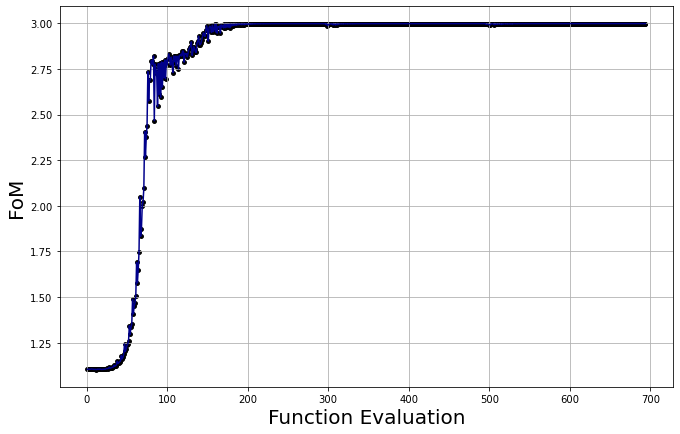

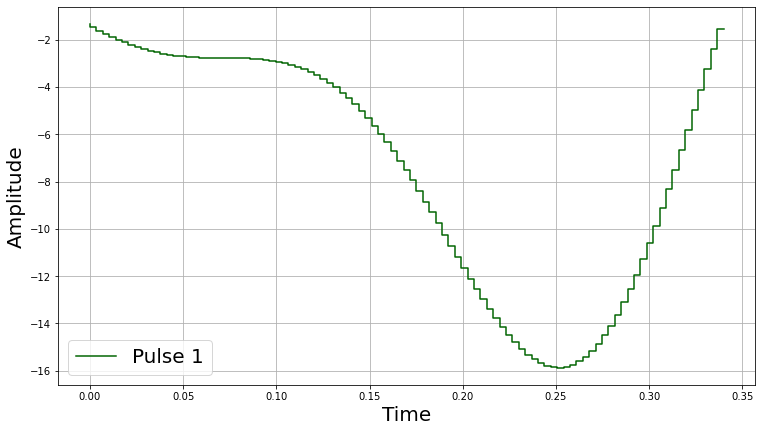

In [16]:
# Get the optimization algorithm object from the optimization object
opt_alg_obj = optimization_obj.get_optimization_algorithm()

# The FoM values for each function evaluation can be found under FoM_list in the optimization algorithm object
fomlist = opt_alg_obj.FoM_list

# Plot the FoM over the number of evaluations
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, np.asarray(fomlist), color='darkblue', linewidth=1.5, zorder=10)
ax.scatter(iterations, np.asarray(fomlist), color='k', s=15)
plt.grid(True, which="both")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('FoM', fontsize=20)

# The optimized controls can be found via the function get_best_controls() called on 
# the optimization algorithm object
controls = opt_alg_obj.get_best_controls()

# it contains the pulses and time grids under certain keys as a dictionary
pulse0, timegrid0 = controls["pulses"][0], controls["timegrids"][0]
#pulse1, timegrid1 = controls["pulses"][1], controls["timegrids"][1]
#pulse2, timegrid2 = controls["pulses"][2], controls["timegrids"][2]

# Plot the pulse over time
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.step(timegrid0, pulse0, color='darkgreen', linewidth=1.5, zorder=10)
#plt.step(timegrid1, pulse1, color='darkblue', linewidth=1.5, zorder=10)
#plt.step(timegrid2, pulse2, color='darkred', linewidth=1.5, zorder=10)

plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.legend(["Pulse 1", "Pulse 2", "Pulse 3"], fontsize=20)

In [17]:
# save into a file npy pulse0 and timegrid0
np.save("pulse0.npy", pulse0)
np.save("timegrid0.npy", timegrid0)
# save it inside the folder already existing testing
np.save("testing/pulse0.npy", pulse0)
np.save("testing/timegrid0.npy", timegrid0)

In [18]:
def Bloch_sphere_plot(psi_t, indexes_0, indexes_1, z_labels, angles=[90, 15]):
    # Print the evolution of the state |g GR g> in a Bloch sphere 
    b = Bloch(view=angles)
    b.point_marker = ['o']
    colors = ['r']
    colors += ['b' for i in range(100)]
    b.point_color = colors
    b.point_size = [15]
    b.font_size = 18
    b.zlpos = [1.2, -1.2]
    b.zlabel = z_labels
    for psi_i in psi_t:
        c_0 = np.sum(psi_i[indexes_0])/np.sqrt(len(indexes_0))
        c_1 = np.sum(psi_i[indexes_1])/np.sqrt(len(indexes_1))
        vec = ( c_0 * basis(2,0)  + c_1 * basis(2,1))
        b.add_states(vec, kind='point')

    b.figsize = [5, 10]
    b.show()
    b.render()
    b.save('b.png')

In [19]:
ryd = Ryd_chain({"is_maximization": True})
H_drift = ryd.get_drift_Hamiltonian()
H_control = ryd.get_control_Hamiltonians()
pulses = [pulse0 ]
FOM = ryd.get_FoM(pulses=pulses, timegrids=[timegrid0])

print(FOM)

Coeff of psi:  0.9999974385025631
Coeff of psi_targ:  0.49999478390384916
{'FoM': 2.998440143518722}


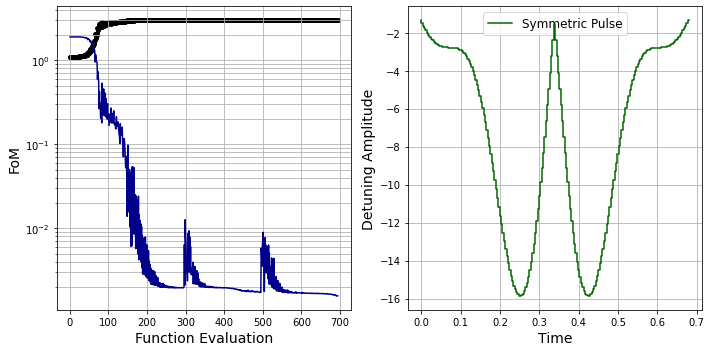

In [22]:
# make final pulse taking pulse0 and adding pulse0 reversed
final_pulse = np.concatenate((pulse0, np.flip(pulse0)))
time_grid_final = np.concatenate((np.array(timegrid0), np.array(timegrid0) + timegrid0[-1]))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot FoM on the left subplot
iterations = range(1, len(fomlist)+1)
ax1.plot(iterations, 3- np.asarray(fomlist), color='darkblue', linewidth=1.5, zorder=10)
ax1.scatter(iterations, np.asarray(fomlist), color='k', s=15)
ax1.grid(True, which="both")
ax1.set_xlabel('Function Evaluation', fontsize=14)
ax1.set_ylabel('FoM', fontsize=14)
ax1.set_yscale('log')  # Set y-axis scale to logarithmic

# Plot the pulse on the right subplot
ax2.step(time_grid_final, final_pulse, color='darkgreen', linewidth=1.5, zorder=10)
# ax2.step(timegrid1, pulse1, color='darkblue', linewidth=1.5, zorder=10)
# ax2.step(timegrid2, pulse2, color='darkred', linewidth=1.5, zorder=10)
ax2.grid(True, which="both")
ax2.set_xlabel('Time', fontsize=14)
ax2.set_ylabel('Detuning Amplitude', fontsize=14)
ax2.legend(["Symmetric Pulse"], fontsize=12)

plt.tight_layout()
plt.show()